# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.59469811739118 -2.5474058812013642
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [18]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    #Qs_labels = targetQs[1:]
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    #g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [19]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [22]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [33]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelR2.ckpt')

Episode:0 meanR:8.0000 rate:0.0160 gloss:-0.1021 dloss:0.6233 dlossR:0.6233 dlossQ:0.6891
Episode:1 meanR:8.5000 rate:0.0180 gloss:0.1940 dloss:0.8637 dlossR:0.8637 dlossQ:0.6730
Episode:2 meanR:9.0000 rate:0.0200 gloss:0.1616 dloss:0.8486 dlossR:0.8486 dlossQ:0.6755
Episode:3 meanR:9.0000 rate:0.0180 gloss:0.1216 dloss:0.8105 dlossR:0.8105 dlossQ:0.6821
Episode:4 meanR:9.0000 rate:0.0180 gloss:0.0885 dloss:0.7838 dlossR:0.7838 dlossQ:0.6857
Episode:5 meanR:8.8333 rate:0.0160 gloss:0.0530 dloss:0.7429 dlossR:0.7429 dlossQ:0.6902
Episode:6 meanR:9.0000 rate:0.0200 gloss:0.0353 dloss:0.7351 dlossR:0.7351 dlossQ:0.6905
Episode:7 meanR:9.1250 rate:0.0200 gloss:0.0117 dloss:0.7072 dlossR:0.7072 dlossQ:0.6922
Episode:8 meanR:9.1111 rate:0.0180 gloss:-0.0026 dloss:0.6856 dlossR:0.6856 dlossQ:0.6930
Episode:9 meanR:9.2000 rate:0.0200 gloss:-0.0206 dloss:0.6604 dlossR:0.6604 dlossQ:0.6929
Episode:10 meanR:9.2727 rate:0.0200 gloss:-0.0304 dloss:0.6427 dlossR:0.6427 dlossQ:0.6923
Episode:11 meanR

Episode:94 meanR:26.3053 rate:0.0380 gloss:-2.0865 dloss:0.1703 dlossR:0.1703 dlossQ:0.2012
Episode:95 meanR:26.2083 rate:0.0340 gloss:-2.1267 dloss:0.1582 dlossR:0.1582 dlossQ:0.1972
Episode:96 meanR:26.4845 rate:0.1060 gloss:-1.7571 dloss:0.3507 dlossR:0.3507 dlossQ:0.2631
Episode:97 meanR:27.0510 rate:0.1640 gloss:-1.7012 dloss:0.5038 dlossR:0.5038 dlossQ:0.2772
Episode:98 meanR:28.0707 rate:0.2560 gloss:-1.6857 dloss:0.7625 dlossR:0.7625 dlossQ:0.2824
Episode:99 meanR:28.6400 rate:0.1700 gloss:-1.7737 dloss:0.5329 dlossR:0.5329 dlossQ:0.2573
Episode:100 meanR:28.7600 rate:0.0400 gloss:-1.9910 dloss:0.1740 dlossR:0.1740 dlossQ:0.2185
Episode:101 meanR:28.9900 rate:0.0640 gloss:-1.8195 dloss:0.2421 dlossR:0.2421 dlossQ:0.2545
Episode:102 meanR:29.1600 rate:0.0540 gloss:-1.9211 dloss:0.2142 dlossR:0.2142 dlossQ:0.2312
Episode:103 meanR:29.3000 rate:0.0460 gloss:-1.8704 dloss:0.1930 dlossR:0.1930 dlossQ:0.2433
Episode:104 meanR:29.8400 rate:0.1260 gloss:-1.7052 dloss:0.4012 dlossR:0.40

Episode:187 meanR:36.0300 rate:0.1660 gloss:-1.5550 dloss:0.4892 dlossR:0.4892 dlossQ:0.3176
Episode:188 meanR:36.4800 rate:0.1180 gloss:-1.6109 dloss:0.3738 dlossR:0.3738 dlossQ:0.3016
Episode:189 meanR:36.5000 rate:0.0340 gloss:-1.7600 dloss:0.1619 dlossR:0.1619 dlossQ:0.2649
Episode:190 meanR:36.5000 rate:0.0320 gloss:-1.8501 dloss:0.1524 dlossR:0.1524 dlossQ:0.2431
Episode:191 meanR:36.4500 rate:0.0240 gloss:-1.9218 dloss:0.1289 dlossR:0.1289 dlossQ:0.2279
Episode:192 meanR:36.4400 rate:0.0360 gloss:-1.8558 dloss:0.1631 dlossR:0.1631 dlossQ:0.2424
Episode:193 meanR:36.4200 rate:0.0320 gloss:-1.8927 dloss:0.1512 dlossR:0.1512 dlossQ:0.2344
Episode:194 meanR:36.3400 rate:0.0220 gloss:-2.2443 dloss:0.1154 dlossR:0.1154 dlossQ:0.1675
Episode:195 meanR:36.2900 rate:0.0240 gloss:-2.1647 dloss:0.1220 dlossR:0.1220 dlossQ:0.1797
Episode:196 meanR:35.8800 rate:0.0240 gloss:-2.1899 dloss:0.1212 dlossR:0.1212 dlossQ:0.1751
Episode:197 meanR:35.1600 rate:0.0200 gloss:-2.4508 dloss:0.1104 dloss

Episode:276 meanR:52.0100 rate:0.1440 gloss:-0.8438 dloss:0.4286 dlossR:0.4286 dlossQ:0.5388
Episode:277 meanR:52.5900 rate:0.1540 gloss:-0.8067 dloss:0.4462 dlossR:0.4462 dlossQ:0.5500
Episode:278 meanR:53.0200 rate:0.1280 gloss:-0.7372 dloss:0.4182 dlossR:0.4182 dlossQ:0.5722
Episode:279 meanR:53.5500 rate:0.1580 gloss:-0.7344 dloss:0.4540 dlossR:0.4540 dlossQ:0.5728
Episode:280 meanR:53.8100 rate:0.1140 gloss:-0.7448 dloss:0.4013 dlossR:0.4013 dlossQ:0.5698
Episode:281 meanR:54.1300 rate:0.1240 gloss:-0.7549 dloss:0.4111 dlossR:0.4111 dlossQ:0.5669
Episode:282 meanR:54.1900 rate:0.1280 gloss:-0.7416 dloss:0.4175 dlossR:0.4175 dlossQ:0.5708
Episode:283 meanR:54.2700 rate:0.1220 gloss:-0.7597 dloss:0.4088 dlossR:0.4088 dlossQ:0.5646
Episode:284 meanR:54.7300 rate:0.1300 gloss:-0.7481 dloss:0.4204 dlossR:0.4204 dlossQ:0.5678
Episode:285 meanR:54.6600 rate:0.0340 gloss:-0.8868 dloss:0.2836 dlossR:0.2836 dlossQ:0.5256
Episode:286 meanR:54.7000 rate:0.0380 gloss:-0.8845 dloss:0.2881 dloss

Episode:372 meanR:44.3600 rate:0.0600 gloss:-1.5782 dloss:0.2351 dlossR:0.2351 dlossQ:0.3153
Episode:373 meanR:43.4600 rate:0.0620 gloss:-1.5785 dloss:0.2406 dlossR:0.2406 dlossQ:0.3159
Episode:374 meanR:43.4600 rate:0.1880 gloss:-1.4059 dloss:0.5247 dlossR:0.5247 dlossQ:0.3645
Episode:375 meanR:43.5900 rate:0.1780 gloss:-1.3832 dloss:0.4972 dlossR:0.4972 dlossQ:0.3696
Episode:376 meanR:43.3700 rate:0.1000 gloss:-1.5620 dloss:0.3344 dlossR:0.3344 dlossQ:0.3250
Episode:377 meanR:43.7000 rate:0.2200 gloss:-1.3890 dloss:0.5960 dlossR:0.5960 dlossQ:0.3685
Episode:378 meanR:44.2300 rate:0.2340 gloss:-1.3969 dloss:0.6330 dlossR:0.6330 dlossQ:0.3681
Episode:379 meanR:43.8400 rate:0.0800 gloss:-1.5283 dloss:0.2810 dlossR:0.2810 dlossQ:0.3271
Episode:380 meanR:43.7500 rate:0.0960 gloss:-1.5230 dloss:0.3178 dlossR:0.3178 dlossQ:0.3287
Episode:381 meanR:43.4200 rate:0.0580 gloss:-1.5446 dloss:0.2300 dlossR:0.2300 dlossQ:0.3222
Episode:382 meanR:43.1800 rate:0.0800 gloss:-1.5440 dloss:0.2808 dloss

Episode:465 meanR:43.1700 rate:0.0680 gloss:-1.7039 dloss:0.2526 dlossR:0.2526 dlossQ:0.2840
Episode:466 meanR:43.4900 rate:0.0860 gloss:-1.6876 dloss:0.2991 dlossR:0.2991 dlossQ:0.2896
Episode:467 meanR:44.0600 rate:0.1420 gloss:-1.7980 dloss:0.4695 dlossR:0.4695 dlossQ:0.2870
Episode:468 meanR:44.5100 rate:0.1160 gloss:-1.5316 dloss:0.3656 dlossR:0.3656 dlossQ:0.3277
Episode:469 meanR:44.7600 rate:0.0820 gloss:-1.5314 dloss:0.2860 dlossR:0.2860 dlossQ:0.3270
Episode:470 meanR:44.9100 rate:0.0920 gloss:-1.5353 dloss:0.3100 dlossR:0.3100 dlossQ:0.3266
Episode:471 meanR:44.8300 rate:0.0340 gloss:-1.8071 dloss:0.1609 dlossR:0.1609 dlossQ:0.2562
Episode:472 meanR:44.6700 rate:0.0280 gloss:-1.9519 dloss:0.1396 dlossR:0.1396 dlossQ:0.2228
Episode:473 meanR:44.4900 rate:0.0260 gloss:-1.9977 dloss:0.1322 dlossR:0.1322 dlossQ:0.2123
Episode:474 meanR:43.6800 rate:0.0260 gloss:-2.0309 dloss:0.1315 dlossR:0.1315 dlossQ:0.2061
Episode:475 meanR:42.9400 rate:0.0300 gloss:-2.1726 dloss:0.1413 dloss

Episode:554 meanR:62.9100 rate:0.1620 gloss:-1.2764 dloss:0.4559 dlossR:0.4559 dlossQ:0.4040
Episode:555 meanR:63.1900 rate:0.1280 gloss:-1.2708 dloss:0.3862 dlossR:0.3862 dlossQ:0.4050
Episode:556 meanR:62.7400 rate:0.0560 gloss:-1.2817 dloss:0.2467 dlossR:0.2467 dlossQ:0.4013
Episode:557 meanR:62.7200 rate:0.1280 gloss:-1.2633 dloss:0.3856 dlossR:0.3856 dlossQ:0.4070
Episode:558 meanR:62.2000 rate:0.0400 gloss:-1.3688 dloss:0.2083 dlossR:0.2083 dlossQ:0.3752
Episode:559 meanR:61.6600 rate:0.0300 gloss:-1.4598 dloss:0.1797 dlossR:0.1797 dlossQ:0.3479
Episode:560 meanR:61.3900 rate:0.0160 gloss:-1.8363 dloss:0.1315 dlossR:0.1315 dlossQ:0.2598
Episode:561 meanR:61.8200 rate:0.1480 gloss:-1.2463 dloss:0.4239 dlossR:0.4239 dlossQ:0.4124
Episode:562 meanR:62.0900 rate:0.1260 gloss:-1.1965 dloss:0.3810 dlossR:0.3810 dlossQ:0.4275
Episode:563 meanR:62.5100 rate:0.1520 gloss:-1.1699 dloss:0.4291 dlossR:0.4291 dlossQ:0.4364
Episode:564 meanR:62.8500 rate:0.1500 gloss:-1.1329 dloss:0.4242 dloss

Episode:646 meanR:56.8900 rate:0.0380 gloss:-1.4149 dloss:0.2011 dlossR:0.2011 dlossQ:0.3634
Episode:647 meanR:56.8700 rate:0.0340 gloss:-1.4081 dloss:0.1938 dlossR:0.1938 dlossQ:0.3659
Episode:648 meanR:57.1200 rate:0.0900 gloss:-1.3801 dloss:0.3091 dlossR:0.3091 dlossQ:0.3748
Episode:649 meanR:60.4500 rate:0.9180 gloss:-0.7561 dloss:1.9918 dlossR:1.9918 dlossQ:0.6383
Episode:650 meanR:59.9100 rate:0.0220 gloss:-1.8478 dloss:0.1422 dlossR:0.1422 dlossQ:0.2538
Episode:651 meanR:59.4300 rate:0.0240 gloss:-1.8894 dloss:0.1432 dlossR:0.1432 dlossQ:0.2423
Episode:652 meanR:58.7400 rate:0.0200 gloss:-1.8537 dloss:0.1386 dlossR:0.1386 dlossQ:0.2525
Episode:653 meanR:58.7200 rate:0.1320 gloss:-1.1962 dloss:0.3956 dlossR:0.3956 dlossQ:0.4322
Episode:654 meanR:58.1100 rate:0.0400 gloss:-1.3024 dloss:0.2169 dlossR:0.2169 dlossQ:0.3961
Episode:655 meanR:57.6700 rate:0.0400 gloss:-1.3072 dloss:0.2164 dlossR:0.2164 dlossQ:0.3947
Episode:656 meanR:57.6200 rate:0.0460 gloss:-1.3259 dloss:0.2250 dloss

Episode:735 meanR:51.1600 rate:0.1280 gloss:-1.3569 dloss:0.3864 dlossR:0.3864 dlossQ:0.3799
Episode:736 meanR:51.1800 rate:0.1160 gloss:-1.4022 dloss:0.3635 dlossR:0.3635 dlossQ:0.3661
Episode:737 meanR:51.3900 rate:0.1380 gloss:-1.3514 dloss:0.4074 dlossR:0.4074 dlossQ:0.3818
Episode:738 meanR:51.4000 rate:0.1060 gloss:-1.3669 dloss:0.3401 dlossR:0.3401 dlossQ:0.3767
Episode:739 meanR:51.5000 rate:0.0760 gloss:-1.5635 dloss:0.2808 dlossR:0.2808 dlossQ:0.3296
Episode:740 meanR:52.1700 rate:0.1760 gloss:-1.3675 dloss:0.4940 dlossR:0.4940 dlossQ:0.3783
Episode:741 meanR:52.2700 rate:0.0620 gloss:-1.6458 dloss:0.2434 dlossR:0.2434 dlossQ:0.3047
Episode:742 meanR:52.4400 rate:0.0720 gloss:-1.6571 dloss:0.2713 dlossR:0.2713 dlossQ:0.3047
Episode:743 meanR:52.0700 rate:0.0240 gloss:-2.2720 dloss:0.1268 dlossR:0.1268 dlossQ:0.1709
Episode:744 meanR:52.0000 rate:0.0200 gloss:-2.3428 dloss:0.1157 dlossR:0.1157 dlossQ:0.1641
Episode:745 meanR:52.3600 rate:0.1060 gloss:-1.3993 dloss:0.3409 dloss

Episode:831 meanR:59.6200 rate:0.1520 gloss:-1.1160 dloss:0.4275 dlossR:0.4275 dlossQ:0.4550
Episode:832 meanR:59.1300 rate:0.0900 gloss:-1.1831 dloss:0.3164 dlossR:0.3164 dlossQ:0.4332
Episode:833 meanR:59.2600 rate:0.0840 gloss:-1.2735 dloss:0.2999 dlossR:0.2999 dlossQ:0.4060
Episode:834 meanR:58.8400 rate:0.0640 gloss:-1.3543 dloss:0.2566 dlossR:0.2566 dlossQ:0.3819
Episode:835 meanR:58.5600 rate:0.0720 gloss:-1.3546 dloss:0.2736 dlossR:0.2736 dlossQ:0.3814
Episode:836 meanR:58.3300 rate:0.0700 gloss:-1.3595 dloss:0.2681 dlossR:0.2681 dlossQ:0.3801
Episode:837 meanR:57.8500 rate:0.0420 gloss:-1.5074 dloss:0.2002 dlossR:0.2002 dlossQ:0.3373
Episode:838 meanR:57.6000 rate:0.0560 gloss:-1.4196 dloss:0.2365 dlossR:0.2365 dlossQ:0.3618
Episode:839 meanR:57.5500 rate:0.0660 gloss:-1.4208 dloss:0.2570 dlossR:0.2570 dlossQ:0.3613
Episode:840 meanR:56.8100 rate:0.0280 gloss:-1.7203 dloss:0.1528 dlossR:0.1528 dlossQ:0.2780
Episode:841 meanR:56.6500 rate:0.0300 gloss:-1.7271 dloss:0.1572 dloss

Episode:923 meanR:32.1200 rate:0.0800 gloss:-1.7444 dloss:0.2835 dlossR:0.2835 dlossQ:0.2740
Episode:924 meanR:32.4100 rate:0.0760 gloss:-1.7499 dloss:0.2778 dlossR:0.2778 dlossQ:0.2780
Episode:925 meanR:32.5900 rate:0.0640 gloss:-1.7427 dloss:0.2436 dlossR:0.2436 dlossQ:0.2748
Episode:926 meanR:32.6800 rate:0.0420 gloss:-1.8946 dloss:0.1852 dlossR:0.1852 dlossQ:0.2442
Episode:927 meanR:32.9900 rate:0.0940 gloss:-1.7405 dloss:0.3238 dlossR:0.3238 dlossQ:0.2791
Episode:928 meanR:33.0700 rate:0.0440 gloss:-2.0273 dloss:0.1943 dlossR:0.1943 dlossQ:0.2267
Episode:929 meanR:33.1200 rate:0.0680 gloss:-1.7980 dloss:0.2582 dlossR:0.2582 dlossQ:0.2694
Episode:930 meanR:32.3000 rate:0.0180 gloss:-2.3593 dloss:0.1029 dlossR:0.1029 dlossQ:0.1549
Episode:931 meanR:32.1400 rate:0.1200 gloss:-1.5545 dloss:0.3753 dlossR:0.3753 dlossQ:0.3186
Episode:932 meanR:32.4900 rate:0.1600 gloss:-1.4637 dloss:0.4656 dlossR:0.4656 dlossQ:0.3467
Episode:933 meanR:32.1500 rate:0.0160 gloss:-2.5343 dloss:0.0965 dloss

Episode:1012 meanR:33.5700 rate:0.0700 gloss:-1.7149 dloss:0.2570 dlossR:0.2570 dlossQ:0.2797
Episode:1013 meanR:33.4200 rate:0.0500 gloss:-1.9620 dloss:0.2043 dlossR:0.2043 dlossQ:0.2253
Episode:1014 meanR:33.4100 rate:0.0560 gloss:-1.9629 dloss:0.2209 dlossR:0.2209 dlossQ:0.2237
Episode:1015 meanR:33.5100 rate:0.0720 gloss:-1.8356 dloss:0.2642 dlossR:0.2642 dlossQ:0.2512
Episode:1016 meanR:33.3500 rate:0.0240 gloss:-2.1329 dloss:0.1236 dlossR:0.1236 dlossQ:0.1868
Episode:1017 meanR:33.2400 rate:0.0240 gloss:-2.1485 dloss:0.1231 dlossR:0.1231 dlossQ:0.1835
Episode:1018 meanR:33.2000 rate:0.0280 gloss:-2.1004 dloss:0.1356 dlossR:0.1356 dlossQ:0.1920
Episode:1019 meanR:33.2000 rate:0.0220 gloss:-2.1464 dloss:0.1173 dlossR:0.1173 dlossQ:0.1840
Episode:1020 meanR:33.4700 rate:0.0840 gloss:-1.6911 dloss:0.2950 dlossR:0.2950 dlossQ:0.2883
Episode:1021 meanR:33.6400 rate:0.0640 gloss:-1.7823 dloss:0.2465 dlossR:0.2465 dlossQ:0.2702
Episode:1022 meanR:34.0300 rate:0.1360 gloss:-1.5991 dloss:0

Episode:1102 meanR:48.8700 rate:0.2400 gloss:-1.4187 dloss:0.6508 dlossR:0.6508 dlossQ:0.3626
Episode:1103 meanR:49.0800 rate:0.0700 gloss:-1.6961 dloss:0.2605 dlossR:0.2605 dlossQ:0.2881
Episode:1104 meanR:48.9400 rate:0.0840 gloss:-1.6869 dloss:0.2961 dlossR:0.2961 dlossQ:0.2917
Episode:1105 meanR:48.4400 rate:0.0920 gloss:-1.6609 dloss:0.3151 dlossR:0.3151 dlossQ:0.2972
Episode:1106 meanR:48.2100 rate:0.0680 gloss:-1.7896 dloss:0.2550 dlossR:0.2550 dlossQ:0.2654
Episode:1107 meanR:48.0600 rate:0.0300 gloss:-2.0611 dloss:0.1519 dlossR:0.1519 dlossQ:0.2178
Episode:1108 meanR:48.4700 rate:0.1060 gloss:-1.6175 dloss:0.3468 dlossR:0.3468 dlossQ:0.3059
Episode:1109 meanR:48.4800 rate:0.0320 gloss:-1.9597 dloss:0.1512 dlossR:0.1512 dlossQ:0.2216
Episode:1110 meanR:48.2700 rate:0.0240 gloss:-2.0822 dloss:0.1261 dlossR:0.1261 dlossQ:0.1986
Episode:1111 meanR:48.5500 rate:0.1340 gloss:-1.4366 dloss:0.4048 dlossR:0.4048 dlossQ:0.3561
Episode:1112 meanR:49.1200 rate:0.1840 gloss:-1.3646 dloss:0

Episode:1195 meanR:95.7100 rate:0.0920 gloss:-1.3661 dloss:0.3120 dlossR:0.3120 dlossQ:0.3751
Episode:1196 meanR:95.3000 rate:0.0660 gloss:-1.5620 dloss:0.2513 dlossR:0.2513 dlossQ:0.3206
Episode:1197 meanR:95.4300 rate:0.1320 gloss:-1.3879 dloss:0.3972 dlossR:0.3972 dlossQ:0.3693
Episode:1198 meanR:95.2400 rate:0.1500 gloss:-1.3589 dloss:0.4360 dlossR:0.4360 dlossQ:0.3790
Episode:1199 meanR:95.9700 rate:0.1920 gloss:-1.2503 dloss:0.5166 dlossR:0.5166 dlossQ:0.4135
Episode:1200 meanR:98.3700 rate:0.5560 gloss:-1.0491 dloss:1.2806 dlossR:1.2806 dlossQ:0.4957
Episode:1201 meanR:100.6600 rate:0.5320 gloss:-1.2802 dloss:1.3693 dlossR:1.3693 dlossQ:0.4208
Episode:1202 meanR:99.5800 rate:0.0240 gloss:-1.7864 dloss:0.1387 dlossR:0.1387 dlossQ:0.2611
Episode:1203 meanR:99.3300 rate:0.0200 gloss:-1.9291 dloss:0.1240 dlossR:0.1240 dlossQ:0.2306
Episode:1204 meanR:100.3900 rate:0.2960 gloss:-1.3535 dloss:0.7752 dlossR:0.7752 dlossQ:0.3868
Episode:1205 meanR:100.1600 rate:0.0460 gloss:-1.6482 dlos

Episode:1285 meanR:58.6600 rate:0.0800 gloss:-1.5846 dloss:0.2866 dlossR:0.2866 dlossQ:0.3202
Episode:1286 meanR:58.4700 rate:0.0580 gloss:-1.7392 dloss:0.2325 dlossR:0.2325 dlossQ:0.2830
Episode:1287 meanR:59.2000 rate:0.2260 gloss:-1.3476 dloss:0.6044 dlossR:0.6044 dlossQ:0.3853
Episode:1288 meanR:59.6100 rate:0.1620 gloss:-1.5780 dloss:0.4856 dlossR:0.4856 dlossQ:0.3192
Episode:1289 meanR:60.1200 rate:0.1620 gloss:-1.5029 dloss:0.4744 dlossR:0.4744 dlossQ:0.3366
Episode:1290 meanR:60.7100 rate:0.1640 gloss:-1.4416 dloss:0.4757 dlossR:0.4757 dlossQ:0.3569
Episode:1291 meanR:61.3700 rate:0.1700 gloss:-1.5459 dloss:0.5005 dlossR:0.5005 dlossQ:0.3254
Episode:1292 meanR:61.7300 rate:0.1160 gloss:-1.6408 dloss:0.3718 dlossR:0.3718 dlossQ:0.2974
Episode:1293 meanR:61.6600 rate:0.0280 gloss:-2.2373 dloss:0.1341 dlossR:0.1341 dlossQ:0.1698
Episode:1294 meanR:61.8500 rate:0.1000 gloss:-1.4754 dloss:0.3355 dlossR:0.3355 dlossQ:0.3478
Episode:1295 meanR:61.5500 rate:0.0320 gloss:-2.1732 dloss:0

Episode:1375 meanR:59.4900 rate:0.2260 gloss:-0.8257 dloss:0.5426 dlossR:0.5426 dlossQ:0.5489
Episode:1376 meanR:59.8400 rate:0.0960 gloss:-0.9477 dloss:0.3512 dlossR:0.3512 dlossQ:0.5077
Episode:1377 meanR:59.8200 rate:0.0540 gloss:-1.2154 dloss:0.2617 dlossR:0.2617 dlossQ:0.4260
Episode:1378 meanR:59.9800 rate:0.1100 gloss:-0.9256 dloss:0.3732 dlossR:0.3732 dlossQ:0.5152
Episode:1379 meanR:62.1300 rate:0.5040 gloss:-0.5139 dloss:0.8927 dlossR:0.8927 dlossQ:0.6514
Episode:1380 meanR:61.8900 rate:0.0380 gloss:-1.4253 dloss:0.2101 dlossR:0.2101 dlossQ:0.3633
Episode:1381 meanR:62.0200 rate:0.0760 gloss:-1.1598 dloss:0.3054 dlossR:0.3054 dlossQ:0.4445
Episode:1382 meanR:61.9800 rate:0.0800 gloss:-1.2268 dloss:0.3063 dlossR:0.3063 dlossQ:0.4225
Episode:1383 meanR:61.7300 rate:0.0440 gloss:-1.1802 dloss:0.2523 dlossR:0.2523 dlossQ:0.4367
Episode:1384 meanR:62.5300 rate:0.2760 gloss:-0.6657 dloss:0.6108 dlossR:0.6108 dlossQ:0.5917
Episode:1385 meanR:63.6500 rate:0.3040 gloss:-0.6179 dloss:0

Episode:1464 meanR:110.9900 rate:0.0220 gloss:-2.0600 dloss:0.1343 dlossR:0.1343 dlossQ:0.2160
Episode:1465 meanR:111.9400 rate:0.4660 gloss:-0.8990 dloss:0.9881 dlossR:0.9881 dlossQ:0.5396
Episode:1466 meanR:111.2700 rate:0.2060 gloss:-1.2194 dloss:0.5433 dlossR:0.5433 dlossQ:0.4248
Episode:1467 meanR:110.2700 rate:0.0820 gloss:-1.2537 dloss:0.3013 dlossR:0.3013 dlossQ:0.4120
Episode:1468 meanR:110.4700 rate:0.0940 gloss:-1.1973 dloss:0.3261 dlossR:0.3261 dlossQ:0.4291
Episode:1469 meanR:108.5000 rate:0.1660 gloss:-1.1370 dloss:0.4575 dlossR:0.4575 dlossQ:0.4494
Episode:1470 meanR:108.3000 rate:0.0940 gloss:-1.2210 dloss:0.3244 dlossR:0.3244 dlossQ:0.4219
Episode:1471 meanR:108.6800 rate:0.1280 gloss:-1.1444 dloss:0.3882 dlossR:0.3882 dlossQ:0.4462
Episode:1472 meanR:109.1900 rate:0.1300 gloss:-1.1348 dloss:0.3917 dlossR:0.3917 dlossQ:0.4488
Episode:1473 meanR:109.3600 rate:0.0680 gloss:-1.3152 dloss:0.2712 dlossR:0.2712 dlossQ:0.3937
Episode:1474 meanR:108.9600 rate:0.0600 gloss:-1.3

Episode:1553 meanR:63.3900 rate:0.1320 gloss:-1.3220 dloss:0.4010 dlossR:0.4010 dlossQ:0.3971
Episode:1554 meanR:62.9100 rate:0.0460 gloss:-1.6771 dloss:0.2083 dlossR:0.2083 dlossQ:0.3028
Episode:1555 meanR:62.3800 rate:0.0180 gloss:-2.2243 dloss:0.1132 dlossR:0.1132 dlossQ:0.1829
Episode:1556 meanR:62.7100 rate:0.1660 gloss:-1.2902 dloss:0.4630 dlossR:0.4630 dlossQ:0.3993
Episode:1557 meanR:63.1700 rate:0.1140 gloss:-1.1841 dloss:0.3589 dlossR:0.3589 dlossQ:0.4313
Episode:1558 meanR:63.3200 rate:0.1340 gloss:-1.1704 dloss:0.3949 dlossR:0.3949 dlossQ:0.4367
Episode:1559 meanR:63.7300 rate:0.1320 gloss:-1.1663 dloss:0.3927 dlossR:0.3927 dlossQ:0.4397
Episode:1560 meanR:63.7900 rate:0.0960 gloss:-1.1984 dloss:0.3264 dlossR:0.3264 dlossQ:0.4294
Episode:1561 meanR:63.2200 rate:0.0980 gloss:-1.2122 dloss:0.3300 dlossR:0.3300 dlossQ:0.4265
Episode:1562 meanR:63.3600 rate:0.0500 gloss:-1.4235 dloss:0.2229 dlossR:0.2229 dlossQ:0.3616
Episode:1563 meanR:63.0800 rate:0.0380 gloss:-1.5531 dloss:0

Episode:1643 meanR:47.9800 rate:0.2420 gloss:-1.3363 dloss:0.6388 dlossR:0.6388 dlossQ:0.3884
Episode:1644 meanR:47.4800 rate:0.0340 gloss:-1.7798 dloss:0.1670 dlossR:0.1670 dlossQ:0.2665
Episode:1645 meanR:46.8600 rate:0.0340 gloss:-1.7787 dloss:0.1643 dlossR:0.1643 dlossQ:0.2643
Episode:1646 meanR:46.2900 rate:0.0240 gloss:-2.0326 dloss:0.1291 dlossR:0.1291 dlossQ:0.2090
Episode:1647 meanR:45.3700 rate:0.0220 gloss:-2.0716 dloss:0.1236 dlossR:0.1236 dlossQ:0.2029
Episode:1648 meanR:45.1600 rate:0.1240 gloss:-1.4239 dloss:0.3807 dlossR:0.3807 dlossQ:0.3585
Episode:1649 meanR:44.7000 rate:0.0160 gloss:-2.2208 dloss:0.1072 dlossR:0.1072 dlossQ:0.1846
Episode:1650 meanR:45.1900 rate:0.1340 gloss:-1.3476 dloss:0.3987 dlossR:0.3987 dlossQ:0.3806
Episode:1651 meanR:45.1800 rate:0.0800 gloss:-1.5288 dloss:0.2884 dlossR:0.2884 dlossQ:0.3348
Episode:1652 meanR:45.2400 rate:0.0280 gloss:-1.9386 dloss:0.1440 dlossR:0.1440 dlossQ:0.2302
Episode:1653 meanR:44.7000 rate:0.0240 gloss:-2.0782 dloss:0

Episode:1736 meanR:39.1800 rate:0.0700 gloss:-1.7793 dloss:0.2632 dlossR:0.2632 dlossQ:0.2718
Episode:1737 meanR:39.1600 rate:0.0240 gloss:-2.3503 dloss:0.1239 dlossR:0.1239 dlossQ:0.1575
Episode:1738 meanR:39.8300 rate:0.1600 gloss:-1.5140 dloss:0.4735 dlossR:0.4735 dlossQ:0.3373
Episode:1739 meanR:41.1900 rate:0.2940 gloss:-1.3850 dloss:0.7800 dlossR:0.7800 dlossQ:0.3770
Episode:1740 meanR:41.1500 rate:0.0260 gloss:-2.1250 dloss:0.1324 dlossR:0.1324 dlossQ:0.1927
Episode:1741 meanR:41.1200 rate:0.0280 gloss:-2.0749 dloss:0.1395 dlossR:0.1395 dlossQ:0.2023
Episode:1742 meanR:40.7600 rate:0.0320 gloss:-2.0696 dloss:0.1567 dlossR:0.1567 dlossQ:0.2123
Episode:1743 meanR:39.7000 rate:0.0300 gloss:-2.2112 dloss:0.1429 dlossR:0.1429 dlossQ:0.1764
Episode:1744 meanR:39.8400 rate:0.0620 gloss:-1.7185 dloss:0.2412 dlossR:0.2412 dlossQ:0.2845
Episode:1745 meanR:39.9700 rate:0.0600 gloss:-1.8478 dloss:0.2373 dlossR:0.2373 dlossQ:0.2581
Episode:1746 meanR:40.1600 rate:0.0620 gloss:-1.8282 dloss:0

Episode:1826 meanR:76.2200 rate:0.1020 gloss:-1.2808 dloss:0.3521 dlossR:0.3521 dlossQ:0.4151
Episode:1827 meanR:76.3400 rate:0.1180 gloss:-1.2468 dloss:0.3816 dlossR:0.3816 dlossQ:0.4246
Episode:1828 meanR:76.1600 rate:0.1500 gloss:-1.2173 dloss:0.4411 dlossR:0.4411 dlossQ:0.4335
Episode:1829 meanR:76.0600 rate:0.0940 gloss:-1.3861 dloss:0.3304 dlossR:0.3304 dlossQ:0.3833
Episode:1830 meanR:75.3400 rate:0.0700 gloss:-1.2825 dloss:0.2730 dlossR:0.2730 dlossQ:0.4012
Episode:1831 meanR:75.2000 rate:0.0640 gloss:-1.2815 dloss:0.2630 dlossR:0.2630 dlossQ:0.4017
Episode:1832 meanR:75.3600 rate:0.0960 gloss:-1.3925 dloss:0.3259 dlossR:0.3259 dlossQ:0.3735
Episode:1833 meanR:75.5700 rate:0.0820 gloss:-1.3005 dloss:0.2957 dlossR:0.2957 dlossQ:0.3967
Episode:1834 meanR:75.6700 rate:0.0820 gloss:-1.4369 dloss:0.2942 dlossR:0.2942 dlossQ:0.3586
Episode:1835 meanR:75.4100 rate:0.0320 gloss:-1.5995 dloss:0.1718 dlossR:0.1718 dlossQ:0.3106
Episode:1836 meanR:75.2000 rate:0.0280 gloss:-1.8028 dloss:0

Episode:1914 meanR:58.2900 rate:0.0880 gloss:-1.3526 dloss:0.3058 dlossR:0.3058 dlossQ:0.3815
Episode:1915 meanR:58.5300 rate:0.0720 gloss:-1.5520 dloss:0.2684 dlossR:0.2684 dlossQ:0.3276
Episode:1916 meanR:62.6200 rate:0.8420 gloss:-0.6453 dloss:1.6651 dlossR:1.6651 dlossQ:0.6608
Episode:1917 meanR:64.7800 rate:0.4600 gloss:-0.9386 dloss:0.9959 dlossR:0.9959 dlossQ:0.5271
Episode:1918 meanR:64.1200 rate:0.2360 gloss:-1.0040 dloss:0.5754 dlossR:0.5754 dlossQ:0.4945
Episode:1919 meanR:64.6100 rate:0.2100 gloss:-1.0153 dloss:0.5303 dlossR:0.5303 dlossQ:0.4895
Episode:1920 meanR:65.2700 rate:0.2160 gloss:-1.0259 dloss:0.5417 dlossR:0.5417 dlossQ:0.4860
Episode:1921 meanR:66.0800 rate:0.1940 gloss:-1.0440 dloss:0.5035 dlossR:0.5035 dlossQ:0.4795
Episode:1922 meanR:66.7700 rate:0.1640 gloss:-0.9816 dloss:0.4522 dlossR:0.4522 dlossQ:0.4981
Episode:1923 meanR:67.3300 rate:0.1380 gloss:-0.9753 dloss:0.4109 dlossR:0.4109 dlossQ:0.5003
Episode:1924 meanR:68.0900 rate:0.1840 gloss:-0.9803 dloss:0

Episode:2006 meanR:81.1100 rate:0.0560 gloss:-1.3364 dloss:0.2449 dlossR:0.2449 dlossQ:0.3875
Episode:2007 meanR:80.7100 rate:0.0400 gloss:-1.2743 dloss:0.2231 dlossR:0.2231 dlossQ:0.4065
Episode:2008 meanR:80.5800 rate:0.0460 gloss:-1.3453 dloss:0.2258 dlossR:0.2258 dlossQ:0.3852
Episode:2009 meanR:80.4500 rate:0.0480 gloss:-1.3499 dloss:0.2296 dlossR:0.2296 dlossQ:0.3848
Episode:2010 meanR:80.2800 rate:0.0560 gloss:-1.4415 dloss:0.2347 dlossR:0.2347 dlossQ:0.3560
Episode:2011 meanR:80.3400 rate:0.0740 gloss:-1.4329 dloss:0.2724 dlossR:0.2724 dlossQ:0.3586
Episode:2012 meanR:80.6400 rate:0.0800 gloss:-1.3630 dloss:0.2901 dlossR:0.2901 dlossQ:0.3817
Episode:2013 meanR:80.8600 rate:0.0880 gloss:-1.3436 dloss:0.3054 dlossR:0.3054 dlossQ:0.3865
Episode:2014 meanR:80.9900 rate:0.1140 gloss:-1.1568 dloss:0.3607 dlossR:0.3607 dlossQ:0.4435
Episode:2015 meanR:81.3900 rate:0.1520 gloss:-1.1067 dloss:0.4299 dlossR:0.4299 dlossQ:0.4605
Episode:2016 meanR:78.1900 rate:0.2020 gloss:-1.0631 dloss:0

Episode:2095 meanR:67.3000 rate:0.2220 gloss:-0.5861 dloss:0.5480 dlossR:0.5480 dlossQ:0.6081
Episode:2096 meanR:66.7100 rate:0.0780 gloss:-1.2466 dloss:0.2934 dlossR:0.2934 dlossQ:0.4125
Episode:2097 meanR:66.5300 rate:0.1500 gloss:-0.8085 dloss:0.4470 dlossR:0.4470 dlossQ:0.5470
Episode:2098 meanR:66.4100 rate:0.0340 gloss:-1.5347 dloss:0.1857 dlossR:0.1857 dlossQ:0.3285
Episode:2099 meanR:66.3100 rate:0.0340 gloss:-1.5996 dloss:0.1819 dlossR:0.1819 dlossQ:0.3124
Episode:2100 meanR:66.2400 rate:0.0380 gloss:-1.5530 dloss:0.1945 dlossR:0.1945 dlossQ:0.3252
Episode:2101 meanR:67.2000 rate:0.2360 gloss:-0.4644 dloss:0.5691 dlossR:0.5691 dlossQ:0.6355
Episode:2102 meanR:71.7600 rate:0.9640 gloss:0.0026 dloss:1.2817 dlossR:1.2817 dlossQ:0.7771
Episode:2103 meanR:72.0500 rate:0.1040 gloss:-1.0737 dloss:0.3528 dlossR:0.3528 dlossQ:0.4688
Episode:2104 meanR:72.1100 rate:0.0660 gloss:-1.1436 dloss:0.2886 dlossR:0.2886 dlossQ:0.4467
Episode:2105 meanR:72.0000 rate:0.0280 gloss:-1.3595 dloss:0.

Episode:2187 meanR:117.8600 rate:0.0800 gloss:-1.1313 dloss:0.3132 dlossR:0.3132 dlossQ:0.4518
Episode:2188 meanR:117.9900 rate:0.1220 gloss:-1.1180 dloss:0.4001 dlossR:0.4001 dlossQ:0.4657
Episode:2189 meanR:117.9600 rate:0.1840 gloss:-0.9277 dloss:0.5021 dlossR:0.5021 dlossQ:0.5240
Episode:2190 meanR:118.8600 rate:0.3140 gloss:-0.7508 dloss:0.6778 dlossR:0.6778 dlossQ:0.5785
Episode:2191 meanR:117.0800 rate:0.3440 gloss:-0.6752 dloss:0.7084 dlossR:0.7084 dlossQ:0.5999
Episode:2192 meanR:114.3500 rate:0.1940 gloss:-0.9133 dloss:0.5120 dlossR:0.5120 dlossQ:0.5255
Episode:2193 meanR:112.5400 rate:0.1360 gloss:-1.0418 dloss:0.4180 dlossR:0.4180 dlossQ:0.4834
Episode:2194 meanR:111.3300 rate:0.1160 gloss:-1.0594 dloss:0.3803 dlossR:0.3803 dlossQ:0.4761
Episode:2195 meanR:110.6800 rate:0.0920 gloss:-1.1278 dloss:0.3333 dlossR:0.3333 dlossQ:0.4537
Episode:2196 meanR:110.5800 rate:0.0580 gloss:-1.2109 dloss:0.2682 dlossR:0.2682 dlossQ:0.4288
Episode:2197 meanR:110.1700 rate:0.0680 gloss:-1.2

Episode:2274 meanR:69.6700 rate:0.1100 gloss:-1.3745 dloss:0.3542 dlossR:0.3542 dlossQ:0.3792
Episode:2275 meanR:69.0200 rate:0.0780 gloss:-1.3749 dloss:0.2919 dlossR:0.2919 dlossQ:0.3809
Episode:2276 meanR:69.3000 rate:0.2320 gloss:-0.7951 dloss:0.5583 dlossR:0.5583 dlossQ:0.5558
Episode:2277 meanR:70.9800 rate:0.5120 gloss:-0.4806 dloss:0.8889 dlossR:0.8889 dlossQ:0.6669
Episode:2278 meanR:70.9100 rate:0.1380 gloss:-1.2690 dloss:0.4183 dlossR:0.4183 dlossQ:0.4203
Episode:2279 meanR:70.3700 rate:0.1140 gloss:-1.3061 dloss:0.3699 dlossR:0.3699 dlossQ:0.4065
Episode:2280 meanR:69.8000 rate:0.1400 gloss:-1.2959 dloss:0.4142 dlossR:0.4142 dlossQ:0.4015
Episode:2281 meanR:68.2000 rate:0.4000 gloss:-0.6529 dloss:0.7793 dlossR:0.7793 dlossQ:0.6096
Episode:2282 meanR:69.1000 rate:0.3020 gloss:-0.6697 dloss:0.6484 dlossR:0.6484 dlossQ:0.5912
Episode:2283 meanR:69.2300 rate:0.1180 gloss:-1.0216 dloss:0.3755 dlossR:0.3755 dlossQ:0.4861
Episode:2284 meanR:69.2200 rate:0.0800 gloss:-1.4158 dloss:0

Episode:2367 meanR:92.6200 rate:0.2440 gloss:-0.6949 dloss:0.5643 dlossR:0.5643 dlossQ:0.5856
Episode:2368 meanR:94.1900 rate:0.4060 gloss:-0.2526 dloss:0.7015 dlossR:0.7015 dlossQ:0.6904
Episode:2369 meanR:94.1200 rate:0.1980 gloss:-0.6017 dloss:0.5118 dlossR:0.5118 dlossQ:0.6091
Episode:2370 meanR:94.1100 rate:0.1080 gloss:-0.8458 dloss:0.3801 dlossR:0.3801 dlossQ:0.5389
Episode:2371 meanR:94.1900 rate:0.1000 gloss:-1.0546 dloss:0.3448 dlossR:0.3448 dlossQ:0.4726
Episode:2372 meanR:94.0200 rate:0.0780 gloss:-1.3058 dloss:0.2883 dlossR:0.2883 dlossQ:0.3934
Episode:2373 meanR:93.7500 rate:0.0280 gloss:-1.3714 dloss:0.1956 dlossR:0.1956 dlossQ:0.3752
Episode:2374 meanR:93.3200 rate:0.0240 gloss:-1.5567 dloss:0.1725 dlossR:0.1725 dlossQ:0.3239
Episode:2375 meanR:93.0700 rate:0.0280 gloss:-1.3244 dloss:0.2138 dlossR:0.2138 dlossQ:0.3907
Episode:2376 meanR:92.0300 rate:0.0240 gloss:-1.5264 dloss:0.1789 dlossR:0.1789 dlossQ:0.3333
Episode:2377 meanR:89.6100 rate:0.0280 gloss:-1.6258 dloss:0

Episode:2456 meanR:59.9000 rate:0.2980 gloss:-1.0596 dloss:0.7002 dlossR:0.7002 dlossQ:0.4788
Episode:2457 meanR:60.7000 rate:0.2780 gloss:-1.0942 dloss:0.6710 dlossR:0.6710 dlossQ:0.4690
Episode:2458 meanR:57.9500 rate:0.1800 gloss:-1.2246 dloss:0.4941 dlossR:0.4941 dlossQ:0.4258
Episode:2459 meanR:55.8600 rate:0.1060 gloss:-1.3073 dloss:0.3536 dlossR:0.3536 dlossQ:0.4057
Episode:2460 meanR:54.6400 rate:0.2280 gloss:-1.1105 dloss:0.5741 dlossR:0.5741 dlossQ:0.4612
Episode:2461 meanR:54.9900 rate:0.1340 gloss:-1.2596 dloss:0.4078 dlossR:0.4078 dlossQ:0.4197
Episode:2462 meanR:56.8400 rate:0.3900 gloss:-0.9263 dloss:0.8480 dlossR:0.8480 dlossQ:0.5276
Episode:2463 meanR:57.3600 rate:0.2420 gloss:-0.7898 dloss:0.5680 dlossR:0.5680 dlossQ:0.5633
Episode:2464 meanR:57.7000 rate:0.0960 gloss:-1.2354 dloss:0.3342 dlossR:0.3342 dlossQ:0.4243
Episode:2465 meanR:57.9500 rate:0.0700 gloss:-1.3318 dloss:0.2863 dlossR:0.2863 dlossQ:0.4014
Episode:2466 meanR:58.5500 rate:0.1780 gloss:-1.1128 dloss:0

Episode:2544 meanR:88.2000 rate:0.1080 gloss:-1.4944 dloss:0.3519 dlossR:0.3519 dlossQ:0.3436
Episode:2545 meanR:88.2500 rate:0.1020 gloss:-1.4896 dloss:0.3382 dlossR:0.3382 dlossQ:0.3454
Episode:2546 meanR:88.3600 rate:0.0940 gloss:-1.5224 dloss:0.3208 dlossR:0.3208 dlossQ:0.3365
Episode:2547 meanR:88.6100 rate:0.1160 gloss:-1.4323 dloss:0.3687 dlossR:0.3687 dlossQ:0.3625
Episode:2548 meanR:88.5800 rate:0.0840 gloss:-1.6066 dloss:0.2966 dlossR:0.2966 dlossQ:0.3139
Episode:2549 meanR:88.4500 rate:0.0920 gloss:-1.5591 dloss:0.3171 dlossR:0.3171 dlossQ:0.3292
Episode:2550 meanR:88.0700 rate:0.0200 gloss:-1.9830 dloss:0.1274 dlossR:0.1274 dlossQ:0.2242
Episode:2551 meanR:87.6200 rate:0.0320 gloss:-1.7864 dloss:0.1665 dlossR:0.1665 dlossQ:0.2703
Episode:2552 meanR:87.7000 rate:0.1000 gloss:-1.4235 dloss:0.3343 dlossR:0.3343 dlossQ:0.3668
Episode:2553 meanR:92.0900 rate:1.0000 gloss:-0.2340 dloss:1.5900 dlossR:1.5900 dlossQ:0.7874
Episode:2554 meanR:91.4000 rate:0.0220 gloss:-2.6645 dloss:0

Episode:2635 meanR:59.6500 rate:0.3580 gloss:-0.5286 dloss:0.7039 dlossR:0.7039 dlossQ:0.6292
Episode:2636 meanR:63.9600 rate:1.0000 gloss:-0.3438 dloss:1.7136 dlossR:1.7136 dlossQ:0.7760
Episode:2637 meanR:63.9600 rate:0.1240 gloss:-1.2592 dloss:0.3832 dlossR:0.3832 dlossQ:0.4144
Episode:2638 meanR:64.2000 rate:0.0920 gloss:-1.2861 dloss:0.3260 dlossR:0.3260 dlossQ:0.4088
Episode:2639 meanR:64.5500 rate:0.1100 gloss:-1.2383 dloss:0.3612 dlossR:0.3612 dlossQ:0.4241
Episode:2640 meanR:64.8100 rate:0.0920 gloss:-1.2295 dloss:0.3307 dlossR:0.3307 dlossQ:0.4273
Episode:2641 meanR:65.1800 rate:0.1180 gloss:-1.2836 dloss:0.3737 dlossR:0.3737 dlossQ:0.4085
Episode:2642 meanR:65.3700 rate:0.0880 gloss:-1.2421 dloss:0.3221 dlossR:0.3221 dlossQ:0.4230
Episode:2643 meanR:65.2400 rate:0.0820 gloss:-1.2981 dloss:0.3112 dlossR:0.3112 dlossQ:0.4078
Episode:2644 meanR:65.3500 rate:0.1300 gloss:-1.1688 dloss:0.4096 dlossR:0.4096 dlossQ:0.4499
Episode:2645 meanR:65.3700 rate:0.1060 gloss:-1.2713 dloss:0

Episode:2724 meanR:121.5300 rate:0.2540 gloss:-0.5977 dloss:0.5799 dlossR:0.5799 dlossQ:0.6140
Episode:2725 meanR:122.2300 rate:0.2020 gloss:-0.6826 dloss:0.5189 dlossR:0.5189 dlossQ:0.5892
Episode:2726 meanR:122.9300 rate:0.2400 gloss:-0.6085 dloss:0.5676 dlossR:0.5676 dlossQ:0.6073
Episode:2727 meanR:123.0100 rate:0.1620 gloss:-0.7062 dloss:0.4726 dlossR:0.4726 dlossQ:0.5814
Episode:2728 meanR:122.7300 rate:0.3880 gloss:-0.3543 dloss:0.7038 dlossR:0.7038 dlossQ:0.6718
Episode:2729 meanR:122.7000 rate:0.2840 gloss:-0.5030 dloss:0.6055 dlossR:0.6055 dlossQ:0.6384
Episode:2730 meanR:124.4300 rate:0.4340 gloss:-0.3479 dloss:0.7435 dlossR:0.7435 dlossQ:0.6836
Episode:2731 meanR:125.5700 rate:0.3420 gloss:-0.4607 dloss:0.6749 dlossR:0.6749 dlossQ:0.6470
Episode:2732 meanR:126.9000 rate:0.3780 gloss:-0.3804 dloss:0.7003 dlossR:0.7003 dlossQ:0.6641
Episode:2733 meanR:127.6800 rate:0.2900 gloss:-0.4312 dloss:0.6192 dlossR:0.6192 dlossQ:0.6471
Episode:2734 meanR:128.0900 rate:0.2040 gloss:-0.4

Episode:2817 meanR:128.1800 rate:0.0300 gloss:-1.3780 dloss:0.2012 dlossR:0.2012 dlossQ:0.3773
Episode:2818 meanR:126.4300 rate:0.0460 gloss:-1.0056 dloss:0.2873 dlossR:0.2873 dlossQ:0.4988
Episode:2819 meanR:121.6500 rate:0.0440 gloss:-1.1912 dloss:0.2513 dlossR:0.2513 dlossQ:0.4415
Episode:2820 meanR:116.8400 rate:0.0380 gloss:-1.3817 dloss:0.2157 dlossR:0.2157 dlossQ:0.3812
Episode:2821 meanR:112.4900 rate:0.1300 gloss:-0.8980 dloss:0.4100 dlossR:0.4100 dlossQ:0.5297
Episode:2822 meanR:110.6600 rate:0.1340 gloss:-1.0138 dloss:0.4075 dlossR:0.4075 dlossQ:0.4933
Episode:2823 meanR:110.0000 rate:0.1360 gloss:-1.0824 dloss:0.4088 dlossR:0.4088 dlossQ:0.4711
Episode:2824 meanR:109.6300 rate:0.1800 gloss:-0.7549 dloss:0.4970 dlossR:0.4970 dlossQ:0.5722
Episode:2825 meanR:109.8500 rate:0.2460 gloss:-0.7832 dloss:0.5775 dlossR:0.5775 dlossQ:0.5663
Episode:2826 meanR:110.3300 rate:0.3360 gloss:-0.3796 dloss:0.6508 dlossR:0.6508 dlossQ:0.6682
Episode:2827 meanR:110.4300 rate:0.1820 gloss:-0.7

Episode:2904 meanR:79.4400 rate:0.2300 gloss:-0.6599 dloss:0.5458 dlossR:0.5458 dlossQ:0.5984
Episode:2905 meanR:79.2200 rate:0.2460 gloss:-0.7011 dloss:0.5634 dlossR:0.5634 dlossQ:0.5870
Episode:2906 meanR:79.2700 rate:0.1960 gloss:-0.7767 dloss:0.4997 dlossR:0.4997 dlossQ:0.5629
Episode:2907 meanR:79.0800 rate:0.1280 gloss:-0.9432 dloss:0.3997 dlossR:0.3997 dlossQ:0.5085
Episode:2908 meanR:78.9300 rate:0.1440 gloss:-0.9245 dloss:0.4247 dlossR:0.4247 dlossQ:0.5160
Episode:2909 meanR:78.2400 rate:0.0300 gloss:-1.6031 dloss:0.1842 dlossR:0.1842 dlossQ:0.3159
Episode:2910 meanR:77.6000 rate:0.0240 gloss:-1.7422 dloss:0.1638 dlossR:0.1638 dlossQ:0.2826
Episode:2911 meanR:77.5100 rate:0.0220 gloss:-1.7450 dloss:0.1577 dlossR:0.1577 dlossQ:0.2820
Episode:2912 meanR:77.8800 rate:0.1160 gloss:-1.0461 dloss:0.3734 dlossR:0.3734 dlossQ:0.4760
Episode:2913 meanR:78.4700 rate:0.1520 gloss:-0.9148 dloss:0.4353 dlossR:0.4353 dlossQ:0.5199
Episode:2914 meanR:79.9800 rate:0.3400 gloss:-0.6170 dloss:0

Episode:2997 meanR:87.4100 rate:0.1260 gloss:-1.0809 dloss:0.4045 dlossR:0.4045 dlossQ:0.4701
Episode:2998 meanR:87.3300 rate:0.1240 gloss:-1.0840 dloss:0.4018 dlossR:0.4018 dlossQ:0.4662
Episode:2999 meanR:87.6400 rate:0.1360 gloss:-0.9965 dloss:0.4235 dlossR:0.4235 dlossQ:0.5005
Episode:3000 meanR:88.1400 rate:0.1280 gloss:-0.8924 dloss:0.4113 dlossR:0.4113 dlossQ:0.5292
Episode:3001 meanR:89.1200 rate:0.2220 gloss:-0.7471 dloss:0.5469 dlossR:0.5469 dlossQ:0.5752
Episode:3002 meanR:91.3300 rate:0.4740 gloss:-0.4689 dloss:0.8300 dlossR:0.8300 dlossQ:0.6615
Episode:3003 meanR:95.8000 rate:1.0000 gloss:0.3882 dloss:0.9518 dlossR:0.9518 dlossQ:0.7721
Episode:3004 meanR:97.8500 rate:0.6400 gloss:0.2371 dloss:0.7739 dlossR:0.7739 dlossQ:0.7028
Episode:3005 meanR:98.0200 rate:0.2800 gloss:-0.1681 dloss:0.6432 dlossR:0.6432 dlossQ:0.6664
Episode:3006 meanR:97.6400 rate:0.1200 gloss:-0.7260 dloss:0.4176 dlossR:0.4176 dlossQ:0.5749
Episode:3007 meanR:97.5700 rate:0.1140 gloss:-0.9755 dloss:0.3

Episode:3085 meanR:140.4000 rate:0.0600 gloss:-0.8178 dloss:0.3572 dlossR:0.3572 dlossQ:0.5479
Episode:3086 meanR:139.2300 rate:0.0700 gloss:-0.7650 dloss:0.3734 dlossR:0.3734 dlossQ:0.5613
Episode:3087 meanR:138.6100 rate:0.0640 gloss:-0.8730 dloss:0.3353 dlossR:0.3353 dlossQ:0.5333
Episode:3088 meanR:137.7800 rate:0.0460 gloss:-0.9792 dloss:0.3063 dlossR:0.3063 dlossQ:0.5058
Episode:3089 meanR:137.8200 rate:0.1320 gloss:-0.7042 dloss:0.4398 dlossR:0.4398 dlossQ:0.5791
Episode:3090 meanR:142.1500 rate:1.0000 gloss:0.1805 dloss:1.1382 dlossR:1.1382 dlossQ:0.8103
Episode:3091 meanR:142.0500 rate:0.1040 gloss:-0.8981 dloss:0.3849 dlossR:0.3849 dlossQ:0.5242
Episode:3092 meanR:141.7400 rate:0.0660 gloss:-1.1702 dloss:0.2924 dlossR:0.2924 dlossQ:0.4436
Episode:3093 meanR:141.9200 rate:0.0700 gloss:-1.3689 dloss:0.2851 dlossR:0.2851 dlossQ:0.3878
Episode:3094 meanR:141.9000 rate:0.0420 gloss:-1.4671 dloss:0.2242 dlossR:0.2242 dlossQ:0.3593
Episode:3095 meanR:141.8900 rate:0.0320 gloss:-1.53

Episode:3179 meanR:68.0500 rate:0.0980 gloss:-1.4409 dloss:0.3281 dlossR:0.3281 dlossQ:0.3595
Episode:3180 meanR:67.2300 rate:0.0620 gloss:-1.5651 dloss:0.2448 dlossR:0.2448 dlossQ:0.3249
Episode:3181 meanR:66.7500 rate:0.1220 gloss:-1.3391 dloss:0.3816 dlossR:0.3816 dlossQ:0.3927
Episode:3182 meanR:66.4800 rate:0.0720 gloss:-1.5284 dloss:0.2676 dlossR:0.2676 dlossQ:0.3339
Episode:3183 meanR:66.2100 rate:0.1300 gloss:-1.2378 dloss:0.4009 dlossR:0.4009 dlossQ:0.4261
Episode:3184 meanR:66.1200 rate:0.0720 gloss:-1.5088 dloss:0.2716 dlossR:0.2716 dlossQ:0.3438
Episode:3185 meanR:66.1100 rate:0.0580 gloss:-1.6221 dloss:0.2347 dlossR:0.2347 dlossQ:0.3122
Episode:3186 meanR:66.1900 rate:0.0860 gloss:-1.3716 dloss:0.3141 dlossR:0.3141 dlossQ:0.3904
Episode:3187 meanR:66.2800 rate:0.0820 gloss:-1.4165 dloss:0.3039 dlossR:0.3039 dlossQ:0.3777
Episode:3188 meanR:66.5100 rate:0.0920 gloss:-1.3179 dloss:0.3459 dlossR:0.3459 dlossQ:0.4280
Episode:3189 meanR:70.8500 rate:1.0000 gloss:0.3138 dloss:1.

Episode:3267 meanR:62.3900 rate:1.0000 gloss:0.1696 dloss:1.1653 dlossR:1.1653 dlossQ:0.7951
Episode:3268 meanR:65.6300 rate:0.7900 gloss:0.0921 dloss:0.9583 dlossR:0.9583 dlossQ:0.7525
Episode:3269 meanR:68.3100 rate:0.5620 gloss:-0.0301 dloss:0.7972 dlossR:0.7972 dlossQ:0.7146
Episode:3270 meanR:69.7000 rate:0.3020 gloss:-0.8118 dloss:0.6685 dlossR:0.6685 dlossQ:0.5608
Episode:3271 meanR:71.2100 rate:0.3320 gloss:-0.0856 dloss:0.6501 dlossR:0.6501 dlossQ:0.6990
Episode:3272 meanR:72.4500 rate:0.2800 gloss:-0.0985 dloss:0.6282 dlossR:0.6282 dlossQ:0.6954
Episode:3273 meanR:73.8600 rate:0.3100 gloss:-0.1382 dloss:0.6358 dlossR:0.6358 dlossQ:0.6940
Episode:3274 meanR:75.3000 rate:0.3260 gloss:-0.1941 dloss:0.6429 dlossR:0.6429 dlossQ:0.6885
Episode:3275 meanR:76.5500 rate:0.2920 gloss:-0.2496 dloss:0.6182 dlossR:0.6182 dlossQ:0.6819
Episode:3276 meanR:77.3800 rate:0.2160 gloss:-0.3071 dloss:0.5634 dlossR:0.5634 dlossQ:0.6728
Episode:3277 meanR:78.3500 rate:0.2560 gloss:-0.4028 dloss:0.5

Episode:3356 meanR:127.0000 rate:0.3520 gloss:-0.0400 dloss:0.6624 dlossR:0.6624 dlossQ:0.7035
Episode:3357 meanR:127.4000 rate:0.1600 gloss:-0.6927 dloss:0.4700 dlossR:0.4700 dlossQ:0.5834
Episode:3358 meanR:128.0200 rate:0.2060 gloss:-0.6123 dloss:0.5241 dlossR:0.5241 dlossQ:0.6074
Episode:3359 meanR:128.7300 rate:0.2400 gloss:-0.6152 dloss:0.5682 dlossR:0.5682 dlossQ:0.6060
Episode:3360 meanR:129.0800 rate:0.1980 gloss:-0.6871 dloss:0.5123 dlossR:0.5123 dlossQ:0.5852
Episode:3361 meanR:128.8500 rate:0.1740 gloss:-0.7690 dloss:0.4812 dlossR:0.4812 dlossQ:0.5615
Episode:3362 meanR:128.2900 rate:0.1500 gloss:-0.6410 dloss:0.4794 dlossR:0.4794 dlossQ:0.5950
Episode:3363 meanR:126.3900 rate:0.0220 gloss:-1.5185 dloss:0.1911 dlossR:0.1911 dlossQ:0.3399
Episode:3364 meanR:124.3400 rate:0.0220 gloss:-1.6234 dloss:0.1929 dlossR:0.1929 dlossQ:0.3246
Episode:3365 meanR:123.6000 rate:0.2000 gloss:-0.6787 dloss:0.5152 dlossR:0.5152 dlossQ:0.5906
Episode:3366 meanR:123.0500 rate:0.0840 gloss:-0.6

Episode:3445 meanR:165.4000 rate:0.0660 gloss:-0.4921 dloss:0.4756 dlossR:0.4756 dlossQ:0.6140
Episode:3446 meanR:163.9800 rate:0.0340 gloss:-0.9421 dloss:0.3015 dlossR:0.3015 dlossQ:0.5091
Episode:3447 meanR:162.8000 rate:0.0360 gloss:-0.7742 dloss:0.3527 dlossR:0.3527 dlossQ:0.5591
Episode:3448 meanR:161.5800 rate:0.0240 gloss:-1.1177 dloss:0.2777 dlossR:0.2777 dlossQ:0.4533
Episode:3449 meanR:159.6000 rate:0.0240 gloss:-1.1433 dloss:0.2825 dlossR:0.2825 dlossQ:0.4444
Episode:3450 meanR:158.6000 rate:0.0180 gloss:-1.6240 dloss:0.2347 dlossR:0.2347 dlossQ:0.3453
Episode:3451 meanR:156.6300 rate:0.0660 gloss:-0.8774 dloss:0.3621 dlossR:0.3621 dlossQ:0.5360
Episode:3452 meanR:155.1600 rate:0.1440 gloss:-0.9229 dloss:0.4403 dlossR:0.4403 dlossQ:0.5137
Episode:3453 meanR:155.7200 rate:0.3100 gloss:0.2088 dloss:0.7145 dlossR:0.7145 dlossQ:0.6735
Episode:3454 meanR:155.3700 rate:0.2220 gloss:-0.3290 dloss:0.5684 dlossR:0.5684 dlossQ:0.6637
Episode:3455 meanR:153.3300 rate:0.0500 gloss:-0.60

Episode:3532 meanR:125.1100 rate:0.6920 gloss:0.2944 dloss:0.7658 dlossR:0.7658 dlossQ:0.7209
Episode:3533 meanR:125.3000 rate:0.7580 gloss:0.2021 dloss:0.8541 dlossR:0.8541 dlossQ:0.7452
Episode:3534 meanR:125.5800 rate:0.5680 gloss:0.0676 dloss:0.7653 dlossR:0.7653 dlossQ:0.7225
Episode:3535 meanR:122.5400 rate:0.3920 gloss:-0.0723 dloss:0.6821 dlossR:0.6821 dlossQ:0.7012
Episode:3536 meanR:122.2300 rate:0.3340 gloss:-0.0851 dloss:0.6541 dlossR:0.6541 dlossQ:0.6963
Episode:3537 meanR:122.8500 rate:0.3780 gloss:-0.0808 dloss:0.6747 dlossR:0.6747 dlossQ:0.7000
Episode:3538 meanR:121.7500 rate:0.3660 gloss:-0.0829 dloss:0.6690 dlossR:0.6690 dlossQ:0.6991
Episode:3539 meanR:122.6900 rate:0.4360 gloss:-0.0038 dloss:0.7012 dlossR:0.7012 dlossQ:0.7071
Episode:3540 meanR:123.1200 rate:0.3280 gloss:0.0259 dloss:0.6626 dlossR:0.6626 dlossQ:0.6985
Episode:3541 meanR:124.3400 rate:0.3340 gloss:0.0454 dloss:0.6671 dlossR:0.6671 dlossQ:0.6989
Episode:3542 meanR:125.8900 rate:0.4080 gloss:0.0825 dl

Episode:3623 meanR:132.3500 rate:0.1440 gloss:-1.0323 dloss:0.4312 dlossR:0.4312 dlossQ:0.4866
Episode:3624 meanR:133.2500 rate:0.4180 gloss:-0.5747 dloss:0.7888 dlossR:0.7888 dlossQ:0.6309
Episode:3625 meanR:136.7200 rate:1.0000 gloss:0.5860 dloss:0.8138 dlossR:0.8138 dlossQ:0.6986
Episode:3626 meanR:135.7700 rate:0.6820 gloss:0.2699 dloss:0.8070 dlossR:0.8070 dlossQ:0.6845
Episode:3627 meanR:135.4300 rate:0.2300 gloss:-0.7755 dloss:0.5584 dlossR:0.5584 dlossQ:0.5574
Episode:3628 meanR:135.3500 rate:0.1660 gloss:-1.2960 dloss:0.4665 dlossR:0.4665 dlossQ:0.3985
Episode:3629 meanR:134.2000 rate:0.0820 gloss:-1.4407 dloss:0.3055 dlossR:0.3055 dlossQ:0.3626
Episode:3630 meanR:133.4000 rate:0.0380 gloss:-1.6843 dloss:0.1931 dlossR:0.1931 dlossQ:0.2977
Episode:3631 meanR:132.9200 rate:0.0340 gloss:-1.6718 dloss:0.1899 dlossR:0.1899 dlossQ:0.3036
Episode:3632 meanR:129.6000 rate:0.0280 gloss:-1.7080 dloss:0.1797 dlossR:0.1797 dlossQ:0.2948
Episode:3633 meanR:125.9900 rate:0.0360 gloss:-1.520

Episode:3713 meanR:74.3800 rate:0.8420 gloss:0.2794 dloss:0.8969 dlossR:0.8969 dlossQ:0.7423
Episode:3714 meanR:74.1500 rate:0.0160 gloss:-2.4398 dloss:0.1514 dlossR:0.1514 dlossQ:0.2060
Episode:3715 meanR:74.6000 rate:0.1240 gloss:-1.0686 dloss:0.4049 dlossR:0.4049 dlossQ:0.4816
Episode:3716 meanR:74.4500 rate:0.0160 gloss:-2.3031 dloss:0.1281 dlossR:0.1281 dlossQ:0.1980
Episode:3717 meanR:74.7400 rate:0.1020 gloss:-1.0874 dloss:0.3541 dlossR:0.3541 dlossQ:0.4681
Episode:3718 meanR:75.5300 rate:0.1900 gloss:-0.6026 dloss:0.5111 dlossR:0.5111 dlossQ:0.6075
Episode:3719 meanR:75.5100 rate:0.0320 gloss:-1.9336 dloss:0.1776 dlossR:0.1776 dlossQ:0.2544
Episode:3720 meanR:75.4300 rate:0.0340 gloss:-2.0165 dloss:0.1813 dlossR:0.1813 dlossQ:0.2423
Episode:3721 meanR:75.3500 rate:0.0420 gloss:-1.8898 dloss:0.1961 dlossR:0.1961 dlossQ:0.2501
Episode:3722 meanR:75.0100 rate:0.0580 gloss:-1.9303 dloss:0.2345 dlossR:0.2345 dlossQ:0.2400
Episode:3723 meanR:74.6700 rate:0.0760 gloss:-2.1282 dloss:0.

Episode:3805 meanR:104.6300 rate:0.0480 gloss:-1.4642 dloss:0.2352 dlossR:0.2352 dlossQ:0.3618
Episode:3806 meanR:104.8100 rate:0.0720 gloss:-1.4792 dloss:0.2843 dlossR:0.2843 dlossQ:0.3587
Episode:3807 meanR:105.6300 rate:0.1960 gloss:-0.6882 dloss:0.5107 dlossR:0.5107 dlossQ:0.5866
Episode:3808 meanR:107.9800 rate:0.4960 gloss:0.1588 dloss:0.7364 dlossR:0.7364 dlossQ:0.6856
Episode:3809 meanR:112.8600 rate:1.0000 gloss:0.5712 dloss:0.8071 dlossR:0.8071 dlossQ:0.7161
Episode:3810 meanR:114.3400 rate:0.3200 gloss:-0.6299 dloss:0.6712 dlossR:0.6712 dlossQ:0.6075
Episode:3811 meanR:115.3900 rate:0.2320 gloss:-0.6734 dloss:0.5610 dlossR:0.5610 dlossQ:0.5935
Episode:3812 meanR:115.6400 rate:0.1340 gloss:-0.9438 dloss:0.4250 dlossR:0.4250 dlossQ:0.5154
Episode:3813 meanR:112.1700 rate:0.1480 gloss:-0.9610 dloss:0.4454 dlossR:0.4454 dlossQ:0.5080
Episode:3814 meanR:112.9800 rate:0.1780 gloss:-0.8509 dloss:0.4972 dlossR:0.4972 dlossQ:0.5410
Episode:3815 meanR:113.1500 rate:0.1580 gloss:-1.078

Episode:3892 meanR:139.5800 rate:0.3380 gloss:-0.2157 dloss:0.6491 dlossR:0.6491 dlossQ:0.6880
Episode:3893 meanR:140.0000 rate:0.4080 gloss:-0.2032 dloss:0.6958 dlossR:0.6958 dlossQ:0.6991
Episode:3894 meanR:138.6000 rate:0.1220 gloss:-0.5419 dloss:0.4689 dlossR:0.4689 dlossQ:0.6144
Episode:3895 meanR:138.5600 rate:0.2480 gloss:-0.3655 dloss:0.5820 dlossR:0.5820 dlossQ:0.6616
Episode:3896 meanR:138.7200 rate:0.2440 gloss:-0.3531 dloss:0.5802 dlossR:0.5802 dlossQ:0.6629
Episode:3897 meanR:139.4400 rate:0.2960 gloss:-0.2871 dloss:0.6202 dlossR:0.6202 dlossQ:0.6752
Episode:3898 meanR:140.3200 rate:0.3020 gloss:-0.3510 dloss:0.6239 dlossR:0.6239 dlossQ:0.6661
Episode:3899 meanR:141.3600 rate:0.2380 gloss:-0.2556 dloss:0.5942 dlossR:0.5942 dlossQ:0.6715
Episode:3900 meanR:142.2900 rate:0.2980 gloss:-0.2859 dloss:0.6272 dlossR:0.6272 dlossQ:0.6714
Episode:3901 meanR:146.2900 rate:0.8960 gloss:0.1688 dloss:1.0150 dlossR:1.0150 dlossQ:0.7786
Episode:3902 meanR:147.4900 rate:0.3600 gloss:-0.19

Episode:3981 meanR:133.3800 rate:0.7000 gloss:0.2048 dloss:0.8002 dlossR:0.8002 dlossQ:0.7412
Episode:3982 meanR:133.7300 rate:0.2800 gloss:-0.3577 dloss:0.6022 dlossR:0.6022 dlossQ:0.6655
Episode:3983 meanR:132.2800 rate:0.1300 gloss:-0.7832 dloss:0.4181 dlossR:0.4181 dlossQ:0.5576
Episode:3984 meanR:130.8800 rate:0.0720 gloss:-1.2353 dloss:0.2852 dlossR:0.2852 dlossQ:0.4175
Episode:3985 meanR:130.3100 rate:0.0540 gloss:-1.1938 dloss:0.2639 dlossR:0.2639 dlossQ:0.4305
Episode:3986 meanR:129.5100 rate:0.0420 gloss:-1.1915 dloss:0.2526 dlossR:0.2526 dlossQ:0.4329
Episode:3987 meanR:129.0000 rate:0.0620 gloss:-1.4960 dloss:0.2563 dlossR:0.2563 dlossQ:0.3457
Episode:3988 meanR:127.8900 rate:0.0380 gloss:-1.5280 dloss:0.2076 dlossR:0.2076 dlossQ:0.3405
Episode:3989 meanR:127.0600 rate:0.0420 gloss:-1.5212 dloss:0.2149 dlossR:0.2149 dlossQ:0.3429
Episode:3990 meanR:124.2600 rate:0.0380 gloss:-1.3779 dloss:0.2105 dlossR:0.2105 dlossQ:0.3745
Episode:3991 meanR:123.3800 rate:0.0840 gloss:-1.26

Episode:4069 meanR:64.1300 rate:0.5060 gloss:-0.3448 dloss:0.8388 dlossR:0.8388 dlossQ:0.6774
Episode:4070 meanR:65.6900 rate:0.4360 gloss:-0.5332 dloss:0.7945 dlossR:0.7945 dlossQ:0.6457
Episode:4071 meanR:67.0700 rate:0.2940 gloss:-0.3353 dloss:0.6148 dlossR:0.6148 dlossQ:0.6690
Episode:4072 meanR:68.1800 rate:0.4320 gloss:-0.5357 dloss:0.7896 dlossR:0.7896 dlossQ:0.6448
Episode:4073 meanR:68.2600 rate:0.2980 gloss:-0.5607 dloss:0.6209 dlossR:0.6209 dlossQ:0.6274
Episode:4074 meanR:71.6700 rate:0.7020 gloss:-0.0499 dloss:0.9421 dlossR:0.9421 dlossQ:0.7372
Episode:4075 meanR:72.0200 rate:0.2860 gloss:-0.6001 dloss:0.6096 dlossR:0.6096 dlossQ:0.6185
Episode:4076 meanR:72.2400 rate:0.1940 gloss:-0.6409 dloss:0.5059 dlossR:0.5059 dlossQ:0.5998
Episode:4077 meanR:74.4400 rate:0.4580 gloss:-0.3863 dloss:0.7831 dlossR:0.7831 dlossQ:0.6775
Episode:4078 meanR:75.7200 rate:0.2760 gloss:-0.5656 dloss:0.5960 dlossR:0.5960 dlossQ:0.6260
Episode:4079 meanR:80.1100 rate:1.0000 gloss:0.0880 dloss:1.

Episode:4157 meanR:229.5500 rate:0.3140 gloss:0.1364 dloss:0.6767 dlossR:0.6767 dlossQ:0.6971
Episode:4158 meanR:233.0200 rate:0.7280 gloss:0.5057 dloss:0.6964 dlossR:0.6964 dlossQ:0.6894
Episode:4159 meanR:235.4300 rate:0.5260 gloss:0.3013 dloss:0.7002 dlossR:0.7002 dlossQ:0.7005
Episode:4160 meanR:236.2900 rate:0.2440 gloss:0.0076 dloss:0.6430 dlossR:0.6430 dlossQ:0.6977
Episode:4161 meanR:237.4900 rate:0.2940 gloss:0.0725 dloss:0.6617 dlossR:0.6617 dlossQ:0.6995
Episode:4162 meanR:238.1800 rate:0.2220 gloss:0.1817 dloss:0.7072 dlossR:0.7072 dlossQ:0.6888
Episode:4163 meanR:240.2300 rate:0.5280 gloss:0.5008 dloss:0.6940 dlossR:0.6940 dlossQ:0.6627
Episode:4164 meanR:241.9600 rate:0.4560 gloss:0.1986 dloss:0.6935 dlossR:0.6935 dlossQ:0.7048
Episode:4165 meanR:244.0500 rate:0.5880 gloss:0.2859 dloss:0.7162 dlossR:0.7162 dlossQ:0.7113
Episode:4166 meanR:244.7400 rate:0.3420 gloss:0.3212 dloss:0.7187 dlossR:0.7187 dlossQ:0.6773
Episode:4167 meanR:246.4900 rate:0.6260 gloss:0.4558 dloss:0

Episode:4245 meanR:180.7400 rate:0.1500 gloss:-0.7066 dloss:0.4601 dlossR:0.4601 dlossQ:0.5746
Episode:4246 meanR:176.4500 rate:0.1420 gloss:-0.7025 dloss:0.4621 dlossR:0.4621 dlossQ:0.5706
Episode:4247 meanR:176.1600 rate:0.1600 gloss:-0.6520 dloss:0.4901 dlossR:0.4901 dlossQ:0.5827
Episode:4248 meanR:174.8700 rate:0.1780 gloss:-0.5759 dloss:0.5209 dlossR:0.5209 dlossQ:0.5994
Episode:4249 meanR:172.2300 rate:0.0820 gloss:-1.0445 dloss:0.3301 dlossR:0.3301 dlossQ:0.4752
Episode:4250 meanR:170.6900 rate:0.0700 gloss:-1.0701 dloss:0.3052 dlossR:0.3052 dlossQ:0.4676
Episode:4251 meanR:169.1400 rate:0.1660 gloss:-0.7001 dloss:0.4866 dlossR:0.4866 dlossQ:0.5746
Episode:4252 meanR:167.9500 rate:0.0720 gloss:-1.1031 dloss:0.3077 dlossR:0.3077 dlossQ:0.4589
Episode:4253 meanR:167.0500 rate:0.1340 gloss:-0.8553 dloss:0.4283 dlossR:0.4283 dlossQ:0.5339
Episode:4254 meanR:165.5500 rate:0.1260 gloss:-0.9043 dloss:0.4111 dlossR:0.4111 dlossQ:0.5203
Episode:4255 meanR:163.2300 rate:0.1760 gloss:-0.5

Episode:4332 meanR:119.6100 rate:0.2700 gloss:-0.4150 dloss:0.5974 dlossR:0.5974 dlossQ:0.6511
Episode:4333 meanR:118.4600 rate:0.1900 gloss:-0.5278 dloss:0.5201 dlossR:0.5201 dlossQ:0.6233
Episode:4334 meanR:117.6200 rate:0.2500 gloss:-0.4352 dloss:0.5786 dlossR:0.5786 dlossQ:0.6472
Episode:4335 meanR:118.0800 rate:0.2880 gloss:-0.4000 dloss:0.6129 dlossR:0.6129 dlossQ:0.6553
Episode:4336 meanR:118.0500 rate:0.2000 gloss:-0.5334 dloss:0.5283 dlossR:0.5283 dlossQ:0.6231
Episode:4337 meanR:117.8600 rate:0.1920 gloss:-0.5294 dloss:0.5218 dlossR:0.5218 dlossQ:0.6233
Episode:4338 meanR:118.0600 rate:0.2180 gloss:-0.5049 dloss:0.5491 dlossR:0.5491 dlossQ:0.6291
Episode:4339 meanR:117.8400 rate:0.1220 gloss:-0.7236 dloss:0.4319 dlossR:0.4319 dlossQ:0.5697
Episode:4340 meanR:117.7200 rate:0.0920 gloss:-0.7988 dloss:0.3871 dlossR:0.3871 dlossQ:0.5485
Episode:4341 meanR:116.4700 rate:0.0640 gloss:-1.1143 dloss:0.2963 dlossR:0.2963 dlossQ:0.4574
Episode:4342 meanR:116.4900 rate:0.1180 gloss:-0.6

Episode:4419 meanR:159.2000 rate:0.4260 gloss:0.2022 dloss:0.6885 dlossR:0.6885 dlossQ:0.7019
Episode:4420 meanR:157.1700 rate:0.3800 gloss:0.1654 dloss:0.6818 dlossR:0.6818 dlossQ:0.7008
Episode:4421 meanR:155.7700 rate:0.7200 gloss:0.4750 dloss:0.7039 dlossR:0.7039 dlossQ:0.6961
Episode:4422 meanR:151.7400 rate:0.1940 gloss:-0.0170 dloss:0.6351 dlossR:0.6351 dlossQ:0.6949
Episode:4423 meanR:152.3700 rate:0.4440 gloss:0.2391 dloss:0.6913 dlossR:0.6913 dlossQ:0.7002
Episode:4424 meanR:151.8200 rate:0.2980 gloss:0.1141 dloss:0.6714 dlossR:0.6714 dlossQ:0.6978
Episode:4425 meanR:152.3000 rate:0.3460 gloss:0.1726 dloss:0.6827 dlossR:0.6827 dlossQ:0.6969
Episode:4426 meanR:152.1000 rate:0.2200 gloss:0.0317 dloss:0.6508 dlossR:0.6508 dlossQ:0.6963
Episode:4427 meanR:155.9000 rate:0.9400 gloss:0.6930 dloss:0.6711 dlossR:0.6711 dlossQ:0.6763
Episode:4428 meanR:157.0500 rate:0.3420 gloss:0.1523 dloss:0.6784 dlossR:0.6784 dlossQ:0.6990
Episode:4429 meanR:159.1500 rate:0.6320 gloss:0.4041 dloss:

Episode:4506 meanR:180.2800 rate:0.6340 gloss:0.2620 dloss:0.7461 dlossR:0.7461 dlossQ:0.7184
Episode:4507 meanR:178.7500 rate:0.5560 gloss:0.2339 dloss:0.7231 dlossR:0.7231 dlossQ:0.7079
Episode:4508 meanR:176.3200 rate:0.5140 gloss:0.2447 dloss:0.7063 dlossR:0.7063 dlossQ:0.7054
Episode:4509 meanR:175.7800 rate:0.4580 gloss:0.2256 dloss:0.7000 dlossR:0.7000 dlossQ:0.6977
Episode:4510 meanR:174.1000 rate:0.4860 gloss:0.2349 dloss:0.7031 dlossR:0.7031 dlossQ:0.7017
Episode:4511 meanR:171.8000 rate:0.5400 gloss:0.2387 dloss:0.7155 dlossR:0.7155 dlossQ:0.7079
Episode:4512 meanR:172.0400 rate:0.5520 gloss:0.2283 dloss:0.7241 dlossR:0.7241 dlossQ:0.7080
Episode:4513 meanR:173.0800 rate:0.7120 gloss:0.3561 dloss:0.7488 dlossR:0.7488 dlossQ:0.7184
Episode:4514 meanR:172.5000 rate:0.3820 gloss:0.2081 dloss:0.6901 dlossR:0.6901 dlossQ:0.6965
Episode:4515 meanR:173.5600 rate:0.7380 gloss:0.3299 dloss:0.7745 dlossR:0.7745 dlossQ:0.7264
Episode:4516 meanR:177.3800 rate:0.9660 gloss:0.3752 dloss:0

Episode:4594 meanR:152.5700 rate:0.0380 gloss:-1.7055 dloss:0.2034 dlossR:0.2034 dlossQ:0.2977
Episode:4595 meanR:149.5900 rate:0.0180 gloss:-2.2545 dloss:0.1532 dlossR:0.1532 dlossQ:0.2113
Episode:4596 meanR:147.8500 rate:0.2240 gloss:-0.6843 dloss:0.5510 dlossR:0.5510 dlossQ:0.5850
Episode:4597 meanR:146.7700 rate:0.3960 gloss:-0.1752 dloss:0.6912 dlossR:0.6912 dlossQ:0.6968
Episode:4598 meanR:146.6700 rate:0.4600 gloss:-0.3854 dloss:0.8095 dlossR:0.8095 dlossQ:0.6783
Episode:4599 meanR:144.3000 rate:0.1020 gloss:-1.7117 dloss:0.4206 dlossR:0.4206 dlossQ:0.3522
Episode:4600 meanR:139.5500 rate:0.0160 gloss:-3.1966 dloss:0.1451 dlossR:0.1451 dlossQ:0.1433
Episode:4601 meanR:140.9800 rate:0.8900 gloss:0.3179 dloss:0.9059 dlossR:0.9059 dlossQ:0.7487
Episode:4602 meanR:139.2000 rate:0.3160 gloss:-0.3375 dloss:0.6603 dlossR:0.6603 dlossQ:0.6556
Episode:4603 meanR:136.4000 rate:0.0220 gloss:-2.4886 dloss:0.1881 dlossR:0.1881 dlossQ:0.2206
Episode:4604 meanR:134.1800 rate:0.2140 gloss:-0.74

Episode:4681 meanR:196.9400 rate:0.2720 gloss:0.1193 dloss:0.6728 dlossR:0.6728 dlossQ:0.6983
Episode:4682 meanR:199.4700 rate:0.5260 gloss:0.3491 dloss:0.6951 dlossR:0.6951 dlossQ:0.6950
Episode:4683 meanR:203.7900 rate:1.0000 gloss:0.7080 dloss:0.6814 dlossR:0.6814 dlossQ:0.6877
Episode:4684 meanR:207.4600 rate:0.8860 gloss:0.6200 dloss:0.6895 dlossR:0.6895 dlossQ:0.6911
Episode:4685 meanR:209.9000 rate:1.0000 gloss:0.7177 dloss:0.6742 dlossR:0.6742 dlossQ:0.6843
Episode:4686 meanR:214.3200 rate:1.0000 gloss:0.7023 dloss:0.6855 dlossR:0.6855 dlossQ:0.6897
Episode:4687 meanR:219.0300 rate:1.0000 gloss:0.7410 dloss:0.6578 dlossR:0.6578 dlossQ:0.6757
Episode:4688 meanR:222.3100 rate:0.7120 gloss:0.5793 dloss:0.6786 dlossR:0.6786 dlossQ:0.6622
Episode:4689 meanR:224.6600 rate:0.5120 gloss:0.4771 dloss:0.7075 dlossR:0.7075 dlossQ:0.6570
Episode:4690 meanR:228.3100 rate:1.0000 gloss:0.7335 dloss:0.6624 dlossR:0.6624 dlossQ:0.6785
Episode:4691 meanR:232.0900 rate:1.0000 gloss:0.8142 dloss:0

Episode:4770 meanR:177.1700 rate:0.1660 gloss:-0.6307 dloss:0.5122 dlossR:0.5122 dlossQ:0.5862
Episode:4771 meanR:175.9000 rate:0.0500 gloss:-1.4113 dloss:0.2477 dlossR:0.2477 dlossQ:0.3761
Episode:4772 meanR:173.7000 rate:0.0420 gloss:-1.3249 dloss:0.2501 dlossR:0.2501 dlossQ:0.4041
Episode:4773 meanR:172.2100 rate:0.0300 gloss:-1.6480 dloss:0.1954 dlossR:0.1954 dlossQ:0.3119
Episode:4774 meanR:170.1700 rate:0.0260 gloss:-1.7030 dloss:0.1935 dlossR:0.1935 dlossQ:0.3005
Episode:4775 meanR:167.9600 rate:0.0240 gloss:-1.6962 dloss:0.2094 dlossR:0.2094 dlossQ:0.3150
Episode:4776 meanR:166.1700 rate:0.0160 gloss:-2.1411 dloss:0.1511 dlossR:0.1511 dlossQ:0.2313
Episode:4777 meanR:161.3300 rate:0.0320 gloss:-1.7187 dloss:0.1923 dlossR:0.1923 dlossQ:0.2967
Episode:4778 meanR:160.1600 rate:0.0540 gloss:-1.4568 dloss:0.2605 dlossR:0.2605 dlossQ:0.3713
Episode:4779 meanR:159.1500 rate:0.1080 gloss:-1.2076 dloss:0.4300 dlossR:0.4300 dlossQ:0.4928
Episode:4780 meanR:159.3100 rate:0.3160 gloss:-0.6

Episode:4859 meanR:49.0000 rate:0.8420 gloss:-0.0710 dloss:1.1365 dlossR:1.1365 dlossQ:0.7758
Episode:4860 meanR:49.8200 rate:0.1960 gloss:-0.5787 dloss:0.5107 dlossR:0.5107 dlossQ:0.6212
Episode:4861 meanR:50.4700 rate:0.1500 gloss:-0.7934 dloss:0.4416 dlossR:0.4416 dlossQ:0.5630
Episode:4862 meanR:51.2700 rate:0.1840 gloss:-0.6983 dloss:0.4886 dlossR:0.4886 dlossQ:0.5910
Episode:4863 meanR:52.3100 rate:0.2280 gloss:-0.6215 dloss:0.5415 dlossR:0.5415 dlossQ:0.6135
Episode:4864 meanR:53.0700 rate:0.1740 gloss:-0.6195 dloss:0.4849 dlossR:0.4849 dlossQ:0.6116
Episode:4865 meanR:54.2200 rate:0.2540 gloss:-0.4590 dloss:0.5729 dlossR:0.5729 dlossQ:0.6509
Episode:4866 meanR:57.9500 rate:0.7800 gloss:-0.1553 dloss:1.1050 dlossR:1.1050 dlossQ:0.7581
Episode:4867 meanR:58.5100 rate:0.1620 gloss:-0.8216 dloss:0.4658 dlossR:0.4658 dlossQ:0.5473
Episode:4868 meanR:58.6800 rate:0.0800 gloss:-1.0106 dloss:0.3304 dlossR:0.3304 dlossQ:0.4891
Episode:4869 meanR:58.7500 rate:0.0960 gloss:-0.8673 dloss:0

Episode:4949 meanR:61.5900 rate:0.0540 gloss:-1.7583 dloss:0.2227 dlossR:0.2227 dlossQ:0.2757
Episode:4950 meanR:61.8800 rate:0.1860 gloss:-0.9575 dloss:0.4892 dlossR:0.4892 dlossQ:0.5056
Episode:4951 meanR:63.1000 rate:0.3840 gloss:-0.7298 dloss:0.7721 dlossR:0.7721 dlossQ:0.5866
Episode:4952 meanR:62.9200 rate:0.0720 gloss:-1.6055 dloss:0.2657 dlossR:0.2657 dlossQ:0.3130
Episode:4953 meanR:61.9400 rate:0.0340 gloss:-1.6961 dloss:0.1753 dlossR:0.1753 dlossQ:0.2910
Episode:4954 meanR:61.1000 rate:0.0260 gloss:-2.0282 dloss:0.1411 dlossR:0.1411 dlossQ:0.2144
Episode:4955 meanR:60.6400 rate:0.0380 gloss:-2.0141 dloss:0.1764 dlossR:0.1764 dlossQ:0.2202
Episode:4956 meanR:59.0200 rate:0.0300 gloss:-1.9182 dloss:0.1542 dlossR:0.1542 dlossQ:0.2363
Episode:4957 meanR:58.3900 rate:0.0480 gloss:-1.8156 dloss:0.2051 dlossR:0.2051 dlossQ:0.2632
Episode:4958 meanR:57.9900 rate:0.0820 gloss:-1.6408 dloss:0.2949 dlossR:0.2949 dlossQ:0.3136
Episode:4959 meanR:54.2800 rate:0.1000 gloss:-1.5847 dloss:0

Episode:5038 meanR:64.0800 rate:1.0000 gloss:-0.1475 dloss:1.4869 dlossR:1.4869 dlossQ:0.8121
Episode:5039 meanR:64.3300 rate:0.0680 gloss:-1.3442 dloss:0.2812 dlossR:0.2812 dlossQ:0.4015
Episode:5040 meanR:64.5700 rate:0.0680 gloss:-1.5532 dloss:0.2689 dlossR:0.2689 dlossQ:0.3438
Episode:5041 meanR:64.8200 rate:0.0740 gloss:-1.5178 dloss:0.2869 dlossR:0.2869 dlossQ:0.3592
Episode:5042 meanR:67.4900 rate:0.5540 gloss:-0.4311 dloss:0.9325 dlossR:0.9325 dlossQ:0.6875
Episode:5043 meanR:67.7500 rate:0.0760 gloss:-1.5218 dloss:0.2948 dlossR:0.2948 dlossQ:0.3544
Episode:5044 meanR:67.2300 rate:0.0220 gloss:-2.3930 dloss:0.1656 dlossR:0.1656 dlossQ:0.2041
Episode:5045 meanR:72.0700 rate:1.0000 gloss:-0.1496 dloss:1.4870 dlossR:1.4870 dlossQ:0.8103
Episode:5046 meanR:72.0900 rate:0.0220 gloss:-2.3630 dloss:0.1480 dlossR:0.1480 dlossQ:0.1840
Episode:5047 meanR:72.0700 rate:0.0200 gloss:-2.3516 dloss:0.1435 dlossR:0.1435 dlossQ:0.1870
Episode:5048 meanR:75.7500 rate:0.7580 gloss:-0.1678 dloss:1

Episode:5127 meanR:75.4800 rate:0.1040 gloss:-1.2458 dloss:0.3485 dlossR:0.3485 dlossQ:0.4241
Episode:5128 meanR:77.6000 rate:0.4560 gloss:-0.4569 dloss:0.8060 dlossR:0.8060 dlossQ:0.6737
Episode:5129 meanR:77.9400 rate:0.0940 gloss:-1.3426 dloss:0.3232 dlossR:0.3232 dlossQ:0.3923
Episode:5130 meanR:78.2200 rate:0.0940 gloss:-1.4696 dloss:0.3253 dlossR:0.3253 dlossQ:0.3643
Episode:5131 meanR:78.3000 rate:0.0660 gloss:-1.6931 dloss:0.2549 dlossR:0.2549 dlossQ:0.2988
Episode:5132 meanR:78.2500 rate:0.0620 gloss:-1.7998 dloss:0.2439 dlossR:0.2439 dlossQ:0.2695
Episode:5133 meanR:77.6800 rate:0.0480 gloss:-1.8744 dloss:0.2166 dlossR:0.2166 dlossQ:0.2750
Episode:5134 meanR:77.4700 rate:0.1240 gloss:-1.2241 dloss:0.3877 dlossR:0.3877 dlossQ:0.4364
Episode:5135 meanR:78.3900 rate:0.2700 gloss:-0.7587 dloss:0.6231 dlossR:0.6231 dlossQ:0.5748
Episode:5136 meanR:78.6200 rate:0.1060 gloss:-1.1920 dloss:0.3800 dlossR:0.3800 dlossQ:0.4657
Episode:5137 meanR:81.2200 rate:0.5460 gloss:-0.6031 dloss:1

Episode:5215 meanR:99.4500 rate:0.1720 gloss:-0.7326 dloss:0.4842 dlossR:0.4842 dlossQ:0.5726
Episode:5216 meanR:100.3000 rate:0.3380 gloss:-0.4532 dloss:0.6671 dlossR:0.6671 dlossQ:0.6490
Episode:5217 meanR:99.8600 rate:0.0620 gloss:-1.3579 dloss:0.2879 dlossR:0.2879 dlossQ:0.4040
Episode:5218 meanR:99.5800 rate:0.0420 gloss:-1.5231 dloss:0.2237 dlossR:0.2237 dlossQ:0.3512
Episode:5219 meanR:100.4300 rate:0.2320 gloss:-0.5554 dloss:0.5602 dlossR:0.5602 dlossQ:0.6154
Episode:5220 meanR:102.3800 rate:0.4360 gloss:-0.2980 dloss:0.7457 dlossR:0.7457 dlossQ:0.6825
Episode:5221 meanR:102.7800 rate:0.1240 gloss:-1.1674 dloss:0.3853 dlossR:0.3853 dlossQ:0.4389
Episode:5222 meanR:103.0400 rate:0.0860 gloss:-1.2779 dloss:0.3140 dlossR:0.3140 dlossQ:0.4081
Episode:5223 meanR:103.3100 rate:0.0920 gloss:-1.2496 dloss:0.3365 dlossR:0.3365 dlossQ:0.4256
Episode:5224 meanR:103.3000 rate:0.0440 gloss:-1.5866 dloss:0.2245 dlossR:0.2245 dlossQ:0.3345
Episode:5225 meanR:103.7900 rate:0.1620 gloss:-1.1010

Episode:5303 meanR:75.8300 rate:0.4100 gloss:-0.3892 dloss:0.7361 dlossR:0.7361 dlossQ:0.6732
Episode:5304 meanR:75.8100 rate:0.0840 gloss:-1.0017 dloss:0.3678 dlossR:0.3678 dlossQ:0.5079
Episode:5305 meanR:76.2600 rate:0.1480 gloss:-0.8348 dloss:0.4511 dlossR:0.4511 dlossQ:0.5463
Episode:5306 meanR:78.4400 rate:0.4900 gloss:-0.3883 dloss:0.8242 dlossR:0.8242 dlossQ:0.6834
Episode:5307 meanR:79.9400 rate:0.3260 gloss:-0.3646 dloss:0.6468 dlossR:0.6468 dlossQ:0.6666
Episode:5308 meanR:80.6200 rate:0.1700 gloss:-0.7467 dloss:0.4829 dlossR:0.4829 dlossQ:0.5733
Episode:5309 meanR:82.4600 rate:0.4620 gloss:-0.3530 dloss:0.7813 dlossR:0.7813 dlossQ:0.6848
Episode:5310 meanR:82.6000 rate:0.2820 gloss:-0.4142 dloss:0.6057 dlossR:0.6057 dlossQ:0.6551
Episode:5311 meanR:83.1200 rate:0.1980 gloss:-0.4458 dloss:0.5426 dlossR:0.5426 dlossQ:0.6415
Episode:5312 meanR:84.6800 rate:0.3800 gloss:-0.5034 dloss:0.7156 dlossR:0.7156 dlossQ:0.6437
Episode:5313 meanR:84.9200 rate:0.0800 gloss:-0.8866 dloss:0

Episode:5392 meanR:178.9600 rate:0.1680 gloss:-0.3412 dloss:0.5544 dlossR:0.5544 dlossQ:0.6462
Episode:5393 meanR:177.1100 rate:0.2080 gloss:-0.2617 dloss:0.5868 dlossR:0.5868 dlossQ:0.6618
Episode:5394 meanR:176.8100 rate:0.2300 gloss:-0.2985 dloss:0.5899 dlossR:0.5899 dlossQ:0.6587
Episode:5395 meanR:177.2400 rate:0.2960 gloss:-0.2402 dloss:0.6428 dlossR:0.6428 dlossQ:0.6630
Episode:5396 meanR:180.1500 rate:1.0000 gloss:0.6267 dloss:0.7427 dlossR:0.7427 dlossQ:0.7148
Episode:5397 meanR:184.6600 rate:1.0000 gloss:0.6778 dloss:0.7049 dlossR:0.7049 dlossQ:0.6980
Episode:5398 meanR:189.1400 rate:1.0000 gloss:0.6492 dloss:0.7281 dlossR:0.7281 dlossQ:0.7065
Episode:5399 meanR:193.5200 rate:1.0000 gloss:0.6360 dloss:0.7410 dlossR:0.7410 dlossQ:0.7074
Episode:5400 meanR:198.1900 rate:1.0000 gloss:0.6201 dloss:0.7524 dlossR:0.7524 dlossQ:0.7137
Episode:5401 meanR:202.8600 rate:1.0000 gloss:0.6115 dloss:0.7601 dlossR:0.7601 dlossQ:0.7154
Episode:5402 meanR:207.4100 rate:1.0000 gloss:0.6120 dlo

Episode:5479 meanR:202.3500 rate:0.0980 gloss:-0.5540 dloss:0.4357 dlossR:0.4357 dlossQ:0.6258
Episode:5480 meanR:204.5100 rate:0.5440 gloss:-0.1156 dloss:0.8015 dlossR:0.8015 dlossQ:0.7245
Episode:5481 meanR:204.2900 rate:0.0820 gloss:-1.8504 dloss:0.3193 dlossR:0.3193 dlossQ:0.2978
Episode:5482 meanR:203.9300 rate:0.1180 gloss:-1.8892 dloss:0.4316 dlossR:0.4316 dlossQ:0.2908
Episode:5483 meanR:202.4700 rate:0.0440 gloss:-2.3977 dloss:0.2056 dlossR:0.2056 dlossQ:0.1842
Episode:5484 meanR:203.7300 rate:0.5620 gloss:-0.2143 dloss:0.8563 dlossR:0.8563 dlossQ:0.7166
Episode:5485 meanR:202.1200 rate:0.1260 gloss:-0.6269 dloss:0.4467 dlossR:0.4467 dlossQ:0.6102
Episode:5486 meanR:200.6000 rate:0.0680 gloss:-1.0011 dloss:0.3217 dlossR:0.3217 dlossQ:0.5132
Episode:5487 meanR:199.1500 rate:0.0560 gloss:-1.2789 dloss:0.2654 dlossR:0.2654 dlossQ:0.4393
Episode:5488 meanR:197.6800 rate:0.0560 gloss:-1.2930 dloss:0.2639 dlossR:0.2639 dlossQ:0.4394
Episode:5489 meanR:197.2200 rate:0.0400 gloss:-1.5

Episode:5567 meanR:117.0100 rate:0.3680 gloss:-0.0500 dloss:0.6702 dlossR:0.6702 dlossQ:0.7052
Episode:5568 meanR:118.1200 rate:0.2640 gloss:-0.1741 dloss:0.6133 dlossR:0.6133 dlossQ:0.6926
Episode:5569 meanR:119.5400 rate:0.3140 gloss:-0.1151 dloss:0.6415 dlossR:0.6415 dlossQ:0.6984
Episode:5570 meanR:120.7100 rate:0.3020 gloss:-0.0554 dloss:0.6436 dlossR:0.6436 dlossQ:0.6978
Episode:5571 meanR:118.1100 rate:0.4800 gloss:0.1107 dloss:0.7067 dlossR:0.7067 dlossQ:0.7158
Episode:5572 meanR:119.8500 rate:0.4220 gloss:0.1128 dloss:0.6874 dlossR:0.6874 dlossQ:0.7097
Episode:5573 meanR:124.6500 rate:1.0000 gloss:0.5153 dloss:0.8362 dlossR:0.8362 dlossQ:0.7508
Episode:5574 meanR:129.5400 rate:1.0000 gloss:0.4885 dloss:0.8553 dlossR:0.8553 dlossQ:0.7563
Episode:5575 meanR:132.6600 rate:0.6480 gloss:0.3284 dloss:0.7297 dlossR:0.7297 dlossQ:0.7110
Episode:5576 meanR:133.8100 rate:0.2520 gloss:-0.1383 dloss:0.6179 dlossR:0.6179 dlossQ:0.6882
Episode:5577 meanR:137.2300 rate:0.7220 gloss:0.3518 dl

Episode:5656 meanR:290.8600 rate:0.1440 gloss:-0.5056 dloss:0.4909 dlossR:0.4909 dlossQ:0.6228
Episode:5657 meanR:289.0900 rate:0.1500 gloss:-0.5126 dloss:0.5073 dlossR:0.5073 dlossQ:0.6123
Episode:5658 meanR:287.3900 rate:0.1520 gloss:-0.5468 dloss:0.5075 dlossR:0.5075 dlossQ:0.6020
Episode:5659 meanR:284.1800 rate:0.1220 gloss:-0.7377 dloss:0.4601 dlossR:0.4601 dlossQ:0.5482
Episode:5660 meanR:283.2000 rate:0.1140 gloss:-0.9274 dloss:0.4098 dlossR:0.4098 dlossQ:0.5041
Episode:5661 meanR:279.2500 rate:0.1360 gloss:-0.6361 dloss:0.5222 dlossR:0.5222 dlossQ:0.5541
Episode:5662 meanR:276.6200 rate:0.0980 gloss:-0.8516 dloss:0.4268 dlossR:0.4268 dlossQ:0.5158
Episode:5663 meanR:274.7400 rate:0.1020 gloss:-0.8737 dloss:0.4561 dlossR:0.4561 dlossQ:0.5016
Episode:5664 meanR:273.4400 rate:0.0680 gloss:-0.9948 dloss:0.3669 dlossR:0.3669 dlossQ:0.4832
Episode:5665 meanR:272.0600 rate:0.0560 gloss:-1.0651 dloss:0.3398 dlossR:0.3398 dlossQ:0.4684
Episode:5666 meanR:270.4800 rate:0.0400 gloss:-1.1

Episode:5743 meanR:129.9300 rate:0.5260 gloss:0.2430 dloss:0.7090 dlossR:0.7090 dlossQ:0.7056
Episode:5744 meanR:132.1100 rate:0.8880 gloss:0.4908 dloss:0.7737 dlossR:0.7737 dlossQ:0.7245
Episode:5745 meanR:130.9200 rate:0.2360 gloss:-0.2014 dloss:0.6019 dlossR:0.6019 dlossQ:0.6786
Episode:5746 meanR:131.0600 rate:0.2440 gloss:-0.2120 dloss:0.6008 dlossR:0.6008 dlossQ:0.6803
Episode:5747 meanR:131.3600 rate:0.3420 gloss:-0.0220 dloss:0.6660 dlossR:0.6660 dlossQ:0.6948
Episode:5748 meanR:130.1100 rate:0.2000 gloss:-0.3574 dloss:0.5696 dlossR:0.5696 dlossQ:0.6468
Episode:5749 meanR:130.0700 rate:0.2080 gloss:-0.3005 dloss:0.5845 dlossR:0.5845 dlossQ:0.6548
Episode:5750 meanR:130.3000 rate:0.3480 gloss:0.0471 dloss:0.6725 dlossR:0.6725 dlossQ:0.6962
Episode:5751 meanR:130.4400 rate:0.2360 gloss:-0.2159 dloss:0.5984 dlossR:0.5984 dlossQ:0.6774
Episode:5752 meanR:131.1800 rate:0.4300 gloss:0.1316 dloss:0.6935 dlossR:0.6935 dlossQ:0.7025
Episode:5753 meanR:131.9000 rate:0.3520 gloss:0.0849 d

Episode:5833 meanR:237.8300 rate:0.0500 gloss:-0.7464 dloss:0.4832 dlossR:0.4832 dlossQ:0.5311
Episode:5834 meanR:237.1100 rate:0.0600 gloss:-0.7502 dloss:0.4421 dlossR:0.4421 dlossQ:0.5415
Episode:5835 meanR:234.3500 rate:0.1260 gloss:-0.5398 dloss:0.5555 dlossR:0.5555 dlossQ:0.5716
Episode:5836 meanR:231.3200 rate:0.1640 gloss:-0.3316 dloss:0.6006 dlossR:0.6006 dlossQ:0.6243
Episode:5837 meanR:227.6800 rate:0.2720 gloss:0.1223 dloss:0.7068 dlossR:0.7068 dlossQ:0.6728
Episode:5838 meanR:227.8700 rate:0.2900 gloss:0.2875 dloss:0.7464 dlossR:0.7464 dlossQ:0.6628
Episode:5839 meanR:229.7500 rate:0.6200 gloss:0.6301 dloss:0.6792 dlossR:0.6792 dlossQ:0.6343
Episode:5840 meanR:229.4900 rate:0.1700 gloss:-0.1253 dloss:0.6042 dlossR:0.6042 dlossQ:0.6837
Episode:5841 meanR:227.7700 rate:0.1960 gloss:-0.0824 dloss:0.6418 dlossR:0.6418 dlossQ:0.6649
Episode:5842 meanR:223.3500 rate:0.1160 gloss:-0.2993 dloss:0.5519 dlossR:0.5519 dlossQ:0.6465
Episode:5843 meanR:221.4300 rate:0.1420 gloss:-0.3280

Episode:5921 meanR:107.2300 rate:0.2000 gloss:-0.7120 dloss:0.5366 dlossR:0.5366 dlossQ:0.5803
Episode:5922 meanR:104.7200 rate:0.0900 gloss:-1.2199 dloss:0.3528 dlossR:0.3528 dlossQ:0.4371
Episode:5923 meanR:100.9100 rate:0.0440 gloss:-1.6230 dloss:0.2204 dlossR:0.2204 dlossQ:0.3215
Episode:5924 meanR:97.8000 rate:0.1020 gloss:-1.2940 dloss:0.3776 dlossR:0.3776 dlossQ:0.4247
Episode:5925 meanR:97.4000 rate:0.0440 gloss:-1.5008 dloss:0.2503 dlossR:0.2503 dlossQ:0.3586
Episode:5926 meanR:96.2200 rate:0.0320 gloss:-1.7553 dloss:0.1936 dlossR:0.1936 dlossQ:0.2933
Episode:5927 meanR:95.3600 rate:0.0640 gloss:-1.3751 dloss:0.3033 dlossR:0.3033 dlossQ:0.4004
Episode:5928 meanR:95.2700 rate:0.0880 gloss:-1.1046 dloss:0.3543 dlossR:0.3543 dlossQ:0.4739
Episode:5929 meanR:96.4600 rate:0.2920 gloss:-0.3909 dloss:0.6123 dlossR:0.6123 dlossQ:0.6592
Episode:5930 meanR:98.1400 rate:0.3740 gloss:-0.4281 dloss:0.6977 dlossR:0.6977 dlossQ:0.6610
Episode:5931 meanR:98.8500 rate:0.1780 gloss:-1.0313 dlos

Episode:6009 meanR:176.8700 rate:0.3420 gloss:-0.0571 dloss:0.6747 dlossR:0.6747 dlossQ:0.6825
Episode:6010 meanR:177.4900 rate:0.1700 gloss:-0.3432 dloss:0.5433 dlossR:0.5433 dlossQ:0.6539
Episode:6011 meanR:177.4400 rate:0.1280 gloss:-0.4763 dloss:0.4770 dlossR:0.4770 dlossQ:0.6358
Episode:6012 meanR:177.0400 rate:0.2040 gloss:-0.3650 dloss:0.5597 dlossR:0.5597 dlossQ:0.6521
Episode:6013 meanR:173.7200 rate:0.2180 gloss:-0.3282 dloss:0.5770 dlossR:0.5770 dlossQ:0.6551
Episode:6014 meanR:173.7900 rate:0.2160 gloss:-0.3300 dloss:0.5638 dlossR:0.5638 dlossQ:0.6660
Episode:6015 meanR:174.5400 rate:0.3320 gloss:-0.0330 dloss:0.6562 dlossR:0.6562 dlossQ:0.6995
Episode:6016 meanR:174.4000 rate:0.1700 gloss:-0.3780 dloss:0.5247 dlossR:0.5247 dlossQ:0.6568
Episode:6017 meanR:178.3100 rate:1.0000 gloss:0.7324 dloss:0.6667 dlossR:0.6667 dlossQ:0.6827
Episode:6018 meanR:179.3900 rate:0.4540 gloss:0.4120 dloss:0.7067 dlossR:0.7067 dlossQ:0.6712
Episode:6019 meanR:179.6000 rate:0.3500 gloss:0.2089

Episode:6097 meanR:169.3000 rate:0.1940 gloss:-0.5095 dloss:0.5214 dlossR:0.5214 dlossQ:0.6303
Episode:6098 meanR:166.5500 rate:0.1020 gloss:-0.7721 dloss:0.3971 dlossR:0.3971 dlossQ:0.5573
Episode:6099 meanR:163.9400 rate:0.0700 gloss:-0.8508 dloss:0.3490 dlossR:0.3490 dlossQ:0.5357
Episode:6100 meanR:162.9300 rate:0.2860 gloss:-0.2907 dloss:0.6116 dlossR:0.6116 dlossQ:0.6750
Episode:6101 meanR:161.4300 rate:0.2460 gloss:-0.3672 dloss:0.5754 dlossR:0.5754 dlossQ:0.6627
Episode:6102 meanR:160.7200 rate:0.0860 gloss:-0.9555 dloss:0.3595 dlossR:0.3595 dlossQ:0.5007
Episode:6103 meanR:161.4300 rate:0.3380 gloss:-0.2229 dloss:0.6449 dlossR:0.6449 dlossQ:0.6904
Episode:6104 meanR:161.2700 rate:0.2580 gloss:-0.3937 dloss:0.5827 dlossR:0.5827 dlossQ:0.6583
Episode:6105 meanR:161.1000 rate:0.1600 gloss:-0.4890 dloss:0.5007 dlossR:0.5007 dlossQ:0.6317
Episode:6106 meanR:160.4800 rate:0.1180 gloss:-0.7056 dloss:0.4306 dlossR:0.4306 dlossQ:0.5751
Episode:6107 meanR:160.2100 rate:0.1240 gloss:-0.9

Episode:6185 meanR:77.0700 rate:0.0460 gloss:-1.5107 dloss:0.2345 dlossR:0.2345 dlossQ:0.3445
Episode:6186 meanR:75.7000 rate:0.0220 gloss:-1.6834 dloss:0.1749 dlossR:0.1749 dlossQ:0.3130
Episode:6187 meanR:71.8800 rate:0.0200 gloss:-1.8211 dloss:0.1637 dlossR:0.1637 dlossQ:0.2816
Episode:6188 meanR:71.1300 rate:0.0260 gloss:-1.8092 dloss:0.1718 dlossR:0.1718 dlossQ:0.2787
Episode:6189 meanR:68.7000 rate:0.0580 gloss:-1.3306 dloss:0.2786 dlossR:0.2786 dlossQ:0.3977
Episode:6190 meanR:68.8500 rate:0.3020 gloss:-0.5628 dloss:0.6270 dlossR:0.6270 dlossQ:0.6238
Episode:6191 meanR:69.4100 rate:0.2460 gloss:-0.7011 dloss:0.5675 dlossR:0.5675 dlossQ:0.5823
Episode:6192 meanR:68.3300 rate:0.1280 gloss:-1.3283 dloss:0.4034 dlossR:0.4034 dlossQ:0.3944
Episode:6193 meanR:67.8600 rate:0.0440 gloss:-1.7611 dloss:0.2019 dlossR:0.2019 dlossQ:0.2734
Episode:6194 meanR:66.8000 rate:0.0280 gloss:-1.9559 dloss:0.1567 dlossR:0.1567 dlossQ:0.2352
Episode:6195 meanR:65.6400 rate:0.0200 gloss:-1.9685 dloss:0

Episode:6278 meanR:106.2400 rate:0.3660 gloss:-0.0534 dloss:0.6609 dlossR:0.6609 dlossQ:0.7078
Episode:6279 meanR:106.6100 rate:0.0940 gloss:-1.1964 dloss:0.3317 dlossR:0.3317 dlossQ:0.4271
Episode:6280 meanR:106.6700 rate:0.0300 gloss:-1.3646 dloss:0.2454 dlossR:0.2454 dlossQ:0.3870
Episode:6281 meanR:106.6700 rate:0.0220 gloss:-1.6404 dloss:0.2494 dlossR:0.2494 dlossQ:0.3286
Episode:6282 meanR:106.6900 rate:0.0240 gloss:-1.7211 dloss:0.2213 dlossR:0.2213 dlossQ:0.3080
Episode:6283 meanR:106.7500 rate:0.0300 gloss:-1.5647 dloss:0.2298 dlossR:0.2298 dlossQ:0.3368
Episode:6284 meanR:105.9300 rate:0.0300 gloss:-1.7320 dloss:0.1805 dlossR:0.1805 dlossQ:0.2838
Episode:6285 meanR:106.0800 rate:0.0760 gloss:-1.5976 dloss:0.3087 dlossR:0.3087 dlossQ:0.3337
Episode:6286 meanR:106.3000 rate:0.0660 gloss:-1.6281 dloss:0.2795 dlossR:0.2795 dlossQ:0.3213
Episode:6287 meanR:106.5100 rate:0.0620 gloss:-1.7411 dloss:0.2728 dlossR:0.2728 dlossQ:0.2968
Episode:6288 meanR:106.5300 rate:0.0300 gloss:-1.7

Episode:6365 meanR:78.6100 rate:0.0420 gloss:-1.7890 dloss:0.2363 dlossR:0.2363 dlossQ:0.3301
Episode:6366 meanR:82.2500 rate:0.8480 gloss:0.4345 dloss:0.7884 dlossR:0.7884 dlossQ:0.7371
Episode:6367 meanR:83.7400 rate:0.3200 gloss:-0.4072 dloss:0.6381 dlossR:0.6381 dlossQ:0.6613
Episode:6368 meanR:82.7400 rate:0.0620 gloss:-1.3504 dloss:0.2733 dlossR:0.2733 dlossQ:0.3933
Episode:6369 meanR:81.5200 rate:0.0400 gloss:-1.5781 dloss:0.2148 dlossR:0.2148 dlossQ:0.3358
Episode:6370 meanR:81.8900 rate:0.0980 gloss:-1.4412 dloss:0.3447 dlossR:0.3447 dlossQ:0.3769
Episode:6371 meanR:79.2700 rate:0.0700 gloss:-1.3150 dloss:0.2934 dlossR:0.2934 dlossQ:0.4053
Episode:6372 meanR:80.1700 rate:0.2940 gloss:-0.4321 dloss:0.6169 dlossR:0.6169 dlossQ:0.6521
Episode:6373 meanR:82.0700 rate:0.3980 gloss:0.0104 dloss:0.6800 dlossR:0.6800 dlossQ:0.7082
Episode:6374 meanR:82.4000 rate:0.1380 gloss:-1.0130 dloss:0.4369 dlossR:0.4369 dlossQ:0.5030
Episode:6375 meanR:82.7700 rate:0.0960 gloss:-1.1224 dloss:0.3

Episode:6452 meanR:163.4800 rate:0.2520 gloss:-0.1293 dloss:0.6120 dlossR:0.6120 dlossQ:0.6932
Episode:6453 meanR:163.8800 rate:0.2020 gloss:-0.1667 dloss:0.5970 dlossR:0.5970 dlossQ:0.6802
Episode:6454 meanR:161.4200 rate:0.1620 gloss:-0.4714 dloss:0.5041 dlossR:0.5041 dlossQ:0.6377
Episode:6455 meanR:160.4900 rate:0.0900 gloss:-0.7248 dloss:0.3937 dlossR:0.3937 dlossQ:0.5715
Episode:6456 meanR:160.6100 rate:0.1540 gloss:-0.5027 dloss:0.4952 dlossR:0.4952 dlossQ:0.6280
Episode:6457 meanR:161.0200 rate:0.1300 gloss:-0.6039 dloss:0.4600 dlossR:0.4600 dlossQ:0.6041
Episode:6458 meanR:161.2900 rate:0.0880 gloss:-0.8364 dloss:0.3750 dlossR:0.3750 dlossQ:0.5384
Episode:6459 meanR:161.6500 rate:0.0940 gloss:-0.9805 dloss:0.3618 dlossR:0.3618 dlossQ:0.4970
Episode:6460 meanR:162.0200 rate:0.0940 gloss:-1.0621 dloss:0.3568 dlossR:0.3568 dlossQ:0.4755
Episode:6461 meanR:162.1900 rate:0.0700 gloss:-1.2863 dloss:0.3232 dlossR:0.3232 dlossQ:0.4107
Episode:6462 meanR:162.3100 rate:0.0960 gloss:-1.1

Episode:6545 meanR:66.5300 rate:0.0860 gloss:-1.3375 dloss:0.3052 dlossR:0.3052 dlossQ:0.3882
Episode:6546 meanR:66.7800 rate:0.1520 gloss:-0.8810 dloss:0.4347 dlossR:0.4347 dlossQ:0.5302
Episode:6547 meanR:67.9300 rate:0.4540 gloss:-0.3093 dloss:0.7585 dlossR:0.7585 dlossQ:0.6897
Episode:6548 meanR:67.7000 rate:0.1120 gloss:-1.1799 dloss:0.3643 dlossR:0.3643 dlossQ:0.4372
Episode:6549 meanR:64.9400 rate:0.0620 gloss:-1.6395 dloss:0.2517 dlossR:0.2517 dlossQ:0.3118
Episode:6550 meanR:61.9300 rate:0.0780 gloss:-1.5492 dloss:0.2922 dlossR:0.2922 dlossQ:0.3399
Episode:6551 meanR:61.1200 rate:0.1560 gloss:-1.1825 dloss:0.4427 dlossR:0.4427 dlossQ:0.4370
Episode:6552 meanR:61.2100 rate:0.2700 gloss:-0.4722 dloss:0.5918 dlossR:0.5918 dlossQ:0.6415
Episode:6553 meanR:61.9400 rate:0.3480 gloss:-0.6316 dloss:0.6935 dlossR:0.6935 dlossQ:0.6146
Episode:6554 meanR:61.5900 rate:0.0920 gloss:-1.3283 dloss:0.3214 dlossR:0.3214 dlossQ:0.3964
Episode:6555 meanR:61.4300 rate:0.0580 gloss:-1.4017 dloss:0

Episode:6634 meanR:121.8900 rate:1.0000 gloss:0.3689 dloss:0.9610 dlossR:0.9610 dlossQ:0.7820
Episode:6635 meanR:121.6900 rate:0.0180 gloss:-2.2322 dloss:0.1422 dlossR:0.1422 dlossQ:0.2084
Episode:6636 meanR:121.5500 rate:0.0320 gloss:-1.7056 dloss:0.2016 dlossR:0.2016 dlossQ:0.3074
Episode:6637 meanR:121.6400 rate:0.0620 gloss:-1.4051 dloss:0.2753 dlossR:0.2753 dlossQ:0.3702
Episode:6638 meanR:121.5500 rate:0.0200 gloss:-1.5711 dloss:0.1835 dlossR:0.1835 dlossQ:0.3283
Episode:6639 meanR:121.4600 rate:0.0240 gloss:-1.7105 dloss:0.2028 dlossR:0.2028 dlossQ:0.3082
Episode:6640 meanR:121.4500 rate:0.0240 gloss:-1.7983 dloss:0.1971 dlossR:0.1971 dlossQ:0.2904
Episode:6641 meanR:121.4100 rate:0.0260 gloss:-1.6995 dloss:0.1959 dlossR:0.1959 dlossQ:0.3071
Episode:6642 meanR:121.4000 rate:0.0360 gloss:-1.5724 dloss:0.2088 dlossR:0.2088 dlossQ:0.3301
Episode:6643 meanR:126.2300 rate:1.0000 gloss:0.3039 dloss:1.0221 dlossR:1.0221 dlossQ:0.7915
Episode:6644 meanR:126.2400 rate:0.0640 gloss:-1.449

Episode:6722 meanR:91.3900 rate:0.2460 gloss:-0.4067 dloss:0.5696 dlossR:0.5696 dlossQ:0.6590
Episode:6723 meanR:91.2400 rate:0.2200 gloss:-0.6744 dloss:0.5401 dlossR:0.5401 dlossQ:0.5940
Episode:6724 meanR:90.1500 rate:0.0920 gloss:-0.9867 dloss:0.3580 dlossR:0.3580 dlossQ:0.5009
Episode:6725 meanR:90.5700 rate:0.2860 gloss:-0.4759 dloss:0.6048 dlossR:0.6048 dlossQ:0.6472
Episode:6726 meanR:90.8900 rate:0.2700 gloss:-0.2614 dloss:0.5988 dlossR:0.5988 dlossQ:0.6827
Episode:6727 meanR:90.5400 rate:0.0920 gloss:-0.9990 dloss:0.3593 dlossR:0.3593 dlossQ:0.4956
Episode:6728 meanR:88.9800 rate:0.1340 gloss:-0.7885 dloss:0.4316 dlossR:0.4316 dlossQ:0.5568
Episode:6729 meanR:90.6800 rate:0.6140 gloss:-0.1985 dloss:0.9019 dlossR:0.9019 dlossQ:0.7288
Episode:6730 meanR:89.3500 rate:0.1280 gloss:-0.7788 dloss:0.4214 dlossR:0.4214 dlossQ:0.5606
Episode:6731 meanR:89.8700 rate:0.1240 gloss:-0.8946 dloss:0.4042 dlossR:0.4042 dlossQ:0.5268
Episode:6732 meanR:91.0700 rate:0.2600 gloss:-0.6421 dloss:0

Episode:6809 meanR:127.5200 rate:0.2360 gloss:-0.5325 dloss:0.5611 dlossR:0.5611 dlossQ:0.6267
Episode:6810 meanR:127.2100 rate:0.0960 gloss:-1.1129 dloss:0.3624 dlossR:0.3624 dlossQ:0.4694
Episode:6811 meanR:126.7900 rate:0.0200 gloss:-2.1259 dloss:0.2045 dlossR:0.2045 dlossQ:0.2484
Episode:6812 meanR:126.8600 rate:0.0880 gloss:-1.1739 dloss:0.3293 dlossR:0.3293 dlossQ:0.4390
Episode:6813 meanR:125.6100 rate:0.0180 gloss:-1.8650 dloss:0.2003 dlossR:0.2003 dlossQ:0.2962
Episode:6814 meanR:125.5800 rate:0.3160 gloss:-0.1274 dloss:0.6390 dlossR:0.6390 dlossQ:0.6969
Episode:6815 meanR:124.7700 rate:0.0240 gloss:-2.1444 dloss:0.1922 dlossR:0.1922 dlossQ:0.2410
Episode:6816 meanR:123.4200 rate:0.0220 gloss:-2.2423 dloss:0.2017 dlossR:0.2017 dlossQ:0.2333
Episode:6817 meanR:125.1600 rate:0.5020 gloss:0.1698 dloss:0.7046 dlossR:0.7046 dlossQ:0.7160
Episode:6818 meanR:124.9700 rate:0.1980 gloss:-1.1276 dloss:0.5629 dlossR:0.5629 dlossQ:0.4404
Episode:6819 meanR:122.8100 rate:0.0180 gloss:-2.26

Episode:6896 meanR:96.7800 rate:0.7960 gloss:0.1805 dloss:0.8966 dlossR:0.8966 dlossQ:0.7620
Episode:6897 meanR:95.0500 rate:0.0180 gloss:-2.4887 dloss:0.1704 dlossR:0.1704 dlossQ:0.2010
Episode:6898 meanR:94.2600 rate:0.1000 gloss:-1.1382 dloss:0.3507 dlossR:0.3507 dlossQ:0.4511
Episode:6899 meanR:97.3800 rate:0.7300 gloss:0.5018 dloss:0.7012 dlossR:0.7012 dlossQ:0.6920
Episode:6900 meanR:98.3600 rate:0.2860 gloss:-0.4166 dloss:0.6113 dlossR:0.6113 dlossQ:0.6500
Episode:6901 meanR:98.5900 rate:0.1320 gloss:-1.0869 dloss:0.3989 dlossR:0.3989 dlossQ:0.4661
Episode:6902 meanR:98.2500 rate:0.0460 gloss:-1.6577 dloss:0.2269 dlossR:0.2269 dlossQ:0.3121
Episode:6903 meanR:97.1100 rate:0.0240 gloss:-2.2995 dloss:0.1533 dlossR:0.1533 dlossQ:0.1862
Episode:6904 meanR:95.3300 rate:0.0280 gloss:-1.8533 dloss:0.1937 dlossR:0.1937 dlossQ:0.2663
Episode:6905 meanR:92.4000 rate:0.0460 gloss:-1.6719 dloss:0.2255 dlossR:0.2255 dlossQ:0.3110
Episode:6906 meanR:89.4000 rate:0.0480 gloss:-1.6856 dloss:0.2

Episode:6986 meanR:82.0500 rate:0.0420 gloss:-1.7864 dloss:0.2081 dlossR:0.2081 dlossQ:0.2786
Episode:6987 meanR:82.0500 rate:0.0300 gloss:-1.9147 dloss:0.1788 dlossR:0.1788 dlossQ:0.2574
Episode:6988 meanR:81.9800 rate:0.0200 gloss:-2.4068 dloss:0.1314 dlossR:0.1314 dlossQ:0.1657
Episode:6989 meanR:81.4300 rate:0.0340 gloss:-2.0002 dloss:0.1843 dlossR:0.1843 dlossQ:0.2330
Episode:6990 meanR:77.6200 rate:0.0660 gloss:-1.7856 dloss:0.2632 dlossR:0.2632 dlossQ:0.2794
Episode:6991 meanR:76.1800 rate:0.0920 gloss:-1.5453 dloss:0.3120 dlossR:0.3120 dlossQ:0.3240
Episode:6992 meanR:75.7600 rate:0.1360 gloss:-1.1648 dloss:0.4023 dlossR:0.4023 dlossQ:0.4397
Episode:6993 meanR:76.3600 rate:0.2380 gloss:-0.7854 dloss:0.5655 dlossR:0.5655 dlossQ:0.5625
Episode:6994 meanR:77.4400 rate:0.2580 gloss:-0.5088 dloss:0.5833 dlossR:0.5833 dlossQ:0.6299
Episode:6995 meanR:80.8800 rate:0.7080 gloss:0.0873 dloss:0.8678 dlossR:0.8678 dlossQ:0.7504
Episode:6996 meanR:81.8400 rate:0.9880 gloss:0.4285 dloss:0.9

Episode:7073 meanR:173.9600 rate:0.2280 gloss:-0.4938 dloss:0.5599 dlossR:0.5599 dlossQ:0.6299
Episode:7074 meanR:174.9900 rate:0.2320 gloss:-0.5389 dloss:0.5622 dlossR:0.5622 dlossQ:0.6191
Episode:7075 meanR:175.8700 rate:0.1960 gloss:-0.5930 dloss:0.5227 dlossR:0.5227 dlossQ:0.6050
Episode:7076 meanR:176.7400 rate:0.2040 gloss:-0.5639 dloss:0.5328 dlossR:0.5328 dlossQ:0.6093
Episode:7077 meanR:177.2300 rate:0.2160 gloss:-0.5534 dloss:0.5414 dlossR:0.5414 dlossQ:0.6151
Episode:7078 meanR:172.9900 rate:0.1520 gloss:-0.6366 dloss:0.4599 dlossR:0.4599 dlossQ:0.5989
Episode:7079 meanR:173.4700 rate:0.2940 gloss:-0.3818 dloss:0.6242 dlossR:0.6242 dlossQ:0.6511
Episode:7080 meanR:174.5400 rate:0.2440 gloss:-0.4144 dloss:0.5750 dlossR:0.5750 dlossQ:0.6474
Episode:7081 meanR:176.6100 rate:0.4360 gloss:-0.0456 dloss:0.6994 dlossR:0.6994 dlossQ:0.7091
Episode:7082 meanR:177.9700 rate:0.3080 gloss:-0.3193 dloss:0.6208 dlossR:0.6208 dlossQ:0.6765
Episode:7083 meanR:178.5400 rate:0.5480 gloss:0.08

Episode:7160 meanR:181.3000 rate:0.1100 gloss:-0.8369 dloss:0.3999 dlossR:0.3999 dlossQ:0.5345
Episode:7161 meanR:180.4000 rate:0.2380 gloss:-0.5297 dloss:0.5776 dlossR:0.5776 dlossQ:0.6157
Episode:7162 meanR:180.1700 rate:0.1960 gloss:-0.5578 dloss:0.5288 dlossR:0.5288 dlossQ:0.6099
Episode:7163 meanR:176.7300 rate:0.2100 gloss:-0.7491 dloss:0.5307 dlossR:0.5307 dlossQ:0.5637
Episode:7164 meanR:175.8800 rate:0.2900 gloss:-0.4417 dloss:0.6370 dlossR:0.6370 dlossQ:0.6273
Episode:7165 meanR:174.6600 rate:0.1260 gloss:-1.0659 dloss:0.4007 dlossR:0.4007 dlossQ:0.4690
Episode:7166 meanR:173.5500 rate:0.1220 gloss:-1.2065 dloss:0.3874 dlossR:0.3874 dlossQ:0.4248
Episode:7167 meanR:171.9500 rate:0.0740 gloss:-1.4226 dloss:0.2749 dlossR:0.2749 dlossQ:0.3578
Episode:7168 meanR:170.9300 rate:0.0880 gloss:-1.3648 dloss:0.3183 dlossR:0.3183 dlossQ:0.3764
Episode:7169 meanR:169.2700 rate:0.0200 gloss:-1.8254 dloss:0.2300 dlossR:0.2300 dlossQ:0.2974
Episode:7170 meanR:168.3500 rate:0.0180 gloss:-1.4

Episode:7248 meanR:130.3000 rate:0.1940 gloss:-0.8155 dloss:0.5065 dlossR:0.5065 dlossQ:0.5507
Episode:7249 meanR:126.0900 rate:0.1580 gloss:-0.8852 dloss:0.4603 dlossR:0.4603 dlossQ:0.5220
Episode:7250 meanR:126.0700 rate:0.2420 gloss:-0.6141 dloss:0.5599 dlossR:0.5599 dlossQ:0.6114
Episode:7251 meanR:126.8200 rate:0.3360 gloss:-0.3954 dloss:0.6503 dlossR:0.6503 dlossQ:0.6642
Episode:7252 meanR:126.9000 rate:0.2600 gloss:-0.3955 dloss:0.5821 dlossR:0.5821 dlossQ:0.6600
Episode:7253 meanR:128.3400 rate:0.4320 gloss:-0.0549 dloss:0.6994 dlossR:0.6994 dlossQ:0.7077
Episode:7254 meanR:129.7800 rate:0.3820 gloss:-0.2462 dloss:0.6800 dlossR:0.6800 dlossQ:0.6942
Episode:7255 meanR:130.9800 rate:0.3720 gloss:-0.2570 dloss:0.6718 dlossR:0.6718 dlossQ:0.6911
Episode:7256 meanR:131.2600 rate:0.1940 gloss:-0.7091 dloss:0.4968 dlossR:0.4968 dlossQ:0.5825
Episode:7257 meanR:131.5500 rate:0.1740 gloss:-0.7938 dloss:0.4778 dlossR:0.4778 dlossQ:0.5531
Episode:7258 meanR:131.6300 rate:0.1300 gloss:-0.8

Episode:7336 meanR:185.1200 rate:0.2540 gloss:-0.5418 dloss:0.5971 dlossR:0.5971 dlossQ:0.6183
Episode:7337 meanR:186.4700 rate:0.4780 gloss:-0.1232 dloss:0.7528 dlossR:0.7528 dlossQ:0.7046
Episode:7338 meanR:188.9200 rate:0.7840 gloss:0.2161 dloss:0.8743 dlossR:0.8743 dlossQ:0.7505
Episode:7339 meanR:190.2400 rate:0.4100 gloss:-0.3279 dloss:0.7196 dlossR:0.7196 dlossQ:0.6796
Episode:7340 meanR:190.3200 rate:0.3260 gloss:-0.5776 dloss:0.6720 dlossR:0.6720 dlossQ:0.6187
Episode:7341 meanR:189.7900 rate:0.2140 gloss:-0.8446 dloss:0.5347 dlossR:0.5347 dlossQ:0.5455
Episode:7342 meanR:188.7100 rate:0.1280 gloss:-1.1278 dloss:0.4144 dlossR:0.4144 dlossQ:0.4696
Episode:7343 meanR:187.1500 rate:0.1120 gloss:-1.1983 dloss:0.3728 dlossR:0.3728 dlossQ:0.4429
Episode:7344 meanR:186.7600 rate:0.2420 gloss:-0.7564 dloss:0.5651 dlossR:0.5651 dlossQ:0.5709
Episode:7345 meanR:186.1100 rate:0.2920 gloss:-0.5369 dloss:0.6164 dlossR:0.6164 dlossQ:0.6308
Episode:7346 meanR:186.8600 rate:0.3560 gloss:-0.40

Episode:7426 meanR:101.2100 rate:0.2720 gloss:-0.4933 dloss:0.6022 dlossR:0.6022 dlossQ:0.6380
Episode:7427 meanR:100.9800 rate:0.0260 gloss:-2.4356 dloss:0.1886 dlossR:0.1886 dlossQ:0.1882
Episode:7428 meanR:100.5800 rate:0.0320 gloss:-2.1683 dloss:0.1845 dlossR:0.1845 dlossQ:0.2180
Episode:7429 meanR:101.4800 rate:0.3120 gloss:-0.5615 dloss:0.6560 dlossR:0.6560 dlossQ:0.6272
Episode:7430 meanR:101.3600 rate:0.1420 gloss:-0.8799 dloss:0.4253 dlossR:0.4253 dlossQ:0.5318
Episode:7431 meanR:100.6000 rate:0.0940 gloss:-1.6715 dloss:0.3318 dlossR:0.3318 dlossQ:0.3097
Episode:7432 meanR:100.1900 rate:0.0580 gloss:-2.1911 dloss:0.2566 dlossR:0.2566 dlossQ:0.2182
Episode:7433 meanR:99.9600 rate:0.0380 gloss:-2.4188 dloss:0.1759 dlossR:0.1759 dlossQ:0.1579
Episode:7434 meanR:100.0200 rate:0.0980 gloss:-1.5893 dloss:0.3419 dlossR:0.3419 dlossQ:0.3334
Episode:7435 meanR:100.6100 rate:0.1780 gloss:-0.7753 dloss:0.4760 dlossR:0.4760 dlossQ:0.5648
Episode:7436 meanR:100.7100 rate:0.2740 gloss:-0.61

Episode:7514 meanR:81.5900 rate:0.5460 gloss:0.0322 dloss:0.7658 dlossR:0.7658 dlossQ:0.7194
Episode:7515 meanR:85.5100 rate:1.0000 gloss:0.6384 dloss:0.7540 dlossR:0.7540 dlossQ:0.7121
Episode:7516 meanR:87.8500 rate:0.6880 gloss:0.0757 dloss:0.8552 dlossR:0.8552 dlossQ:0.7481
Episode:7517 meanR:88.7700 rate:0.2360 gloss:-0.6074 dloss:0.5602 dlossR:0.5602 dlossQ:0.6054
Episode:7518 meanR:88.9500 rate:0.0720 gloss:-1.2068 dloss:0.2909 dlossR:0.2909 dlossQ:0.4287
Episode:7519 meanR:89.9000 rate:0.2460 gloss:-0.5368 dloss:0.5700 dlossR:0.5700 dlossQ:0.6250
Episode:7520 meanR:90.5800 rate:0.2140 gloss:-0.3824 dloss:0.5532 dlossR:0.5532 dlossQ:0.6559
Episode:7521 meanR:93.3200 rate:0.9540 gloss:0.6620 dloss:0.7109 dlossR:0.7109 dlossQ:0.6924
Episode:7522 meanR:94.8800 rate:0.4560 gloss:0.1364 dloss:0.7000 dlossR:0.7000 dlossQ:0.7118
Episode:7523 meanR:96.6400 rate:0.4380 gloss:0.0756 dloss:0.7053 dlossR:0.7053 dlossQ:0.7031
Episode:7524 meanR:98.0700 rate:0.3440 gloss:-0.0255 dloss:0.6764 

Episode:7602 meanR:189.0800 rate:0.1000 gloss:-0.9328 dloss:0.4138 dlossR:0.4138 dlossQ:0.5002
Episode:7603 meanR:190.5500 rate:0.3220 gloss:-0.3867 dloss:0.6423 dlossR:0.6423 dlossQ:0.6590
Episode:7604 meanR:192.9300 rate:0.5060 gloss:-0.1155 dloss:0.7658 dlossR:0.7658 dlossQ:0.7104
Episode:7605 meanR:195.5100 rate:0.5500 gloss:0.2135 dloss:0.7345 dlossR:0.7345 dlossQ:0.6964
Episode:7606 meanR:197.2200 rate:0.4040 gloss:0.2050 dloss:0.7065 dlossR:0.7065 dlossQ:0.6821
Episode:7607 meanR:201.1500 rate:0.9920 gloss:0.7406 dloss:0.6761 dlossR:0.6761 dlossQ:0.6612
Episode:7608 meanR:202.8000 rate:0.3900 gloss:-0.0205 dloss:0.6941 dlossR:0.6941 dlossQ:0.6879
Episode:7609 meanR:203.4200 rate:0.2180 gloss:-0.4121 dloss:0.5491 dlossR:0.5491 dlossQ:0.6535
Episode:7610 meanR:205.2000 rate:0.5680 gloss:0.2062 dloss:0.7306 dlossR:0.7306 dlossQ:0.7151
Episode:7611 meanR:205.1900 rate:0.2160 gloss:-0.4503 dloss:0.5490 dlossR:0.5490 dlossQ:0.6412
Episode:7612 meanR:206.1800 rate:0.2480 gloss:-0.5049 

Episode:7689 meanR:160.8900 rate:0.5060 gloss:-0.0006 dloss:0.7385 dlossR:0.7385 dlossQ:0.7174
Episode:7690 meanR:161.3300 rate:0.4020 gloss:-0.1766 dloss:0.6938 dlossR:0.6938 dlossQ:0.6951
Episode:7691 meanR:160.7300 rate:0.1840 gloss:-0.6202 dloss:0.4978 dlossR:0.4978 dlossQ:0.6073
Episode:7692 meanR:160.6800 rate:0.1600 gloss:-0.6585 dloss:0.4696 dlossR:0.4696 dlossQ:0.5930
Episode:7693 meanR:161.4800 rate:0.2180 gloss:-0.5084 dloss:0.5411 dlossR:0.5411 dlossQ:0.6326
Episode:7694 meanR:161.0500 rate:0.1520 gloss:-0.6556 dloss:0.4614 dlossR:0.4614 dlossQ:0.5963
Episode:7695 meanR:160.1200 rate:0.0620 gloss:-0.9926 dloss:0.3278 dlossR:0.3278 dlossQ:0.5072
Episode:7696 meanR:158.7200 rate:0.0220 gloss:-1.7793 dloss:0.1821 dlossR:0.1821 dlossQ:0.2915
Episode:7697 meanR:157.9400 rate:0.1520 gloss:-0.5946 dloss:0.4661 dlossR:0.4661 dlossQ:0.6111
Episode:7698 meanR:156.8300 rate:0.0200 gloss:-1.4369 dloss:0.2016 dlossR:0.2016 dlossQ:0.3659
Episode:7699 meanR:155.8700 rate:0.0220 gloss:-1.8

Episode:7776 meanR:88.9100 rate:0.0420 gloss:-1.7978 dloss:0.1913 dlossR:0.1913 dlossQ:0.2726
Episode:7777 meanR:88.4200 rate:0.0320 gloss:-2.0144 dloss:0.1865 dlossR:0.1865 dlossQ:0.2304
Episode:7778 meanR:88.0100 rate:0.0340 gloss:-1.7861 dloss:0.1780 dlossR:0.1780 dlossQ:0.2697
Episode:7779 meanR:87.3300 rate:0.0780 gloss:-1.7081 dloss:0.2811 dlossR:0.2811 dlossQ:0.2814
Episode:7780 meanR:86.2800 rate:0.0900 gloss:-1.5291 dloss:0.3112 dlossR:0.3112 dlossQ:0.3305
Episode:7781 meanR:83.1300 rate:0.1360 gloss:-1.4553 dloss:0.4181 dlossR:0.4181 dlossQ:0.3602
Episode:7782 meanR:80.7400 rate:0.0980 gloss:-1.6203 dloss:0.3356 dlossR:0.3356 dlossQ:0.3089
Episode:7783 meanR:79.3700 rate:0.0520 gloss:-1.6135 dloss:0.2281 dlossR:0.2281 dlossQ:0.3126
Episode:7784 meanR:79.0200 rate:0.0540 gloss:-1.6739 dloss:0.2399 dlossR:0.2399 dlossQ:0.3073
Episode:7785 meanR:77.7200 rate:0.0580 gloss:-1.6562 dloss:0.2661 dlossR:0.2661 dlossQ:0.3427
Episode:7786 meanR:77.3100 rate:0.0360 gloss:-2.0631 dloss:0

Episode:7863 meanR:157.0200 rate:0.2940 gloss:-0.5620 dloss:0.6308 dlossR:0.6308 dlossQ:0.6147
Episode:7864 meanR:156.1500 rate:0.0680 gloss:-1.2453 dloss:0.3077 dlossR:0.3077 dlossQ:0.4289
Episode:7865 meanR:154.0400 rate:0.1520 gloss:-1.0093 dloss:0.4497 dlossR:0.4497 dlossQ:0.4828
Episode:7866 meanR:151.9200 rate:0.3620 gloss:-0.3613 dloss:0.6738 dlossR:0.6738 dlossQ:0.6702
Episode:7867 meanR:153.9400 rate:0.7600 gloss:0.4155 dloss:0.7543 dlossR:0.7543 dlossQ:0.7077
Episode:7868 meanR:155.5300 rate:0.6400 gloss:0.2829 dloss:0.7519 dlossR:0.7519 dlossQ:0.7059
Episode:7869 meanR:155.9400 rate:0.3380 gloss:-0.3671 dloss:0.6528 dlossR:0.6528 dlossQ:0.6664
Episode:7870 meanR:156.3300 rate:0.2700 gloss:-0.5198 dloss:0.5935 dlossR:0.5935 dlossQ:0.6296
Episode:7871 meanR:156.3900 rate:0.1780 gloss:-0.8667 dloss:0.4757 dlossR:0.4757 dlossQ:0.5338
Episode:7872 meanR:156.6300 rate:0.1860 gloss:-1.0207 dloss:0.5021 dlossR:0.5021 dlossQ:0.4853
Episode:7873 meanR:157.3400 rate:0.2020 gloss:-0.895

Episode:7950 meanR:118.0600 rate:0.2280 gloss:-0.7079 dloss:0.5826 dlossR:0.5826 dlossQ:0.5617
Episode:7951 meanR:116.5300 rate:0.1600 gloss:-0.5759 dloss:0.4747 dlossR:0.4747 dlossQ:0.6166
Episode:7952 meanR:116.4900 rate:0.2960 gloss:-0.0827 dloss:0.6358 dlossR:0.6358 dlossQ:0.7005
Episode:7953 meanR:116.8900 rate:0.2600 gloss:-0.4057 dloss:0.5924 dlossR:0.5924 dlossQ:0.6560
Episode:7954 meanR:116.2200 rate:0.0460 gloss:-1.5974 dloss:0.2654 dlossR:0.2654 dlossQ:0.3669
Episode:7955 meanR:117.0600 rate:0.2540 gloss:-0.4918 dloss:0.5813 dlossR:0.5813 dlossQ:0.6341
Episode:7956 meanR:118.8000 rate:0.5220 gloss:0.2136 dloss:0.7145 dlossR:0.7145 dlossQ:0.7088
Episode:7957 meanR:120.9800 rate:0.5740 gloss:0.5350 dloss:0.7047 dlossR:0.7047 dlossQ:0.6486
Episode:7958 meanR:123.0500 rate:0.5660 gloss:0.1396 dloss:0.7610 dlossR:0.7610 dlossQ:0.7153
Episode:7959 meanR:127.7300 rate:1.0000 gloss:0.5728 dloss:0.7966 dlossR:0.7966 dlossQ:0.7413
Episode:7960 meanR:128.3600 rate:0.3500 gloss:-0.0989 

Episode:8037 meanR:169.0300 rate:0.3140 gloss:-0.2669 dloss:0.6310 dlossR:0.6310 dlossQ:0.6819
Episode:8038 meanR:168.4300 rate:0.1580 gloss:-0.7143 dloss:0.4558 dlossR:0.4558 dlossQ:0.5781
Episode:8039 meanR:169.6600 rate:0.4020 gloss:-0.2776 dloss:0.7111 dlossR:0.7111 dlossQ:0.6822
Episode:8040 meanR:169.8700 rate:0.1840 gloss:-0.6778 dloss:0.5106 dlossR:0.5106 dlossQ:0.5752
Episode:8041 meanR:170.5000 rate:0.2520 gloss:-0.5412 dloss:0.5685 dlossR:0.5685 dlossQ:0.6275
Episode:8042 meanR:171.2600 rate:0.2920 gloss:-0.3082 dloss:0.6119 dlossR:0.6119 dlossQ:0.6742
Episode:8043 meanR:172.3200 rate:0.3100 gloss:-0.2757 dloss:0.6225 dlossR:0.6225 dlossQ:0.6835
Episode:8044 meanR:173.6700 rate:0.3520 gloss:-0.1937 dloss:0.6545 dlossR:0.6545 dlossQ:0.6932
Episode:8045 meanR:175.2600 rate:0.3920 gloss:-0.2013 dloss:0.6793 dlossR:0.6793 dlossQ:0.6997
Episode:8046 meanR:176.9100 rate:0.3740 gloss:-0.2315 dloss:0.6708 dlossR:0.6708 dlossQ:0.6935
Episode:8047 meanR:177.7700 rate:0.2080 gloss:-0.5

Episode:8126 meanR:110.1900 rate:0.1420 gloss:-0.7873 dloss:0.4357 dlossR:0.4357 dlossQ:0.5567
Episode:8127 meanR:108.2800 rate:0.1120 gloss:-0.9248 dloss:0.3775 dlossR:0.3775 dlossQ:0.5137
Episode:8128 meanR:107.2900 rate:0.1560 gloss:-0.9357 dloss:0.4447 dlossR:0.4447 dlossQ:0.5195
Episode:8129 meanR:105.5200 rate:0.1880 gloss:-0.8913 dloss:0.4949 dlossR:0.4949 dlossQ:0.5311
Episode:8130 meanR:104.7200 rate:0.1580 gloss:-0.9118 dloss:0.4471 dlossR:0.4471 dlossQ:0.5277
Episode:8131 meanR:104.1600 rate:0.2580 gloss:-0.7378 dloss:0.5900 dlossR:0.5900 dlossQ:0.5772
Episode:8132 meanR:103.4000 rate:0.2060 gloss:-0.6115 dloss:0.5157 dlossR:0.5157 dlossQ:0.6094
Episode:8133 meanR:103.8700 rate:0.6020 gloss:0.0203 dloss:0.8046 dlossR:0.8046 dlossQ:0.7287
Episode:8134 meanR:104.7200 rate:0.5140 gloss:0.4788 dloss:0.7045 dlossR:0.7045 dlossQ:0.6609
Episode:8135 meanR:106.7700 rate:0.7060 gloss:0.3493 dloss:0.7521 dlossR:0.7521 dlossQ:0.7171
Episode:8136 meanR:107.1200 rate:0.4260 gloss:0.0633 

Episode:8214 meanR:164.1000 rate:0.2700 gloss:-0.3875 dloss:0.6072 dlossR:0.6072 dlossQ:0.6481
Episode:8215 meanR:164.9800 rate:0.2780 gloss:-0.3914 dloss:0.6107 dlossR:0.6107 dlossQ:0.6519
Episode:8216 meanR:164.6300 rate:0.0900 gloss:-0.8923 dloss:0.3497 dlossR:0.3497 dlossQ:0.5229
Episode:8217 meanR:163.9700 rate:0.3380 gloss:-0.2047 dloss:0.6486 dlossR:0.6486 dlossQ:0.6884
Episode:8218 meanR:163.0600 rate:0.2060 gloss:-0.5947 dloss:0.5295 dlossR:0.5295 dlossQ:0.6054
Episode:8219 meanR:160.6500 rate:0.1900 gloss:-0.6626 dloss:0.5133 dlossR:0.5133 dlossQ:0.5818
Episode:8220 meanR:160.0400 rate:0.2640 gloss:-0.3787 dloss:0.5911 dlossR:0.5911 dlossQ:0.6583
Episode:8221 meanR:157.6300 rate:0.0800 gloss:-0.8631 dloss:0.3667 dlossR:0.3667 dlossQ:0.5234
Episode:8222 meanR:157.2100 rate:0.2420 gloss:-0.5752 dloss:0.5733 dlossR:0.5733 dlossQ:0.6096
Episode:8223 meanR:156.7900 rate:0.1340 gloss:-0.8457 dloss:0.4132 dlossR:0.4132 dlossQ:0.5383
Episode:8224 meanR:158.8900 rate:0.6260 gloss:0.11

Episode:8301 meanR:143.8900 rate:1.0000 gloss:0.9769 dloss:0.5180 dlossR:0.5180 dlossQ:0.5952
Episode:8302 meanR:144.2600 rate:1.0000 gloss:0.9417 dloss:0.5488 dlossR:0.5488 dlossQ:0.6006
Episode:8303 meanR:146.6700 rate:0.7720 gloss:0.7151 dloss:0.6644 dlossR:0.6644 dlossQ:0.6223
Episode:8304 meanR:149.6700 rate:0.8080 gloss:0.9033 dloss:0.5958 dlossR:0.5958 dlossQ:0.5713
Episode:8305 meanR:151.2600 rate:0.5180 gloss:0.1654 dloss:0.7322 dlossR:0.7322 dlossQ:0.7002
Episode:8306 meanR:152.6200 rate:0.4800 gloss:0.1820 dloss:0.7154 dlossR:0.7154 dlossQ:0.6964
Episode:8307 meanR:152.7900 rate:0.2880 gloss:-0.1812 dloss:0.6482 dlossR:0.6482 dlossQ:0.6646
Episode:8308 meanR:152.8400 rate:0.2740 gloss:-0.1384 dloss:0.6503 dlossR:0.6503 dlossQ:0.6659
Episode:8309 meanR:153.2900 rate:0.3500 gloss:-0.0602 dloss:0.7045 dlossR:0.7045 dlossQ:0.6619
Episode:8310 meanR:152.7400 rate:0.3060 gloss:-0.1079 dloss:0.6538 dlossR:0.6538 dlossQ:0.6797
Episode:8311 meanR:153.5600 rate:0.3840 gloss:0.2293 dlo

Episode:8389 meanR:271.1900 rate:0.0420 gloss:-1.3601 dloss:0.2813 dlossR:0.2813 dlossQ:0.3969
Episode:8390 meanR:269.9100 rate:0.0500 gloss:-0.7897 dloss:0.5544 dlossR:0.5544 dlossQ:0.5382
Episode:8391 meanR:268.6600 rate:0.0500 gloss:-0.8959 dloss:0.5041 dlossR:0.5041 dlossQ:0.4998
Episode:8392 meanR:267.4700 rate:0.0460 gloss:-1.2791 dloss:0.3698 dlossR:0.3698 dlossQ:0.4538
Episode:8393 meanR:265.9100 rate:0.0440 gloss:-1.5321 dloss:0.2545 dlossR:0.2545 dlossQ:0.3507
Episode:8394 meanR:264.5300 rate:0.0680 gloss:-1.0969 dloss:0.4048 dlossR:0.4048 dlossQ:0.5185
Episode:8395 meanR:262.7000 rate:0.0860 gloss:-0.9979 dloss:0.5020 dlossR:0.5020 dlossQ:0.4927
Episode:8396 meanR:261.3600 rate:0.0940 gloss:-1.0193 dloss:0.5439 dlossR:0.5439 dlossQ:0.4180
Episode:8397 meanR:259.5900 rate:0.1120 gloss:-0.9533 dloss:0.5157 dlossR:0.5157 dlossQ:0.4469
Episode:8398 meanR:256.9500 rate:0.4720 gloss:0.1548 dloss:0.7051 dlossR:0.7051 dlossQ:0.7078
Episode:8399 meanR:254.0100 rate:0.4120 gloss:0.331

Episode:8483 meanR:55.6400 rate:0.0320 gloss:-2.4376 dloss:0.1659 dlossR:0.1659 dlossQ:0.1546
Episode:8484 meanR:55.1400 rate:0.0380 gloss:-2.3449 dloss:0.1790 dlossR:0.1790 dlossQ:0.1679
Episode:8485 meanR:54.8400 rate:0.0260 gloss:-2.6224 dloss:0.1385 dlossR:0.1385 dlossQ:0.1282
Episode:8486 meanR:54.5800 rate:0.0380 gloss:-2.3262 dloss:0.1849 dlossR:0.1849 dlossQ:0.1745
Episode:8487 meanR:54.5200 rate:0.0380 gloss:-2.3500 dloss:0.1806 dlossR:0.1806 dlossQ:0.1637
Episode:8488 meanR:54.4300 rate:0.0320 gloss:-2.4344 dloss:0.1548 dlossR:0.1548 dlossQ:0.1477
Episode:8489 meanR:54.4100 rate:0.0380 gloss:-2.1745 dloss:0.1747 dlossR:0.1747 dlossQ:0.1900
Episode:8490 meanR:54.4200 rate:0.0520 gloss:-1.8087 dloss:0.2158 dlossR:0.2158 dlossQ:0.2677
Episode:8491 meanR:54.8500 rate:0.1360 gloss:-1.1173 dloss:0.4142 dlossR:0.4142 dlossQ:0.4671
Episode:8492 meanR:55.5000 rate:0.1760 gloss:-0.9948 dloss:0.4667 dlossR:0.4667 dlossQ:0.4926
Episode:8493 meanR:55.9600 rate:0.1360 gloss:-1.3843 dloss:0

Episode:8578 meanR:54.1400 rate:0.0660 gloss:-1.6229 dloss:0.2542 dlossR:0.2542 dlossQ:0.3080
Episode:8579 meanR:54.3300 rate:0.0800 gloss:-1.5028 dloss:0.2871 dlossR:0.2871 dlossQ:0.3424
Episode:8580 meanR:54.4500 rate:0.0600 gloss:-1.3849 dloss:0.2482 dlossR:0.2482 dlossQ:0.3717
Episode:8581 meanR:54.7200 rate:0.0860 gloss:-1.2871 dloss:0.3051 dlossR:0.3051 dlossQ:0.4014
Episode:8582 meanR:55.2900 rate:0.1520 gloss:-1.0125 dloss:0.4315 dlossR:0.4315 dlossQ:0.4897
Episode:8583 meanR:55.9200 rate:0.1580 gloss:-0.8209 dloss:0.4471 dlossR:0.4471 dlossQ:0.5492
Episode:8584 meanR:57.3300 rate:0.3200 gloss:-0.5567 dloss:0.6492 dlossR:0.6492 dlossQ:0.6301
Episode:8585 meanR:58.3000 rate:0.2200 gloss:-0.5599 dloss:0.5370 dlossR:0.5370 dlossQ:0.6227
Episode:8586 meanR:59.1600 rate:0.2100 gloss:-0.4163 dloss:0.5630 dlossR:0.5630 dlossQ:0.6332
Episode:8587 meanR:60.0100 rate:0.2080 gloss:-0.6837 dloss:0.5266 dlossR:0.5266 dlossQ:0.5851
Episode:8588 meanR:60.5400 rate:0.1380 gloss:-0.8879 dloss:0

Episode:8666 meanR:159.2600 rate:0.6420 gloss:0.9247 dloss:0.6791 dlossR:0.6791 dlossQ:0.5436
Episode:8667 meanR:163.1000 rate:0.8960 gloss:1.2268 dloss:0.4583 dlossR:0.4583 dlossQ:0.4757
Episode:8668 meanR:167.4100 rate:1.0000 gloss:1.2265 dloss:0.3818 dlossR:0.3818 dlossQ:0.4961
Episode:8669 meanR:171.8200 rate:1.0000 gloss:1.3910 dloss:0.3116 dlossR:0.3116 dlossQ:0.4308
Episode:8670 meanR:176.1700 rate:0.9440 gloss:1.3418 dloss:0.3815 dlossR:0.3815 dlossQ:0.4407
Episode:8671 meanR:176.6300 rate:0.1740 gloss:-0.2777 dloss:0.5473 dlossR:0.5473 dlossQ:0.6757
Episode:8672 meanR:179.7000 rate:0.6720 gloss:0.9791 dloss:0.6564 dlossR:0.6564 dlossQ:0.5290
Episode:8673 meanR:181.6500 rate:0.4380 gloss:0.4850 dloss:0.7496 dlossR:0.7496 dlossQ:0.6372
Episode:8674 meanR:183.2600 rate:0.3660 gloss:0.3652 dloss:0.7614 dlossR:0.7614 dlossQ:0.6440
Episode:8675 meanR:185.0300 rate:0.3940 gloss:0.3356 dloss:0.7766 dlossR:0.7766 dlossQ:0.6273
Episode:8676 meanR:185.7700 rate:0.1840 gloss:-0.4001 dloss

Episode:8753 meanR:169.2000 rate:0.4000 gloss:-0.0202 dloss:0.6848 dlossR:0.6848 dlossQ:0.7081
Episode:8754 meanR:169.1900 rate:0.3840 gloss:-0.0949 dloss:0.6880 dlossR:0.6880 dlossQ:0.6947
Episode:8755 meanR:169.2400 rate:0.3840 gloss:-0.1869 dloss:0.6913 dlossR:0.6913 dlossQ:0.6903
Episode:8756 meanR:168.6800 rate:0.3140 gloss:-0.1357 dloss:0.6535 dlossR:0.6535 dlossQ:0.6795
Episode:8757 meanR:168.2500 rate:0.3420 gloss:-0.1912 dloss:0.6680 dlossR:0.6680 dlossQ:0.6797
Episode:8758 meanR:168.0100 rate:0.3720 gloss:-0.2456 dloss:0.6971 dlossR:0.6971 dlossQ:0.6714
Episode:8759 meanR:167.5400 rate:0.3800 gloss:-0.2478 dloss:0.7040 dlossR:0.7040 dlossQ:0.6705
Episode:8760 meanR:167.1700 rate:0.2740 gloss:-0.4622 dloss:0.6165 dlossR:0.6165 dlossQ:0.6312
Episode:8761 meanR:165.9200 rate:0.1960 gloss:-0.5537 dloss:0.5440 dlossR:0.5440 dlossQ:0.6066
Episode:8762 meanR:164.3500 rate:0.2220 gloss:-0.7887 dloss:0.5479 dlossR:0.5479 dlossQ:0.5576
Episode:8763 meanR:161.0500 rate:0.1340 gloss:-1.2

Episode:8841 meanR:121.3600 rate:0.3540 gloss:-0.3924 dloss:0.6735 dlossR:0.6735 dlossQ:0.6639
Episode:8842 meanR:122.0500 rate:0.2060 gloss:-0.7814 dloss:0.5191 dlossR:0.5191 dlossQ:0.5646
Episode:8843 meanR:121.4500 rate:0.0780 gloss:-1.3846 dloss:0.3119 dlossR:0.3119 dlossQ:0.3818
Episode:8844 meanR:121.0800 rate:0.0760 gloss:-1.2760 dloss:0.3343 dlossR:0.3343 dlossQ:0.4245
Episode:8845 meanR:116.4800 rate:0.0800 gloss:-1.2576 dloss:0.3404 dlossR:0.3404 dlossQ:0.4226
Episode:8846 meanR:116.8100 rate:0.1860 gloss:-0.8609 dloss:0.5027 dlossR:0.5027 dlossQ:0.5356
Episode:8847 meanR:117.3400 rate:0.2220 gloss:-0.6683 dloss:0.5456 dlossR:0.5456 dlossQ:0.5937
Episode:8848 meanR:118.3100 rate:0.2620 gloss:-0.5187 dloss:0.5894 dlossR:0.5894 dlossQ:0.6327
Episode:8849 meanR:119.7400 rate:0.3280 gloss:-0.2833 dloss:0.6412 dlossR:0.6412 dlossQ:0.6810
Episode:8850 meanR:120.6000 rate:0.3960 gloss:-0.1920 dloss:0.6908 dlossR:0.6908 dlossQ:0.6944
Episode:8851 meanR:120.0600 rate:0.4240 gloss:-0.1

Episode:8928 meanR:170.6700 rate:0.1940 gloss:-0.4854 dloss:0.5296 dlossR:0.5296 dlossQ:0.6281
Episode:8929 meanR:171.1400 rate:0.1340 gloss:-0.6976 dloss:0.4329 dlossR:0.4329 dlossQ:0.5811
Episode:8930 meanR:172.0000 rate:0.2060 gloss:-0.3876 dloss:0.5407 dlossR:0.5407 dlossQ:0.6604
Episode:8931 meanR:173.1400 rate:0.2500 gloss:-0.2871 dloss:0.5850 dlossR:0.5850 dlossQ:0.6773
Episode:8932 meanR:177.1400 rate:0.8260 gloss:0.6857 dloss:0.6639 dlossR:0.6639 dlossQ:0.6478
Episode:8933 meanR:178.6100 rate:0.3220 gloss:-0.2106 dloss:0.6344 dlossR:0.6344 dlossQ:0.6914
Episode:8934 meanR:180.3600 rate:0.3760 gloss:-0.2208 dloss:0.6701 dlossR:0.6701 dlossQ:0.6959
Episode:8935 meanR:183.3000 rate:0.6340 gloss:0.5091 dloss:0.6973 dlossR:0.6973 dlossQ:0.6654
Episode:8936 meanR:187.8300 rate:0.9920 gloss:0.7520 dloss:0.6586 dlossR:0.6586 dlossQ:0.6673
Episode:8937 meanR:185.6500 rate:0.5480 gloss:0.3723 dloss:0.7197 dlossR:0.7197 dlossQ:0.6741
Episode:8938 meanR:187.3800 rate:0.5820 gloss:0.2063 d

Episode:9016 meanR:157.5900 rate:0.5380 gloss:-0.0101 dloss:0.7619 dlossR:0.7619 dlossQ:0.7213
Episode:9017 meanR:156.9700 rate:0.2120 gloss:-0.4908 dloss:0.5728 dlossR:0.5728 dlossQ:0.6079
Episode:9018 meanR:157.8100 rate:0.3020 gloss:-0.3425 dloss:0.6449 dlossR:0.6449 dlossQ:0.6501
Episode:9019 meanR:157.3400 rate:0.9060 gloss:0.3038 dloss:0.9192 dlossR:0.9192 dlossQ:0.7643
Episode:9020 meanR:157.1700 rate:0.1540 gloss:-0.8219 dloss:0.4663 dlossR:0.4663 dlossQ:0.5372
Episode:9021 meanR:156.3200 rate:0.0260 gloss:-1.5885 dloss:0.1910 dlossR:0.1910 dlossQ:0.3221
Episode:9022 meanR:157.2000 rate:0.2860 gloss:-0.1003 dloss:0.6577 dlossR:0.6577 dlossQ:0.6751
Episode:9023 meanR:156.3400 rate:0.0180 gloss:-1.4348 dloss:0.2129 dlossR:0.2129 dlossQ:0.3664
Episode:9024 meanR:155.3700 rate:0.3320 gloss:-0.2097 dloss:0.6424 dlossR:0.6424 dlossQ:0.6907
Episode:9025 meanR:154.9400 rate:0.0280 gloss:-1.5746 dloss:0.2110 dlossR:0.2110 dlossQ:0.3301
Episode:9026 meanR:153.4700 rate:0.0220 gloss:-1.63

Episode:9103 meanR:154.8200 rate:0.2360 gloss:-0.6406 dloss:0.6059 dlossR:0.6059 dlossQ:0.5688
Episode:9104 meanR:154.3500 rate:0.0880 gloss:-1.3172 dloss:0.3278 dlossR:0.3278 dlossQ:0.3955
Episode:9105 meanR:153.6500 rate:0.0200 gloss:-1.9874 dloss:0.1555 dlossR:0.1555 dlossQ:0.2385
Episode:9106 meanR:155.6400 rate:0.5180 gloss:0.2775 dloss:0.7077 dlossR:0.7077 dlossQ:0.7014
Episode:9107 meanR:155.2500 rate:0.0260 gloss:-2.8056 dloss:0.1447 dlossR:0.1447 dlossQ:0.1310
Episode:9108 meanR:154.1900 rate:0.0180 gloss:-3.2111 dloss:0.2093 dlossR:0.2093 dlossQ:0.1807
Episode:9109 meanR:156.5300 rate:0.8220 gloss:1.2473 dloss:0.5173 dlossR:0.5173 dlossQ:0.4587
Episode:9110 meanR:155.9200 rate:0.0180 gloss:-1.9323 dloss:0.1348 dlossR:0.1348 dlossQ:0.2385
Episode:9111 meanR:155.2300 rate:0.0180 gloss:-1.9415 dloss:0.1477 dlossR:0.1477 dlossQ:0.2446
Episode:9112 meanR:154.3200 rate:0.0200 gloss:-1.9541 dloss:0.1572 dlossR:0.1572 dlossQ:0.2468
Episode:9113 meanR:153.9800 rate:0.0580 gloss:-1.924

Episode:9190 meanR:124.5900 rate:0.4160 gloss:-0.2079 dloss:0.7137 dlossR:0.7137 dlossQ:0.6974
Episode:9191 meanR:123.2900 rate:0.2580 gloss:-0.5085 dloss:0.5855 dlossR:0.5855 dlossQ:0.6422
Episode:9192 meanR:123.5800 rate:0.2660 gloss:-0.5939 dloss:0.5966 dlossR:0.5966 dlossQ:0.6155
Episode:9193 meanR:123.4200 rate:0.2600 gloss:-0.5915 dloss:0.5885 dlossR:0.5885 dlossQ:0.6187
Episode:9194 meanR:124.1400 rate:0.2200 gloss:-0.4771 dloss:0.5710 dlossR:0.5710 dlossQ:0.6248
Episode:9195 meanR:123.7400 rate:0.0740 gloss:-1.2993 dloss:0.2990 dlossR:0.2990 dlossQ:0.4111
Episode:9196 meanR:124.6500 rate:0.2960 gloss:-0.3924 dloss:0.6584 dlossR:0.6584 dlossQ:0.6351
Episode:9197 meanR:125.4000 rate:0.2620 gloss:-0.5342 dloss:0.5921 dlossR:0.5921 dlossQ:0.6290
Episode:9198 meanR:125.1300 rate:0.2600 gloss:-0.4912 dloss:0.5900 dlossR:0.5900 dlossQ:0.6393
Episode:9199 meanR:124.9300 rate:0.2620 gloss:-0.3737 dloss:0.5918 dlossR:0.5918 dlossQ:0.6626
Episode:9200 meanR:125.4900 rate:0.3560 gloss:-0.1

Episode:9277 meanR:221.9400 rate:0.2520 gloss:-0.4801 dloss:0.5722 dlossR:0.5722 dlossQ:0.6419
Episode:9278 meanR:223.8800 rate:0.4600 gloss:0.3350 dloss:0.7364 dlossR:0.7364 dlossQ:0.6616
Episode:9279 meanR:223.5800 rate:0.2360 gloss:-0.4746 dloss:0.5556 dlossR:0.5556 dlossQ:0.6427
Episode:9280 meanR:227.3600 rate:1.0000 gloss:0.8844 dloss:0.5685 dlossR:0.5685 dlossQ:0.6375
Episode:9281 meanR:227.6500 rate:0.3780 gloss:-0.0703 dloss:0.6804 dlossR:0.6804 dlossQ:0.6993
Episode:9282 meanR:229.1700 rate:0.8140 gloss:0.7834 dloss:0.6224 dlossR:0.6224 dlossQ:0.6288
Episode:9283 meanR:228.0300 rate:0.4060 gloss:-0.0998 dloss:0.6914 dlossR:0.6914 dlossQ:0.7085
Episode:9284 meanR:227.0900 rate:0.5640 gloss:0.3431 dloss:0.7735 dlossR:0.7735 dlossQ:0.6578
Episode:9285 meanR:228.3400 rate:0.4580 gloss:-0.0664 dloss:0.7273 dlossR:0.7273 dlossQ:0.7096
Episode:9286 meanR:230.4800 rate:0.5220 gloss:0.2864 dloss:0.7253 dlossR:0.7253 dlossQ:0.6892
Episode:9287 meanR:231.6300 rate:0.3480 gloss:-0.1127 d

Episode:9365 meanR:168.6300 rate:0.0780 gloss:-1.3452 dloss:0.3287 dlossR:0.3287 dlossQ:0.4018
Episode:9366 meanR:167.5300 rate:0.0680 gloss:-1.5099 dloss:0.2642 dlossR:0.2642 dlossQ:0.3395
Episode:9367 meanR:166.7900 rate:0.0900 gloss:-1.1599 dloss:0.3606 dlossR:0.3606 dlossQ:0.4559
Episode:9368 meanR:162.3700 rate:0.1160 gloss:-1.1702 dloss:0.3714 dlossR:0.3714 dlossQ:0.4368
Episode:9369 meanR:160.9100 rate:0.0940 gloss:-1.1355 dloss:0.3339 dlossR:0.3339 dlossQ:0.4484
Episode:9370 meanR:157.0700 rate:0.1080 gloss:-1.1207 dloss:0.3552 dlossR:0.3552 dlossQ:0.4525
Episode:9371 meanR:153.1500 rate:0.1740 gloss:-1.0404 dloss:0.4746 dlossR:0.4746 dlossQ:0.4888
Episode:9372 meanR:152.1500 rate:0.1120 gloss:-1.1508 dloss:0.3570 dlossR:0.3570 dlossQ:0.4419
Episode:9373 meanR:151.1400 rate:0.1480 gloss:-1.1168 dloss:0.4298 dlossR:0.4298 dlossQ:0.4675
Episode:9374 meanR:149.4200 rate:0.1500 gloss:-1.0911 dloss:0.4244 dlossR:0.4244 dlossQ:0.4632
Episode:9375 meanR:147.6700 rate:0.1320 gloss:-1.0

Episode:9452 meanR:144.2000 rate:1.0000 gloss:1.0559 dloss:0.4653 dlossR:0.4653 dlossQ:0.5645
Episode:9453 meanR:145.3500 rate:1.0000 gloss:1.3051 dloss:0.3471 dlossR:0.3471 dlossQ:0.4689
Episode:9454 meanR:146.6500 rate:0.6120 gloss:0.5298 dloss:0.6947 dlossR:0.6947 dlossQ:0.6728
Episode:9455 meanR:149.9800 rate:0.9600 gloss:1.5030 dloss:0.3343 dlossR:0.3343 dlossQ:0.3875
Episode:9456 meanR:151.3100 rate:0.5660 gloss:0.6277 dloss:0.7021 dlossR:0.7021 dlossQ:0.6391
Episode:9457 meanR:152.7500 rate:0.5380 gloss:0.5800 dloss:0.7053 dlossR:0.7053 dlossQ:0.6515
Episode:9458 meanR:153.4400 rate:0.3600 gloss:0.3402 dloss:0.7330 dlossR:0.7330 dlossQ:0.6746
Episode:9459 meanR:157.4900 rate:1.0000 gloss:1.5802 dloss:0.2606 dlossR:0.2606 dlossQ:0.3712
Episode:9460 meanR:160.3100 rate:0.6780 gloss:1.3257 dloss:0.6856 dlossR:0.6856 dlossQ:0.4105
Episode:9461 meanR:164.8200 rate:1.0000 gloss:1.5774 dloss:0.2454 dlossR:0.2454 dlossQ:0.3664
Episode:9462 meanR:169.3200 rate:0.9780 gloss:1.5528 dloss:0

Episode:9540 meanR:183.7600 rate:0.4140 gloss:0.3356 dloss:0.7094 dlossR:0.7094 dlossQ:0.6829
Episode:9541 meanR:184.2200 rate:0.2940 gloss:-0.1989 dloss:0.6189 dlossR:0.6189 dlossQ:0.6952
Episode:9542 meanR:183.7900 rate:0.2480 gloss:-0.3976 dloss:0.5722 dlossR:0.5722 dlossQ:0.6582
Episode:9543 meanR:183.8900 rate:0.2520 gloss:-0.0362 dloss:0.6439 dlossR:0.6439 dlossQ:0.6885
Episode:9544 meanR:182.6400 rate:0.1720 gloss:-0.5362 dloss:0.4920 dlossR:0.4920 dlossQ:0.6262
Episode:9545 meanR:182.0700 rate:0.2680 gloss:-0.3372 dloss:0.5920 dlossR:0.5920 dlossQ:0.6705
Episode:9546 meanR:182.9500 rate:0.6080 gloss:0.5529 dloss:0.7279 dlossR:0.7279 dlossQ:0.6273
Episode:9547 meanR:184.2000 rate:0.8540 gloss:0.7800 dloss:0.6296 dlossR:0.6296 dlossQ:0.6205
Episode:9548 meanR:184.4500 rate:0.3920 gloss:0.2949 dloss:0.7353 dlossR:0.7353 dlossQ:0.6619
Episode:9549 meanR:180.4900 rate:0.2080 gloss:-0.1831 dloss:0.6018 dlossR:0.6018 dlossQ:0.6760
Episode:9550 meanR:179.2700 rate:0.4920 gloss:0.3467 d

Episode:9628 meanR:160.7900 rate:0.5460 gloss:-0.2265 dloss:0.8404 dlossR:0.8404 dlossQ:0.7077
Episode:9629 meanR:160.9100 rate:0.3220 gloss:-0.4307 dloss:0.6399 dlossR:0.6399 dlossQ:0.6552
Episode:9630 meanR:161.6600 rate:0.5180 gloss:-0.2103 dloss:0.8017 dlossR:0.8017 dlossQ:0.7089
Episode:9631 meanR:161.4500 rate:0.1880 gloss:-0.7040 dloss:0.4914 dlossR:0.4914 dlossQ:0.5824
Episode:9632 meanR:161.9100 rate:0.3420 gloss:-0.3269 dloss:0.6523 dlossR:0.6523 dlossQ:0.6753
Episode:9633 meanR:160.9500 rate:0.0400 gloss:-1.3947 dloss:0.2406 dlossR:0.2406 dlossQ:0.3921
Episode:9634 meanR:159.8600 rate:0.0680 gloss:-1.4310 dloss:0.2725 dlossR:0.2725 dlossQ:0.3659
Episode:9635 meanR:158.8900 rate:0.0220 gloss:-2.3809 dloss:0.1524 dlossR:0.1524 dlossQ:0.1995
Episode:9636 meanR:156.7500 rate:0.0200 gloss:-2.5666 dloss:0.1884 dlossR:0.1884 dlossQ:0.2095
Episode:9637 meanR:156.5300 rate:0.1740 gloss:-0.7747 dloss:0.4690 dlossR:0.4690 dlossQ:0.5617
Episode:9638 meanR:151.6300 rate:0.0200 gloss:-1.9

Episode:9715 meanR:107.4100 rate:0.0460 gloss:-1.4920 dloss:0.2430 dlossR:0.2430 dlossQ:0.3563
Episode:9716 meanR:106.3800 rate:0.0980 gloss:-1.1203 dloss:0.3818 dlossR:0.3818 dlossQ:0.4903
Episode:9717 meanR:106.3700 rate:0.1060 gloss:-1.0778 dloss:0.3980 dlossR:0.3980 dlossQ:0.4887
Episode:9718 meanR:105.6100 rate:0.1120 gloss:-0.8905 dloss:0.4099 dlossR:0.4099 dlossQ:0.5295
Episode:9719 meanR:104.5100 rate:0.1840 gloss:-0.7002 dloss:0.5291 dlossR:0.5291 dlossQ:0.5525
Episode:9720 meanR:103.9600 rate:0.1360 gloss:-0.7195 dloss:0.4296 dlossR:0.4296 dlossQ:0.5758
Episode:9721 meanR:107.9700 rate:1.0000 gloss:0.8364 dloss:0.6046 dlossR:0.6046 dlossQ:0.6507
Episode:9722 meanR:112.0200 rate:1.0000 gloss:1.0600 dloss:0.4699 dlossR:0.4699 dlossQ:0.5594
Episode:9723 meanR:112.4900 rate:0.3920 gloss:0.1246 dloss:0.6842 dlossR:0.6842 dlossQ:0.7083
Episode:9724 meanR:112.7000 rate:0.5040 gloss:0.4532 dloss:0.7164 dlossR:0.7164 dlossQ:0.6579
Episode:9725 meanR:112.9500 rate:0.3000 gloss:-0.1912 

Episode:9803 meanR:183.6900 rate:0.3900 gloss:-0.0722 dloss:0.6911 dlossR:0.6911 dlossQ:0.6900
Episode:9804 meanR:182.7000 rate:0.2100 gloss:-0.6692 dloss:0.5259 dlossR:0.5259 dlossQ:0.5889
Episode:9805 meanR:179.9600 rate:0.2680 gloss:-0.5077 dloss:0.6129 dlossR:0.6129 dlossQ:0.6131
Episode:9806 meanR:176.7600 rate:0.3600 gloss:-0.2021 dloss:0.6656 dlossR:0.6656 dlossQ:0.6885
Episode:9807 meanR:175.1300 rate:0.4820 gloss:-0.0083 dloss:0.7473 dlossR:0.7473 dlossQ:0.6917
Episode:9808 meanR:175.8400 rate:0.4540 gloss:-0.0096 dloss:0.7286 dlossR:0.7286 dlossQ:0.6899
Episode:9809 meanR:178.2900 rate:0.6900 gloss:0.3137 dloss:0.7781 dlossR:0.7781 dlossQ:0.7001
Episode:9810 meanR:180.1200 rate:0.4620 gloss:0.0135 dloss:0.7229 dlossR:0.7229 dlossQ:0.6983
Episode:9811 meanR:182.5800 rate:0.5960 gloss:0.2494 dloss:0.7451 dlossR:0.7451 dlossQ:0.6998
Episode:9812 meanR:184.6700 rate:0.5000 gloss:0.1358 dloss:0.7321 dlossR:0.7321 dlossQ:0.6921
Episode:9813 meanR:185.8100 rate:0.2800 gloss:-0.5276 

Episode:9890 meanR:157.5000 rate:1.0000 gloss:1.2712 dloss:0.3744 dlossR:0.3744 dlossQ:0.4790
Episode:9891 meanR:161.6200 rate:1.0000 gloss:1.1355 dloss:0.4524 dlossR:0.4524 dlossQ:0.5266
Episode:9892 meanR:165.3400 rate:0.8440 gloss:1.1599 dloss:0.5183 dlossR:0.5183 dlossQ:0.4903
Episode:9893 meanR:169.1100 rate:0.9240 gloss:1.1694 dloss:0.4670 dlossR:0.4670 dlossQ:0.5049
Episode:9894 meanR:171.6600 rate:0.6860 gloss:1.0582 dloss:0.6372 dlossR:0.6372 dlossQ:0.5069
Episode:9895 meanR:172.7800 rate:0.4700 gloss:0.4123 dloss:0.7307 dlossR:0.7307 dlossQ:0.6569
Episode:9896 meanR:174.2900 rate:0.4620 gloss:0.4212 dloss:0.7279 dlossR:0.7279 dlossQ:0.6581
Episode:9897 meanR:174.9800 rate:0.3640 gloss:0.3266 dloss:0.7490 dlossR:0.7490 dlossQ:0.6533
Episode:9898 meanR:175.7800 rate:0.3200 gloss:0.2103 dloss:0.7320 dlossR:0.7320 dlossQ:0.6611
Episode:9899 meanR:176.6100 rate:0.3300 gloss:0.0869 dloss:0.7184 dlossR:0.7184 dlossQ:0.6562
Episode:9900 meanR:177.4700 rate:0.3380 gloss:-0.0063 dloss:

Episode:9981 meanR:153.6800 rate:0.0740 gloss:-1.4310 dloss:0.3484 dlossR:0.3484 dlossQ:0.3666
Episode:9982 meanR:153.5700 rate:0.0700 gloss:-1.8104 dloss:0.2622 dlossR:0.2622 dlossQ:0.2610
Episode:9983 meanR:153.7000 rate:0.1060 gloss:-1.2655 dloss:0.4023 dlossR:0.4023 dlossQ:0.4113
Episode:9984 meanR:153.8200 rate:0.1260 gloss:-1.3015 dloss:0.4123 dlossR:0.4123 dlossQ:0.4113
Episode:9985 meanR:155.1600 rate:0.3480 gloss:-0.3903 dloss:0.6990 dlossR:0.6990 dlossQ:0.6393
Episode:9986 meanR:155.7900 rate:0.2840 gloss:-0.4587 dloss:0.6115 dlossR:0.6115 dlossQ:0.6409
Episode:9987 meanR:157.3600 rate:0.4300 gloss:-0.1051 dloss:0.7176 dlossR:0.7176 dlossQ:0.7056
Episode:9988 meanR:159.2900 rate:0.4920 gloss:0.4160 dloss:0.7284 dlossR:0.7284 dlossQ:0.6663
Episode:9989 meanR:163.3600 rate:0.8620 gloss:1.0263 dloss:0.5493 dlossR:0.5493 dlossQ:0.5487
Episode:9990 meanR:163.3600 rate:1.0000 gloss:0.9411 dloss:0.5364 dlossR:0.5364 dlossQ:0.6169
Episode:9991 meanR:161.1100 rate:0.5500 gloss:-0.0466

Episode:10068 meanR:154.8600 rate:0.3640 gloss:0.1416 dloss:0.7857 dlossR:0.7857 dlossQ:0.6151
Episode:10069 meanR:156.0400 rate:0.3280 gloss:-0.1284 dloss:0.6422 dlossR:0.6422 dlossQ:0.7016
Episode:10070 meanR:159.1100 rate:0.7220 gloss:0.3392 dloss:0.7823 dlossR:0.7823 dlossQ:0.7166
Episode:10071 meanR:160.2300 rate:0.2960 gloss:-0.2870 dloss:0.6157 dlossR:0.6157 dlossQ:0.6797
Episode:10072 meanR:162.8500 rate:0.5900 gloss:0.1577 dloss:0.7730 dlossR:0.7730 dlossQ:0.7190
Episode:10073 meanR:166.6000 rate:0.8260 gloss:0.7722 dloss:0.6470 dlossR:0.6470 dlossQ:0.6218
Episode:10074 meanR:167.1900 rate:0.1940 gloss:-0.6492 dloss:0.5241 dlossR:0.5241 dlossQ:0.6008
Episode:10075 meanR:170.4900 rate:0.7240 gloss:0.5627 dloss:0.7050 dlossR:0.7050 dlossQ:0.6564
Episode:10076 meanR:172.4700 rate:0.4440 gloss:0.1701 dloss:0.7211 dlossR:0.7211 dlossQ:0.6799
Episode:10077 meanR:174.0600 rate:0.3960 gloss:-0.0287 dloss:0.6984 dlossR:0.6984 dlossQ:0.6867
Episode:10078 meanR:175.0300 rate:0.2660 gloss

Episode:10157 meanR:182.0900 rate:0.1620 gloss:-0.8785 dloss:0.4680 dlossR:0.4680 dlossQ:0.5261
Episode:10158 meanR:182.8600 rate:0.2600 gloss:-0.5643 dloss:0.5881 dlossR:0.5881 dlossQ:0.6140
Episode:10159 meanR:183.9600 rate:0.2680 gloss:-0.4268 dloss:0.5991 dlossR:0.5991 dlossQ:0.6451
Episode:10160 meanR:185.2100 rate:0.2900 gloss:-0.3406 dloss:0.6162 dlossR:0.6162 dlossQ:0.6648
Episode:10161 meanR:187.9000 rate:0.5840 gloss:0.3639 dloss:0.7163 dlossR:0.7163 dlossQ:0.6873
Episode:10162 meanR:191.6800 rate:0.7980 gloss:0.5461 dloss:0.7082 dlossR:0.7082 dlossQ:0.6938
Episode:10163 meanR:194.9700 rate:0.7320 gloss:0.3655 dloss:0.7805 dlossR:0.7805 dlossQ:0.7087
Episode:10164 meanR:197.9500 rate:0.6960 gloss:0.6249 dloss:0.6832 dlossR:0.6832 dlossQ:0.6473
Episode:10165 meanR:199.7100 rate:0.4620 gloss:0.0236 dloss:0.7277 dlossR:0.7277 dlossQ:0.7007
Episode:10166 meanR:200.8900 rate:0.4060 gloss:-0.0430 dloss:0.6831 dlossR:0.6831 dlossQ:0.7150
Episode:10167 meanR:202.4500 rate:0.6280 glos

Episode:10244 meanR:199.9400 rate:0.1220 gloss:-1.0052 dloss:0.3954 dlossR:0.3954 dlossQ:0.4868
Episode:10245 meanR:196.3200 rate:0.1220 gloss:-0.9704 dloss:0.4275 dlossR:0.4275 dlossQ:0.4870
Episode:10246 meanR:195.2700 rate:0.1780 gloss:-0.7973 dloss:0.5152 dlossR:0.5152 dlossQ:0.5406
Episode:10247 meanR:195.2100 rate:0.1320 gloss:-0.9393 dloss:0.4389 dlossR:0.4389 dlossQ:0.4997
Episode:10248 meanR:195.7900 rate:0.1760 gloss:-0.6829 dloss:0.5378 dlossR:0.5378 dlossQ:0.5552
Episode:10249 meanR:196.2300 rate:0.1360 gloss:-0.7432 dloss:0.5091 dlossR:0.5091 dlossQ:0.5194
Episode:10250 meanR:196.8000 rate:0.1420 gloss:-0.8685 dloss:0.4336 dlossR:0.4336 dlossQ:0.5351
Episode:10251 meanR:198.3400 rate:0.3280 gloss:0.1848 dloss:0.7851 dlossR:0.7851 dlossQ:0.6087
Episode:10252 meanR:199.1300 rate:0.1780 gloss:-0.5612 dloss:0.5254 dlossR:0.5254 dlossQ:0.6070
Episode:10253 meanR:199.7700 rate:0.1580 gloss:-0.6533 dloss:0.4710 dlossR:0.4710 dlossQ:0.5939
Episode:10254 meanR:200.5300 rate:0.1840 

Episode:10330 meanR:91.4900 rate:0.5460 gloss:-0.4577 dloss:0.9288 dlossR:0.9288 dlossQ:0.6725
Episode:10331 meanR:89.8700 rate:0.1360 gloss:-0.9421 dloss:0.4083 dlossR:0.4083 dlossQ:0.5091
Episode:10332 meanR:88.1300 rate:0.1940 gloss:-0.8697 dloss:0.4934 dlossR:0.4934 dlossQ:0.5332
Episode:10333 meanR:87.0300 rate:0.1720 gloss:-1.0752 dloss:0.4631 dlossR:0.4631 dlossQ:0.4672
Episode:10334 meanR:85.6200 rate:0.0600 gloss:-1.4473 dloss:0.2431 dlossR:0.2431 dlossQ:0.3489
Episode:10335 meanR:83.8400 rate:0.0420 gloss:-1.7454 dloss:0.1859 dlossR:0.1859 dlossQ:0.2673
Episode:10336 meanR:82.7600 rate:0.0800 gloss:-1.7397 dloss:0.2851 dlossR:0.2851 dlossQ:0.2755
Episode:10337 meanR:81.5400 rate:0.0520 gloss:-1.9332 dloss:0.2138 dlossR:0.2138 dlossQ:0.2281
Episode:10338 meanR:80.6300 rate:0.0620 gloss:-1.9012 dloss:0.2359 dlossR:0.2359 dlossQ:0.2331
Episode:10339 meanR:79.4400 rate:0.0180 gloss:-1.9332 dloss:0.1454 dlossR:0.1454 dlossQ:0.2471
Episode:10340 meanR:78.8900 rate:0.0520 gloss:-1.7

Episode:10419 meanR:90.0300 rate:0.1760 gloss:-0.9416 dloss:0.4805 dlossR:0.4805 dlossQ:0.5102
Episode:10420 meanR:90.4500 rate:0.1480 gloss:-1.0610 dloss:0.4344 dlossR:0.4344 dlossQ:0.4762
Episode:10421 meanR:90.5600 rate:0.0460 gloss:-1.4056 dloss:0.2146 dlossR:0.2146 dlossQ:0.3603
Episode:10422 meanR:90.7400 rate:0.0560 gloss:-1.4577 dloss:0.2544 dlossR:0.2544 dlossQ:0.3519
Episode:10423 meanR:90.5100 rate:0.0280 gloss:-1.6177 dloss:0.1913 dlossR:0.1913 dlossQ:0.3118
Episode:10424 meanR:88.0900 rate:0.0220 gloss:-1.5683 dloss:0.1932 dlossR:0.1932 dlossQ:0.3278
Episode:10425 meanR:88.1100 rate:0.0300 gloss:-1.7576 dloss:0.1713 dlossR:0.1713 dlossQ:0.2808
Episode:10426 meanR:87.8700 rate:0.0240 gloss:-1.9196 dloss:0.1838 dlossR:0.1838 dlossQ:0.2549
Episode:10427 meanR:87.9200 rate:0.0340 gloss:-1.7553 dloss:0.1756 dlossR:0.1756 dlossQ:0.2781
Episode:10428 meanR:86.7300 rate:0.0700 gloss:-1.4274 dloss:0.2715 dlossR:0.2715 dlossQ:0.3577
Episode:10429 meanR:87.2300 rate:0.1660 gloss:-0.9

Episode:10505 meanR:131.1100 rate:0.2520 gloss:-0.4026 dloss:0.5730 dlossR:0.5730 dlossQ:0.6594
Episode:10506 meanR:131.6100 rate:0.2720 gloss:-0.4972 dloss:0.5976 dlossR:0.5976 dlossQ:0.6347
Episode:10507 meanR:130.7500 rate:0.2440 gloss:-0.6732 dloss:0.5668 dlossR:0.5668 dlossQ:0.5956
Episode:10508 meanR:128.3900 rate:0.2100 gloss:-0.7097 dloss:0.5273 dlossR:0.5273 dlossQ:0.5774
Episode:10509 meanR:124.3600 rate:0.1120 gloss:-0.9531 dloss:0.3697 dlossR:0.3697 dlossQ:0.5044
Episode:10510 meanR:123.4800 rate:0.1300 gloss:-1.0673 dloss:0.3902 dlossR:0.3902 dlossQ:0.4686
Episode:10511 meanR:122.5000 rate:0.1080 gloss:-1.2296 dloss:0.3508 dlossR:0.3508 dlossQ:0.4181
Episode:10512 meanR:121.3500 rate:0.0660 gloss:-1.5518 dloss:0.2509 dlossR:0.2509 dlossQ:0.3205
Episode:10513 meanR:120.4100 rate:0.0640 gloss:-1.7086 dloss:0.2420 dlossR:0.2420 dlossQ:0.2791
Episode:10514 meanR:116.6900 rate:0.0400 gloss:-1.9950 dloss:0.2319 dlossR:0.2319 dlossQ:0.2378
Episode:10515 meanR:114.3400 rate:0.0220

Episode:10591 meanR:120.2800 rate:0.5280 gloss:-0.0152 dloss:0.7561 dlossR:0.7561 dlossQ:0.7258
Episode:10592 meanR:120.3500 rate:0.0880 gloss:-1.2468 dloss:0.3108 dlossR:0.3108 dlossQ:0.4128
Episode:10593 meanR:119.4700 rate:0.0180 gloss:-2.5624 dloss:0.1240 dlossR:0.1240 dlossQ:0.1581
Episode:10594 meanR:119.2500 rate:0.1180 gloss:-1.1007 dloss:0.3843 dlossR:0.3843 dlossQ:0.4583
Episode:10595 meanR:117.8900 rate:0.2320 gloss:-0.4351 dloss:0.5600 dlossR:0.5600 dlossQ:0.6474
Episode:10596 meanR:117.8700 rate:0.4600 gloss:0.0537 dloss:0.7083 dlossR:0.7083 dlossQ:0.7106
Episode:10597 meanR:121.2200 rate:0.9680 gloss:0.6837 dloss:0.7086 dlossR:0.7086 dlossQ:0.6751
Episode:10598 meanR:124.6100 rate:0.9120 gloss:0.7065 dloss:0.6718 dlossR:0.6718 dlossQ:0.6604
Episode:10599 meanR:124.4300 rate:0.2860 gloss:-0.5002 dloss:0.6064 dlossR:0.6064 dlossQ:0.6381
Episode:10600 meanR:121.4700 rate:0.1520 gloss:-0.9451 dloss:0.4319 dlossR:0.4319 dlossQ:0.5078
Episode:10601 meanR:119.0400 rate:0.1360 gl

Episode:10679 meanR:135.1200 rate:0.2260 gloss:-0.5752 dloss:0.5405 dlossR:0.5405 dlossQ:0.6195
Episode:10680 meanR:136.0800 rate:0.2220 gloss:-0.7216 dloss:0.5389 dlossR:0.5389 dlossQ:0.5771
Episode:10681 meanR:140.9900 rate:1.0000 gloss:0.8973 dloss:0.5690 dlossR:0.5690 dlossQ:0.6202
Episode:10682 meanR:143.3500 rate:0.8660 gloss:0.1219 dloss:1.0151 dlossR:1.0151 dlossQ:0.7792
Episode:10683 meanR:142.2500 rate:0.4640 gloss:-0.2662 dloss:0.7634 dlossR:0.7634 dlossQ:0.6927
Episode:10684 meanR:145.6000 rate:0.7940 gloss:0.2287 dloss:0.8712 dlossR:0.8712 dlossQ:0.7456
Episode:10685 meanR:146.4600 rate:0.2120 gloss:-0.5090 dloss:0.5342 dlossR:0.5342 dlossQ:0.6336
Episode:10686 meanR:147.0700 rate:0.1460 gloss:-0.6662 dloss:0.4558 dlossR:0.4558 dlossQ:0.5890
Episode:10687 meanR:147.7100 rate:0.1460 gloss:-0.7294 dloss:0.4433 dlossR:0.4433 dlossQ:0.5745
Episode:10688 meanR:148.1700 rate:0.1140 gloss:-0.7636 dloss:0.4061 dlossR:0.4061 dlossQ:0.5631
Episode:10689 meanR:148.6700 rate:0.2400 gl

Episode:10765 meanR:163.9800 rate:0.4900 gloss:0.2711 dloss:0.7366 dlossR:0.7366 dlossQ:0.6737
Episode:10766 meanR:165.6100 rate:0.9000 gloss:1.0467 dloss:0.5416 dlossR:0.5416 dlossQ:0.5335
Episode:10767 meanR:167.5000 rate:0.6200 gloss:0.6882 dloss:0.7019 dlossR:0.7019 dlossQ:0.6059
Episode:10768 meanR:169.7900 rate:0.5400 gloss:0.6407 dloss:0.7147 dlossR:0.7147 dlossQ:0.6181
Episode:10769 meanR:172.5900 rate:0.7260 gloss:0.9383 dloss:0.6211 dlossR:0.6211 dlossQ:0.5478
Episode:10770 meanR:175.7700 rate:0.7860 gloss:1.6117 dloss:0.5686 dlossR:0.5686 dlossQ:0.3390
Episode:10771 meanR:179.3200 rate:0.9060 gloss:1.7206 dloss:0.3543 dlossR:0.3543 dlossQ:0.3144
Episode:10772 meanR:182.9300 rate:1.0000 gloss:1.3782 dloss:0.3150 dlossR:0.3150 dlossQ:0.4344
Episode:10773 meanR:186.1000 rate:0.8040 gloss:1.5314 dloss:0.5208 dlossR:0.5208 dlossQ:0.3628
Episode:10774 meanR:186.5900 rate:0.4320 gloss:0.9677 dloss:0.9138 dlossR:0.9138 dlossQ:0.5020
Episode:10775 meanR:187.8100 rate:0.5540 gloss:1.0

Episode:10851 meanR:186.7700 rate:0.2200 gloss:-0.5539 dloss:0.5351 dlossR:0.5351 dlossQ:0.6225
Episode:10852 meanR:189.5800 rate:0.8600 gloss:0.7362 dloss:0.6506 dlossR:0.6506 dlossQ:0.6330
Episode:10853 meanR:189.7400 rate:0.1700 gloss:-0.6834 dloss:0.4708 dlossR:0.4708 dlossQ:0.5876
Episode:10854 meanR:193.6000 rate:0.8740 gloss:0.7478 dloss:0.6418 dlossR:0.6418 dlossQ:0.6378
Episode:10855 meanR:193.5600 rate:0.1240 gloss:-0.7151 dloss:0.4176 dlossR:0.4176 dlossQ:0.5769
Episode:10856 meanR:193.6100 rate:0.1520 gloss:-0.5870 dloss:0.4667 dlossR:0.4667 dlossQ:0.6122
Episode:10857 meanR:196.0200 rate:0.7320 gloss:0.7320 dloss:0.6638 dlossR:0.6638 dlossQ:0.6031
Episode:10858 meanR:197.9700 rate:0.6980 gloss:0.6050 dloss:0.6832 dlossR:0.6832 dlossQ:0.6482
Episode:10859 meanR:197.4200 rate:0.2660 gloss:-0.2618 dloss:0.6092 dlossR:0.6092 dlossQ:0.6689
Episode:10860 meanR:198.1800 rate:0.5320 gloss:0.6242 dloss:0.7342 dlossR:0.7342 dlossQ:0.6037
Episode:10861 meanR:197.7000 rate:0.2080 glos

Episode:10937 meanR:148.9800 rate:0.5020 gloss:0.1617 dloss:0.7249 dlossR:0.7249 dlossQ:0.7004
Episode:10938 meanR:149.7800 rate:0.2800 gloss:-0.2234 dloss:0.6101 dlossR:0.6101 dlossQ:0.6857
Episode:10939 meanR:151.0300 rate:0.4640 gloss:0.2216 dloss:0.7048 dlossR:0.7048 dlossQ:0.6957
Episode:10940 meanR:151.5300 rate:0.3380 gloss:-0.2390 dloss:0.6510 dlossR:0.6510 dlossQ:0.6831
Episode:10941 meanR:154.1600 rate:0.6620 gloss:0.3822 dloss:0.7358 dlossR:0.7358 dlossQ:0.6939
Episode:10942 meanR:155.0200 rate:0.3080 gloss:-0.2811 dloss:0.6296 dlossR:0.6296 dlossQ:0.6759
Episode:10943 meanR:157.9200 rate:0.9960 gloss:0.6982 dloss:0.7042 dlossR:0.7042 dlossQ:0.6829
Episode:10944 meanR:158.5500 rate:0.5260 gloss:0.3202 dloss:0.7201 dlossR:0.7201 dlossQ:0.6816
Episode:10945 meanR:160.5700 rate:0.5640 gloss:0.3158 dloss:0.7132 dlossR:0.7132 dlossQ:0.6992
Episode:10946 meanR:157.6300 rate:0.2420 gloss:-0.2520 dloss:0.5850 dlossR:0.5850 dlossQ:0.6818
Episode:10947 meanR:160.1600 rate:0.6220 gloss

Episode:11024 meanR:117.3800 rate:0.3240 gloss:-0.1799 dloss:0.6426 dlossR:0.6426 dlossQ:0.6898
Episode:11025 meanR:119.4100 rate:0.5300 gloss:0.2734 dloss:0.7049 dlossR:0.7049 dlossQ:0.7078
Episode:11026 meanR:120.5200 rate:0.3860 gloss:0.0201 dloss:0.6871 dlossR:0.6871 dlossQ:0.6964
Episode:11027 meanR:120.5900 rate:0.1800 gloss:-0.8628 dloss:0.4993 dlossR:0.4993 dlossQ:0.5259
Episode:11028 meanR:120.3500 rate:0.1120 gloss:-1.2326 dloss:0.3740 dlossR:0.3740 dlossQ:0.4163
Episode:11029 meanR:119.3900 rate:0.0600 gloss:-1.7203 dloss:0.2353 dlossR:0.2353 dlossQ:0.2833
Episode:11030 meanR:118.3200 rate:0.0420 gloss:-1.7095 dloss:0.2041 dlossR:0.2041 dlossQ:0.2945
Episode:11031 meanR:117.2400 rate:0.1200 gloss:-1.2563 dloss:0.3761 dlossR:0.3761 dlossQ:0.4125
Episode:11032 meanR:117.6100 rate:0.3860 gloss:-0.4231 dloss:0.7231 dlossR:0.7231 dlossQ:0.6504
Episode:11033 meanR:115.8800 rate:0.1440 gloss:-0.9209 dloss:0.4248 dlossR:0.4248 dlossQ:0.5161
Episode:11034 meanR:118.9800 rate:1.0000 g

Episode:11110 meanR:165.1400 rate:0.1620 gloss:-0.7646 dloss:0.4562 dlossR:0.4562 dlossQ:0.5638
Episode:11111 meanR:166.6200 rate:0.3180 gloss:-0.0741 dloss:0.6481 dlossR:0.6481 dlossQ:0.6961
Episode:11112 meanR:168.4100 rate:0.3820 gloss:-0.0745 dloss:0.6757 dlossR:0.6757 dlossQ:0.7042
Episode:11113 meanR:170.1000 rate:0.3640 gloss:-0.2231 dloss:0.7047 dlossR:0.7047 dlossQ:0.6639
Episode:11114 meanR:171.4900 rate:0.3200 gloss:-0.3479 dloss:0.6859 dlossR:0.6859 dlossQ:0.6435
Episode:11115 meanR:170.7600 rate:0.0180 gloss:-2.3134 dloss:0.1324 dlossR:0.1324 dlossQ:0.1853
Episode:11116 meanR:172.8100 rate:0.8580 gloss:0.8007 dloss:0.6234 dlossR:0.6234 dlossQ:0.6190
Episode:11117 meanR:173.7400 rate:0.4740 gloss:0.2665 dloss:0.7270 dlossR:0.7270 dlossQ:0.6734
Episode:11118 meanR:174.5700 rate:0.4080 gloss:-0.2775 dloss:0.7094 dlossR:0.7094 dlossQ:0.6870
Episode:11119 meanR:174.7100 rate:0.1520 gloss:-1.0586 dloss:0.4347 dlossR:0.4347 dlossQ:0.4728
Episode:11120 meanR:174.6900 rate:0.0300 g

Episode:11196 meanR:146.9100 rate:0.8060 gloss:0.6069 dloss:0.7000 dlossR:0.7000 dlossQ:0.6637
Episode:11197 meanR:148.1200 rate:0.3340 gloss:0.0772 dloss:0.6781 dlossR:0.6781 dlossQ:0.6912
Episode:11198 meanR:148.9900 rate:0.2400 gloss:-0.0379 dloss:0.6331 dlossR:0.6331 dlossQ:0.6946
Episode:11199 meanR:149.9300 rate:0.2220 gloss:-0.3233 dloss:0.5730 dlossR:0.5730 dlossQ:0.6627
Episode:11200 meanR:150.6200 rate:0.2400 gloss:-0.3285 dloss:0.5907 dlossR:0.5907 dlossQ:0.6587
Episode:11201 meanR:150.5200 rate:0.4240 gloss:0.0457 dloss:0.6961 dlossR:0.6961 dlossQ:0.7040
Episode:11202 meanR:148.1000 rate:0.2360 gloss:-0.2464 dloss:0.5902 dlossR:0.5902 dlossQ:0.6763
Episode:11203 meanR:146.3500 rate:0.2000 gloss:-0.4679 dloss:0.5453 dlossR:0.5453 dlossQ:0.6297
Episode:11204 meanR:145.3800 rate:0.2280 gloss:-0.3161 dloss:0.5776 dlossR:0.5776 dlossQ:0.6662
Episode:11205 meanR:144.4600 rate:0.1800 gloss:-0.5356 dloss:0.5177 dlossR:0.5177 dlossQ:0.6179
Episode:11206 meanR:144.7700 rate:0.2080 gl

Episode:11282 meanR:194.7400 rate:0.6160 gloss:0.5211 dloss:0.7163 dlossR:0.7163 dlossQ:0.6437
Episode:11283 meanR:195.3100 rate:0.4580 gloss:0.2818 dloss:0.7221 dlossR:0.7221 dlossQ:0.6708
Episode:11284 meanR:198.5000 rate:0.7580 gloss:0.5714 dloss:0.7190 dlossR:0.7190 dlossQ:0.6528
Episode:11285 meanR:199.2900 rate:0.2640 gloss:-0.4320 dloss:0.5857 dlossR:0.5857 dlossQ:0.6499
Episode:11286 meanR:200.5800 rate:0.2800 gloss:-0.5294 dloss:0.6117 dlossR:0.6117 dlossQ:0.6226
Episode:11287 meanR:201.9200 rate:0.3780 gloss:-0.0413 dloss:0.6997 dlossR:0.6997 dlossQ:0.6758
Episode:11288 meanR:200.6100 rate:0.1020 gloss:-1.1361 dloss:0.3437 dlossR:0.3437 dlossQ:0.4452
Episode:11289 meanR:196.0800 rate:0.0940 gloss:-1.1072 dloss:0.3288 dlossR:0.3288 dlossQ:0.4542
Episode:11290 meanR:195.2100 rate:0.0980 gloss:-0.9681 dloss:0.4749 dlossR:0.4749 dlossQ:0.4375
Episode:11291 meanR:192.8600 rate:0.0700 gloss:-1.1292 dloss:0.3709 dlossR:0.3709 dlossQ:0.4493
Episode:11292 meanR:189.2600 rate:0.1000 gl

Episode:11369 meanR:199.8600 rate:1.0000 gloss:1.4829 dloss:0.2800 dlossR:0.2800 dlossQ:0.3988
Episode:11370 meanR:196.8100 rate:0.1540 gloss:-0.5152 dloss:0.4855 dlossR:0.4855 dlossQ:0.6275
Episode:11371 meanR:198.1600 rate:0.7600 gloss:1.3092 dloss:0.5968 dlossR:0.5968 dlossQ:0.4261
Episode:11372 meanR:202.0200 rate:1.0000 gloss:1.0699 dloss:0.4588 dlossR:0.4588 dlossQ:0.5531
Episode:11373 meanR:198.9100 rate:0.3780 gloss:0.3987 dloss:0.7384 dlossR:0.7384 dlossQ:0.6598
Episode:11374 meanR:199.8200 rate:0.5960 gloss:0.5559 dloss:0.6931 dlossR:0.6931 dlossQ:0.6505
Episode:11375 meanR:198.7200 rate:0.3420 gloss:0.3481 dloss:0.7508 dlossR:0.7508 dlossQ:0.6533
Episode:11376 meanR:196.6800 rate:0.1080 gloss:-0.8284 dloss:0.3828 dlossR:0.3828 dlossQ:0.5446
Episode:11377 meanR:193.0800 rate:0.2800 gloss:-0.1005 dloss:0.6638 dlossR:0.6638 dlossQ:0.6668
Episode:11378 meanR:192.3400 rate:0.1080 gloss:-0.9911 dloss:0.3855 dlossR:0.3855 dlossQ:0.4853
Episode:11379 meanR:191.6800 rate:0.1740 gloss

Episode:11459 meanR:163.9500 rate:0.3560 gloss:-0.2238 dloss:0.6553 dlossR:0.6553 dlossQ:0.6955
Episode:11460 meanR:165.6600 rate:0.6820 gloss:0.4764 dloss:0.7039 dlossR:0.7039 dlossQ:0.6835
Episode:11461 meanR:165.4300 rate:0.3400 gloss:-0.5448 dloss:0.6813 dlossR:0.6813 dlossQ:0.6243
Episode:11462 meanR:164.4700 rate:0.0520 gloss:-1.6608 dloss:0.2177 dlossR:0.2177 dlossQ:0.2932
Episode:11463 meanR:164.0900 rate:0.0240 gloss:-1.9816 dloss:0.1523 dlossR:0.1523 dlossQ:0.2434
Episode:11464 meanR:163.1400 rate:0.0180 gloss:-2.3742 dloss:0.1143 dlossR:0.1143 dlossQ:0.1628
Episode:11465 meanR:163.2600 rate:0.1740 gloss:-0.9640 dloss:0.4682 dlossR:0.4682 dlossQ:0.5019
Episode:11466 meanR:164.3300 rate:0.3700 gloss:-0.2539 dloss:0.6692 dlossR:0.6692 dlossQ:0.6896
Episode:11467 meanR:163.9400 rate:0.6980 gloss:0.4699 dloss:0.7059 dlossR:0.7059 dlossQ:0.6918
Episode:11468 meanR:164.3600 rate:0.5520 gloss:0.1402 dloss:0.7316 dlossR:0.7316 dlossQ:0.7253
Episode:11469 meanR:160.3600 rate:0.2000 gl

Episode:11545 meanR:165.0500 rate:0.1700 gloss:-0.8916 dloss:0.4668 dlossR:0.4668 dlossQ:0.5231
Episode:11546 meanR:165.5000 rate:0.2060 gloss:-0.8377 dloss:0.5264 dlossR:0.5264 dlossQ:0.5480
Episode:11547 meanR:164.4500 rate:0.1560 gloss:-0.8651 dloss:0.4572 dlossR:0.4572 dlossQ:0.5405
Episode:11548 meanR:162.4800 rate:0.1200 gloss:-1.0630 dloss:0.3749 dlossR:0.3749 dlossQ:0.4698
Episode:11549 meanR:161.4400 rate:0.1040 gloss:-1.1569 dloss:0.3432 dlossR:0.3432 dlossQ:0.4396
Episode:11550 meanR:161.0600 rate:0.1720 gloss:-1.0499 dloss:0.4746 dlossR:0.4746 dlossQ:0.4848
Episode:11551 meanR:160.1400 rate:0.0760 gloss:-1.1946 dloss:0.2891 dlossR:0.2891 dlossQ:0.4259
Episode:11552 meanR:160.1900 rate:0.1280 gloss:-1.2161 dloss:0.4055 dlossR:0.4055 dlossQ:0.4379
Episode:11553 meanR:160.3600 rate:0.0880 gloss:-1.4411 dloss:0.3038 dlossR:0.3038 dlossQ:0.3518
Episode:11554 meanR:160.3900 rate:0.0420 gloss:-1.4561 dloss:0.2049 dlossR:0.2049 dlossQ:0.3477
Episode:11555 meanR:160.6500 rate:0.0800

Episode:11632 meanR:169.0700 rate:0.3960 gloss:-0.1687 dloss:0.6927 dlossR:0.6927 dlossQ:0.6944
Episode:11633 meanR:167.2800 rate:0.2720 gloss:-0.3731 dloss:0.5970 dlossR:0.5970 dlossQ:0.6638
Episode:11634 meanR:166.0200 rate:0.2280 gloss:-0.4304 dloss:0.5532 dlossR:0.5532 dlossQ:0.6503
Episode:11635 meanR:165.1300 rate:0.3760 gloss:-0.1381 dloss:0.6766 dlossR:0.6766 dlossQ:0.6934
Episode:11636 meanR:164.5300 rate:0.3600 gloss:-0.1891 dloss:0.6637 dlossR:0.6637 dlossQ:0.6916
Episode:11637 meanR:161.1700 rate:0.3280 gloss:-0.1788 dloss:0.6403 dlossR:0.6403 dlossQ:0.6941
Episode:11638 meanR:159.0100 rate:0.3680 gloss:-0.2692 dloss:0.6762 dlossR:0.6762 dlossQ:0.6799
Episode:11639 meanR:159.0800 rate:0.3340 gloss:-0.1592 dloss:0.6464 dlossR:0.6464 dlossQ:0.6941
Episode:11640 meanR:159.5100 rate:0.3300 gloss:-0.2022 dloss:0.6377 dlossR:0.6377 dlossQ:0.6945
Episode:11641 meanR:161.4900 rate:0.6120 gloss:0.2331 dloss:0.7567 dlossR:0.7567 dlossQ:0.7082
Episode:11642 meanR:161.5700 rate:0.3520 

Episode:11718 meanR:174.6700 rate:0.4480 gloss:-0.0382 dloss:0.7259 dlossR:0.7259 dlossQ:0.6909
Episode:11719 meanR:173.8900 rate:0.3640 gloss:-0.1787 dloss:0.6676 dlossR:0.6676 dlossQ:0.6907
Episode:11720 meanR:172.5300 rate:0.2600 gloss:-0.4566 dloss:0.5867 dlossR:0.5867 dlossQ:0.6401
Episode:11721 meanR:173.1300 rate:0.4240 gloss:-0.0765 dloss:0.7068 dlossR:0.7068 dlossQ:0.7016
Episode:11722 meanR:172.6100 rate:0.1400 gloss:-0.5448 dloss:0.4716 dlossR:0.4716 dlossQ:0.6187
Episode:11723 meanR:172.1500 rate:0.3040 gloss:-0.2696 dloss:0.6315 dlossR:0.6315 dlossQ:0.6749
Episode:11724 meanR:171.4000 rate:0.0940 gloss:-1.0526 dloss:0.3339 dlossR:0.3339 dlossQ:0.4720
Episode:11725 meanR:172.1800 rate:0.4280 gloss:-0.0678 dloss:0.7085 dlossR:0.7085 dlossQ:0.7010
Episode:11726 meanR:171.9300 rate:0.2220 gloss:-0.4516 dloss:0.5515 dlossR:0.5515 dlossQ:0.6437
Episode:11727 meanR:170.7700 rate:0.1600 gloss:-0.7703 dloss:0.4518 dlossR:0.4518 dlossQ:0.5619
Episode:11728 meanR:171.6100 rate:0.3900

Episode:11804 meanR:196.7500 rate:1.0000 gloss:1.6771 dloss:0.2182 dlossR:0.2182 dlossQ:0.3337
Episode:11805 meanR:198.1400 rate:0.6960 gloss:1.1833 dloss:0.6489 dlossR:0.6489 dlossQ:0.4641
Episode:11806 meanR:202.1900 rate:1.0000 gloss:1.6864 dloss:0.2127 dlossR:0.2127 dlossQ:0.3287
Episode:11807 meanR:205.8200 rate:0.9740 gloss:1.5168 dloss:0.3259 dlossR:0.3259 dlossQ:0.3876
Episode:11808 meanR:207.7000 rate:0.5580 gloss:0.9280 dloss:0.7491 dlossR:0.7491 dlossQ:0.5313
Episode:11809 meanR:208.5400 rate:0.2980 gloss:-0.2711 dloss:0.6348 dlossR:0.6348 dlossQ:0.6658
Episode:11810 meanR:208.8000 rate:0.2580 gloss:-0.3606 dloss:0.5993 dlossR:0.5993 dlossQ:0.6512
Episode:11811 meanR:210.1600 rate:0.4640 gloss:0.3273 dloss:0.7057 dlossR:0.7057 dlossQ:0.6848
Episode:11812 meanR:209.7700 rate:0.1620 gloss:-0.6798 dloss:0.4676 dlossR:0.4676 dlossQ:0.5870
Episode:11813 meanR:210.2500 rate:0.2320 gloss:-0.7269 dloss:0.5809 dlossR:0.5809 dlossQ:0.5559
Episode:11814 meanR:209.7400 rate:0.2060 gloss

Episode:11891 meanR:179.2700 rate:0.2760 gloss:-0.4594 dloss:0.5993 dlossR:0.5993 dlossQ:0.6424
Episode:11892 meanR:179.9900 rate:0.2980 gloss:-0.4609 dloss:0.6197 dlossR:0.6197 dlossQ:0.6442
Episode:11893 meanR:180.4600 rate:0.2660 gloss:-0.4064 dloss:0.5861 dlossR:0.5861 dlossQ:0.6570
Episode:11894 meanR:181.7900 rate:0.4960 gloss:0.0577 dloss:0.7208 dlossR:0.7208 dlossQ:0.7167
Episode:11895 meanR:183.1800 rate:0.4380 gloss:0.0891 dloss:0.7002 dlossR:0.7002 dlossQ:0.7016
Episode:11896 meanR:183.7200 rate:0.3460 gloss:-0.3173 dloss:0.6569 dlossR:0.6569 dlossQ:0.6747
Episode:11897 meanR:183.9600 rate:0.3820 gloss:-0.1334 dloss:0.6713 dlossR:0.6713 dlossQ:0.7022
Episode:11898 meanR:184.0300 rate:0.2820 gloss:-0.3229 dloss:0.6044 dlossR:0.6044 dlossQ:0.6716
Episode:11899 meanR:182.8900 rate:0.2880 gloss:-0.3887 dloss:0.6084 dlossR:0.6084 dlossQ:0.6595
Episode:11900 meanR:183.7000 rate:0.5440 gloss:0.1904 dloss:0.7233 dlossR:0.7233 dlossQ:0.7142
Episode:11901 meanR:183.8800 rate:0.6580 gl

Episode:11977 meanR:181.4800 rate:0.3720 gloss:-0.1285 dloss:0.6792 dlossR:0.6792 dlossQ:0.6897
Episode:11978 meanR:181.1100 rate:0.3860 gloss:-0.1818 dloss:0.6914 dlossR:0.6914 dlossQ:0.6844
Episode:11979 meanR:181.7600 rate:0.5960 gloss:0.2708 dloss:0.7731 dlossR:0.7731 dlossQ:0.6710
Episode:11980 meanR:180.7200 rate:0.1260 gloss:-0.9379 dloss:0.4022 dlossR:0.4022 dlossQ:0.5097
Episode:11981 meanR:180.9800 rate:0.3660 gloss:-0.0705 dloss:0.7008 dlossR:0.7008 dlossQ:0.6690
Episode:11982 meanR:183.1600 rate:0.6580 gloss:0.4217 dloss:0.7548 dlossR:0.7548 dlossQ:0.6561
Episode:11983 meanR:183.4700 rate:0.2340 gloss:-0.6839 dloss:0.5522 dlossR:0.5522 dlossQ:0.5872
Episode:11984 meanR:184.2600 rate:0.3420 gloss:-0.2535 dloss:0.6580 dlossR:0.6580 dlossQ:0.6774
Episode:11985 meanR:184.7400 rate:0.2480 gloss:-0.3343 dloss:0.5899 dlossR:0.5899 dlossQ:0.6590
Episode:11986 meanR:187.7400 rate:0.7460 gloss:0.4533 dloss:0.7646 dlossR:0.7646 dlossQ:0.6746
Episode:11987 meanR:191.7300 rate:1.0000 gl

Episode:12064 meanR:188.6800 rate:0.6140 gloss:0.5287 dloss:0.7053 dlossR:0.7053 dlossQ:0.6510
Episode:12065 meanR:193.0900 rate:1.0000 gloss:1.1281 dloss:0.4331 dlossR:0.4331 dlossQ:0.5342
Episode:12066 meanR:197.8400 rate:1.0000 gloss:0.9085 dloss:0.5821 dlossR:0.5821 dlossQ:0.6181
Episode:12067 meanR:199.6700 rate:0.4760 gloss:-0.2849 dloss:0.8227 dlossR:0.8227 dlossQ:0.6518
Episode:12068 meanR:200.6200 rate:0.2800 gloss:-0.5498 dloss:0.6459 dlossR:0.6459 dlossQ:0.5939
Episode:12069 meanR:200.9600 rate:0.1940 gloss:-1.0226 dloss:0.5102 dlossR:0.5102 dlossQ:0.4838
Episode:12070 meanR:200.6900 rate:0.1460 gloss:-1.5437 dloss:0.4702 dlossR:0.4702 dlossQ:0.3315
Episode:12071 meanR:199.3700 rate:0.1100 gloss:-1.8725 dloss:0.4072 dlossR:0.4072 dlossQ:0.2908
Episode:12072 meanR:198.3500 rate:0.0600 gloss:-1.7794 dloss:0.2377 dlossR:0.2377 dlossQ:0.2662
Episode:12073 meanR:193.6000 rate:0.0500 gloss:-2.0707 dloss:0.2476 dlossR:0.2476 dlossQ:0.2529
Episode:12074 meanR:192.2100 rate:0.0280 gl

Episode:12151 meanR:193.6400 rate:0.5580 gloss:1.1953 dloss:0.8641 dlossR:0.8641 dlossQ:0.4398
Episode:12152 meanR:195.7100 rate:0.9020 gloss:1.0239 dloss:0.5417 dlossR:0.5417 dlossQ:0.5436
Episode:12153 meanR:195.8900 rate:0.3400 gloss:-0.1756 dloss:0.6544 dlossR:0.6544 dlossQ:0.6870
Episode:12154 meanR:197.9900 rate:0.5520 gloss:0.4705 dloss:0.7041 dlossR:0.7041 dlossQ:0.6645
Episode:12155 meanR:202.0300 rate:0.9900 gloss:1.2400 dloss:0.4282 dlossR:0.4282 dlossQ:0.4798
Episode:12156 meanR:203.5600 rate:0.3800 gloss:-0.0434 dloss:0.6879 dlossR:0.6879 dlossQ:0.6885
Episode:12157 meanR:204.4600 rate:0.2260 gloss:-0.3493 dloss:0.5745 dlossR:0.5745 dlossQ:0.6538
Episode:12158 meanR:205.8900 rate:0.3260 gloss:-0.2589 dloss:0.6534 dlossR:0.6534 dlossQ:0.6721
Episode:12159 meanR:206.9700 rate:0.2440 gloss:-0.4099 dloss:0.5812 dlossR:0.5812 dlossQ:0.6435
Episode:12160 meanR:208.1600 rate:0.2560 gloss:-0.3321 dloss:0.6073 dlossR:0.6073 dlossQ:0.6527
Episode:12161 meanR:209.6200 rate:0.3120 glo

Episode:12242 meanR:165.7600 rate:0.1640 gloss:-1.0558 dloss:0.4508 dlossR:0.4508 dlossQ:0.4718
Episode:12243 meanR:162.2600 rate:0.3000 gloss:-0.5903 dloss:0.6231 dlossR:0.6231 dlossQ:0.6190
Episode:12244 meanR:162.2600 rate:1.0000 gloss:0.4537 dloss:0.8955 dlossR:0.8955 dlossQ:0.7593
Episode:12245 meanR:163.4800 rate:0.8180 gloss:0.7249 dloss:0.6330 dlossR:0.6330 dlossQ:0.6434
Episode:12246 meanR:164.9900 rate:0.6520 gloss:0.4761 dloss:0.6914 dlossR:0.6914 dlossQ:0.6872
Episode:12247 meanR:165.1800 rate:0.5860 gloss:0.2438 dloss:0.7250 dlossR:0.7250 dlossQ:0.7188
Episode:12248 meanR:164.4900 rate:0.5820 gloss:0.1340 dloss:0.7544 dlossR:0.7544 dlossQ:0.7266
Episode:12249 meanR:160.6800 rate:0.2380 gloss:-0.3353 dloss:0.5859 dlossR:0.5859 dlossQ:0.6553
Episode:12250 meanR:160.4400 rate:0.2440 gloss:-0.4401 dloss:0.5814 dlossR:0.5814 dlossQ:0.6372
Episode:12251 meanR:158.8200 rate:0.2340 gloss:-0.3707 dloss:0.5956 dlossR:0.5956 dlossQ:0.6372
Episode:12252 meanR:155.6400 rate:0.2660 glos

Episode:12329 meanR:143.8500 rate:0.1480 gloss:-1.3095 dloss:0.4304 dlossR:0.4304 dlossQ:0.3918
Episode:12330 meanR:145.5000 rate:0.3500 gloss:-0.6099 dloss:0.7243 dlossR:0.7243 dlossQ:0.5878
Episode:12331 meanR:150.2800 rate:1.0000 gloss:0.8906 dloss:0.5735 dlossR:0.5735 dlossQ:0.6212
Episode:12332 meanR:154.4200 rate:1.0000 gloss:1.2897 dloss:0.3755 dlossR:0.3755 dlossQ:0.4681
Episode:12333 meanR:152.2800 rate:0.2800 gloss:-0.3918 dloss:0.6087 dlossR:0.6087 dlossQ:0.6518
Episode:12334 meanR:151.4100 rate:0.2680 gloss:-0.5084 dloss:0.6030 dlossR:0.6030 dlossQ:0.6274
Episode:12335 meanR:151.7000 rate:0.2240 gloss:-0.8024 dloss:0.5528 dlossR:0.5528 dlossQ:0.5519
Episode:12336 meanR:152.5400 rate:0.2180 gloss:-0.6612 dloss:0.5487 dlossR:0.5487 dlossQ:0.5888
Episode:12337 meanR:153.4500 rate:0.2180 gloss:-0.9686 dloss:0.5566 dlossR:0.5566 dlossQ:0.5112
Episode:12338 meanR:154.2200 rate:0.1780 gloss:-0.9906 dloss:0.4845 dlossR:0.4845 dlossQ:0.5002
Episode:12339 meanR:154.6500 rate:0.1580 g

Episode:12415 meanR:140.6300 rate:0.2140 gloss:-0.3859 dloss:0.5577 dlossR:0.5577 dlossQ:0.6569
Episode:12416 meanR:140.4800 rate:0.2340 gloss:-0.6210 dloss:0.5538 dlossR:0.5538 dlossQ:0.6086
Episode:12417 meanR:141.2200 rate:0.3420 gloss:-0.2613 dloss:0.6725 dlossR:0.6725 dlossQ:0.6660
Episode:12418 meanR:142.4200 rate:0.2800 gloss:-0.2997 dloss:0.6189 dlossR:0.6189 dlossQ:0.6645
Episode:12419 meanR:143.6800 rate:0.2840 gloss:-0.3594 dloss:0.6106 dlossR:0.6106 dlossQ:0.6604
Episode:12420 meanR:145.1500 rate:0.3160 gloss:-0.2945 dloss:0.6343 dlossR:0.6343 dlossQ:0.6754
Episode:12421 meanR:146.6800 rate:0.3280 gloss:-0.2776 dloss:0.6573 dlossR:0.6573 dlossQ:0.6679
Episode:12422 meanR:148.3700 rate:0.3580 gloss:-0.1905 dloss:0.6691 dlossR:0.6691 dlossQ:0.6880
Episode:12423 meanR:150.4300 rate:0.4320 gloss:-0.0923 dloss:0.7071 dlossR:0.7071 dlossQ:0.7066
Episode:12424 meanR:152.8900 rate:0.7180 gloss:0.4723 dloss:0.7259 dlossR:0.7259 dlossQ:0.6884
Episode:12425 meanR:151.5900 rate:0.5480 

Episode:12501 meanR:231.0700 rate:1.0000 gloss:1.3690 dloss:0.3421 dlossR:0.3421 dlossQ:0.4401
Episode:12502 meanR:229.9800 rate:0.4060 gloss:0.1603 dloss:0.6849 dlossR:0.6849 dlossQ:0.7051
Episode:12503 meanR:232.4900 rate:0.9900 gloss:1.4835 dloss:0.3038 dlossR:0.3038 dlossQ:0.3984
Episode:12504 meanR:232.2700 rate:0.3040 gloss:0.0070 dloss:0.6629 dlossR:0.6629 dlossQ:0.6890
Episode:12505 meanR:232.1600 rate:0.3180 gloss:-0.0374 dloss:0.6478 dlossR:0.6478 dlossQ:0.7015
Episode:12506 meanR:235.2100 rate:1.0000 gloss:1.8957 dloss:0.1600 dlossR:0.1600 dlossQ:0.2660
Episode:12507 meanR:238.5200 rate:1.0000 gloss:1.8601 dloss:0.1656 dlossR:0.1656 dlossQ:0.2742
Episode:12508 meanR:238.8500 rate:0.3620 gloss:0.3237 dloss:0.7189 dlossR:0.7189 dlossQ:0.6755
Episode:12509 meanR:242.2500 rate:1.0000 gloss:1.9964 dloss:0.1381 dlossR:0.1381 dlossQ:0.2386
Episode:12510 meanR:243.1000 rate:0.3880 gloss:0.3612 dloss:0.7167 dlossR:0.7167 dlossQ:0.6743
Episode:12511 meanR:243.1800 rate:0.2820 gloss:0.

Episode:12588 meanR:260.6500 rate:0.6140 gloss:0.5739 dloss:0.6981 dlossR:0.6981 dlossQ:0.6407
Episode:12589 meanR:259.4800 rate:0.4720 gloss:0.2231 dloss:0.7370 dlossR:0.7370 dlossQ:0.6670
Episode:12590 meanR:260.0900 rate:0.4400 gloss:0.3306 dloss:0.7279 dlossR:0.7279 dlossQ:0.6616
Episode:12591 meanR:261.8200 rate:0.9440 gloss:1.6919 dloss:0.3274 dlossR:0.3274 dlossQ:0.3211
Episode:12592 meanR:261.8200 rate:1.0000 gloss:2.2355 dloss:0.1012 dlossR:0.1012 dlossQ:0.1817
Episode:12593 meanR:260.1500 rate:0.4560 gloss:0.2836 dloss:0.7140 dlossR:0.7140 dlossQ:0.6782
Episode:12594 meanR:260.1500 rate:1.0000 gloss:2.2568 dloss:0.0956 dlossR:0.0956 dlossQ:0.1758
Episode:12595 meanR:260.1500 rate:1.0000 gloss:2.2025 dloss:0.0977 dlossR:0.0977 dlossQ:0.1817
Episode:12596 meanR:261.6500 rate:0.7100 gloss:1.1672 dloss:0.6696 dlossR:0.6696 dlossQ:0.4462
Episode:12597 meanR:259.0400 rate:0.2300 gloss:-0.4880 dloss:0.5563 dlossR:0.5563 dlossQ:0.6298
Episode:12598 meanR:255.1300 rate:0.2180 gloss:-0

Episode:12674 meanR:182.3600 rate:0.4120 gloss:0.0597 dloss:0.6858 dlossR:0.6858 dlossQ:0.7074
Episode:12675 meanR:179.2400 rate:0.3760 gloss:0.0227 dloss:0.6733 dlossR:0.6733 dlossQ:0.7043
Episode:12676 meanR:179.7900 rate:0.5760 gloss:0.1694 dloss:0.7449 dlossR:0.7449 dlossQ:0.7237
Episode:12677 meanR:177.8300 rate:0.6080 gloss:0.2371 dloss:0.7399 dlossR:0.7399 dlossQ:0.7245
Episode:12678 meanR:175.1000 rate:0.4540 gloss:0.2118 dloss:0.6915 dlossR:0.6915 dlossQ:0.7075
Episode:12679 meanR:172.5400 rate:0.4880 gloss:0.2861 dloss:0.6987 dlossR:0.6987 dlossQ:0.6991
Episode:12680 meanR:174.0700 rate:0.8740 gloss:0.6008 dloss:0.7032 dlossR:0.7032 dlossQ:0.6970
Episode:12681 meanR:173.4000 rate:0.8360 gloss:0.6155 dloss:0.6954 dlossR:0.6954 dlossQ:0.6788
Episode:12682 meanR:172.1800 rate:0.7560 gloss:0.6801 dloss:0.6538 dlossR:0.6538 dlossQ:0.6470
Episode:12683 meanR:169.5500 rate:0.4740 gloss:0.4046 dloss:0.7157 dlossR:0.7157 dlossQ:0.6667
Episode:12684 meanR:169.1100 rate:0.9120 gloss:0.9

Episode:12761 meanR:172.2900 rate:0.1540 gloss:-1.2232 dloss:0.4436 dlossR:0.4436 dlossQ:0.4298
Episode:12762 meanR:170.4600 rate:0.1620 gloss:-1.0465 dloss:0.4554 dlossR:0.4554 dlossQ:0.4804
Episode:12763 meanR:168.2700 rate:0.1520 gloss:-0.9130 dloss:0.4317 dlossR:0.4317 dlossQ:0.5168
Episode:12764 meanR:166.7000 rate:0.2200 gloss:-0.7421 dloss:0.5287 dlossR:0.5287 dlossQ:0.5721
Episode:12765 meanR:165.6400 rate:0.3100 gloss:-0.5764 dloss:0.6360 dlossR:0.6360 dlossQ:0.6231
Episode:12766 meanR:164.6300 rate:0.4140 gloss:-0.2162 dloss:0.7025 dlossR:0.7025 dlossQ:0.6970
Episode:12767 meanR:165.5600 rate:0.6580 gloss:-0.0444 dloss:0.8926 dlossR:0.8926 dlossQ:0.7281
Episode:12768 meanR:165.9400 rate:0.6100 gloss:0.2639 dloss:0.7744 dlossR:0.7744 dlossQ:0.6765
Episode:12769 meanR:169.0200 rate:1.0000 gloss:0.5731 dloss:0.8085 dlossR:0.8085 dlossQ:0.7539
Episode:12770 meanR:171.7500 rate:1.0000 gloss:0.5859 dloss:0.7958 dlossR:0.7958 dlossQ:0.7316
Episode:12771 meanR:172.4700 rate:0.4840 gl

Episode:12855 meanR:205.4900 rate:0.0740 gloss:-1.6578 dloss:0.3284 dlossR:0.3284 dlossQ:0.3640
Episode:12856 meanR:205.7200 rate:0.0660 gloss:-1.8280 dloss:0.2596 dlossR:0.2596 dlossQ:0.2613
Episode:12857 meanR:205.9800 rate:0.0760 gloss:-1.5124 dloss:0.3144 dlossR:0.3144 dlossQ:0.3487
Episode:12858 meanR:206.3000 rate:0.1180 gloss:-1.4385 dloss:0.4115 dlossR:0.4115 dlossQ:0.3818
Episode:12859 meanR:206.5300 rate:0.1140 gloss:-1.4296 dloss:0.3925 dlossR:0.3925 dlossQ:0.3692
Episode:12860 meanR:206.4000 rate:0.0960 gloss:-1.4857 dloss:0.3219 dlossR:0.3219 dlossQ:0.3405
Episode:12861 meanR:206.3700 rate:0.1480 gloss:-1.1153 dloss:0.4906 dlossR:0.4906 dlossQ:0.4447
Episode:12862 meanR:206.2600 rate:0.1400 gloss:-1.1957 dloss:0.4258 dlossR:0.4258 dlossQ:0.4341
Episode:12863 meanR:206.1900 rate:0.1380 gloss:-1.0980 dloss:0.4632 dlossR:0.4632 dlossQ:0.4563
Episode:12864 meanR:205.7800 rate:0.1380 gloss:-1.0445 dloss:0.4183 dlossR:0.4183 dlossQ:0.4826
Episode:12865 meanR:204.6900 rate:0.0920

Episode:12942 meanR:170.6000 rate:0.7040 gloss:0.7069 dloss:0.6758 dlossR:0.6758 dlossQ:0.6137
Episode:12943 meanR:171.6000 rate:0.2300 gloss:-0.4777 dloss:0.5475 dlossR:0.5475 dlossQ:0.6420
Episode:12944 meanR:175.6600 rate:0.8380 gloss:0.9610 dloss:0.5989 dlossR:0.5989 dlossQ:0.5466
Episode:12945 meanR:177.7400 rate:0.4460 gloss:0.2672 dloss:0.7098 dlossR:0.7098 dlossQ:0.6840
Episode:12946 meanR:180.2500 rate:0.5280 gloss:0.2626 dloss:0.7256 dlossR:0.7256 dlossQ:0.6914
Episode:12947 meanR:182.3500 rate:0.4400 gloss:0.2279 dloss:0.7130 dlossR:0.7130 dlossQ:0.6844
Episode:12948 meanR:183.9300 rate:0.3420 gloss:-0.0720 dloss:0.6615 dlossR:0.6615 dlossQ:0.6953
Episode:12949 meanR:185.7400 rate:0.3820 gloss:0.0742 dloss:0.6750 dlossR:0.6750 dlossQ:0.7067
Episode:12950 meanR:187.0100 rate:0.2820 gloss:-0.1709 dloss:0.6254 dlossR:0.6254 dlossQ:0.6864
Episode:12951 meanR:188.0100 rate:0.2340 gloss:-0.2796 dloss:0.5878 dlossR:0.5878 dlossQ:0.6653
Episode:12952 meanR:189.8600 rate:0.4080 gloss

Episode:13030 meanR:197.1700 rate:0.4920 gloss:0.2584 dloss:0.7192 dlossR:0.7192 dlossQ:0.6843
Episode:13031 meanR:195.8900 rate:0.3920 gloss:-0.0371 dloss:0.6878 dlossR:0.6878 dlossQ:0.6959
Episode:13032 meanR:193.8100 rate:0.1820 gloss:-0.5977 dloss:0.4934 dlossR:0.4934 dlossQ:0.6095
Episode:13033 meanR:193.7600 rate:0.3720 gloss:-0.1288 dloss:0.6754 dlossR:0.6754 dlossQ:0.6922
Episode:13034 meanR:191.2100 rate:0.3320 gloss:-0.3067 dloss:0.6436 dlossR:0.6436 dlossQ:0.6769
Episode:13035 meanR:188.5200 rate:0.3800 gloss:0.1230 dloss:0.7179 dlossR:0.7179 dlossQ:0.6677
Episode:13036 meanR:188.7100 rate:0.3720 gloss:-0.0364 dloss:0.6751 dlossR:0.6751 dlossQ:0.6978
Episode:13037 meanR:189.7400 rate:0.5360 gloss:0.4285 dloss:0.7385 dlossR:0.7385 dlossQ:0.6443
Episode:13038 meanR:186.4900 rate:0.3500 gloss:-0.2256 dloss:0.6577 dlossR:0.6577 dlossQ:0.6861
Episode:13039 meanR:187.0600 rate:0.4540 gloss:-0.0130 dloss:0.7176 dlossR:0.7176 dlossQ:0.7030
Episode:13040 meanR:187.1900 rate:0.2800 gl

Episode:13118 meanR:176.1500 rate:1.0000 gloss:1.3281 dloss:0.3384 dlossR:0.3384 dlossQ:0.4539
Episode:13119 meanR:175.8400 rate:0.3560 gloss:-0.1054 dloss:0.6583 dlossR:0.6583 dlossQ:0.7007
Episode:13120 meanR:176.8500 rate:0.4080 gloss:0.4621 dloss:0.7715 dlossR:0.7715 dlossQ:0.6271
Episode:13121 meanR:180.0800 rate:1.0000 gloss:1.1955 dloss:0.3992 dlossR:0.3992 dlossQ:0.5040
Episode:13122 meanR:181.2400 rate:0.5500 gloss:0.2823 dloss:0.7222 dlossR:0.7222 dlossQ:0.6964
Episode:13123 meanR:181.9200 rate:0.7300 gloss:0.6933 dloss:0.6693 dlossR:0.6693 dlossQ:0.6248
Episode:13124 meanR:184.5500 rate:0.7960 gloss:0.5777 dloss:0.7187 dlossR:0.7187 dlossQ:0.6642
Episode:13125 meanR:184.6000 rate:0.3120 gloss:-0.1867 dloss:0.6412 dlossR:0.6412 dlossQ:0.6859
Episode:13126 meanR:183.4500 rate:0.0200 gloss:-1.9583 dloss:0.1667 dlossR:0.1667 dlossQ:0.2606
Episode:13127 meanR:181.6500 rate:0.3940 gloss:-0.0415 dloss:0.6876 dlossR:0.6876 dlossQ:0.6981
Episode:13128 meanR:184.3800 rate:0.7260 gloss

Episode:13207 meanR:149.7500 rate:0.0760 gloss:-1.8355 dloss:0.2779 dlossR:0.2779 dlossQ:0.2538
Episode:13208 meanR:149.8400 rate:0.1240 gloss:-1.5213 dloss:0.3863 dlossR:0.3863 dlossQ:0.3270
Episode:13209 meanR:150.1900 rate:0.2300 gloss:-1.1045 dloss:0.5898 dlossR:0.5898 dlossQ:0.4534
Episode:13210 meanR:150.5000 rate:0.1980 gloss:-0.9726 dloss:0.5106 dlossR:0.5106 dlossQ:0.4979
Episode:13211 meanR:155.0100 rate:1.0000 gloss:0.8538 dloss:0.6134 dlossR:0.6134 dlossQ:0.6243
Episode:13212 meanR:157.7800 rate:0.6620 gloss:0.1082 dloss:0.8567 dlossR:0.8567 dlossQ:0.6973
Episode:13213 meanR:159.9200 rate:0.5220 gloss:-0.1538 dloss:0.7973 dlossR:0.7973 dlossQ:0.7046
Episode:13214 meanR:161.5500 rate:0.4300 gloss:-0.1039 dloss:0.7464 dlossR:0.7464 dlossQ:0.6631
Episode:13215 meanR:162.9900 rate:0.4280 gloss:-0.2294 dloss:0.7608 dlossR:0.7608 dlossQ:0.6526
Episode:13216 meanR:162.8400 rate:0.2540 gloss:-0.8377 dloss:0.6082 dlossR:0.6082 dlossQ:0.5325
Episode:13217 meanR:162.6800 rate:0.0960 g

Episode:13297 meanR:143.4000 rate:0.1500 gloss:-1.1698 dloss:0.4481 dlossR:0.4481 dlossQ:0.4385
Episode:13298 meanR:144.3800 rate:0.2200 gloss:-0.8359 dloss:0.5586 dlossR:0.5586 dlossQ:0.5280
Episode:13299 meanR:145.7100 rate:0.2860 gloss:-0.5319 dloss:0.6169 dlossR:0.6169 dlossQ:0.6221
Episode:13300 meanR:147.8700 rate:0.4540 gloss:-0.2129 dloss:0.7385 dlossR:0.7385 dlossQ:0.6991
Episode:13301 meanR:150.7800 rate:0.6120 gloss:0.1138 dloss:0.7801 dlossR:0.7801 dlossQ:0.7275
Episode:13302 meanR:155.6100 rate:1.0000 gloss:0.6184 dloss:0.7566 dlossR:0.7566 dlossQ:0.7232
Episode:13303 meanR:159.9100 rate:0.9060 gloss:0.9936 dloss:0.5395 dlossR:0.5395 dlossQ:0.5608
Episode:13304 meanR:163.8500 rate:0.8400 gloss:0.6487 dloss:0.6798 dlossR:0.6798 dlossQ:0.6614
Episode:13305 meanR:168.4200 rate:1.0000 gloss:1.2209 dloss:0.4063 dlossR:0.4063 dlossQ:0.5004
Episode:13306 meanR:172.8900 rate:1.0000 gloss:1.6195 dloss:0.2561 dlossR:0.2561 dlossQ:0.3586
Episode:13307 meanR:177.5100 rate:1.0000 gloss

Episode:13384 meanR:165.0500 rate:0.0920 gloss:-1.2951 dloss:0.3153 dlossR:0.3153 dlossQ:0.3941
Episode:13385 meanR:165.5100 rate:0.1420 gloss:-1.0129 dloss:0.4231 dlossR:0.4231 dlossQ:0.4830
Episode:13386 meanR:165.9300 rate:0.1260 gloss:-1.0812 dloss:0.3838 dlossR:0.3838 dlossQ:0.4612
Episode:13387 meanR:166.7500 rate:0.2080 gloss:-0.7076 dloss:0.5207 dlossR:0.5207 dlossQ:0.5764
Episode:13388 meanR:168.1100 rate:0.2980 gloss:-0.5438 dloss:0.6206 dlossR:0.6206 dlossQ:0.6273
Episode:13389 meanR:172.3500 rate:0.8940 gloss:0.2169 dloss:0.9815 dlossR:0.9815 dlossQ:0.7825
Episode:13390 meanR:173.7500 rate:0.3040 gloss:-0.3469 dloss:0.6202 dlossR:0.6202 dlossQ:0.6699
Episode:13391 meanR:174.9900 rate:0.2740 gloss:-0.6303 dloss:0.6276 dlossR:0.6276 dlossQ:0.6128
Episode:13392 meanR:176.3200 rate:0.2900 gloss:-0.4292 dloss:0.6507 dlossR:0.6507 dlossQ:0.6604
Episode:13393 meanR:177.9100 rate:0.3500 gloss:-0.1378 dloss:0.6568 dlossR:0.6568 dlossQ:0.6977
Episode:13394 meanR:179.4900 rate:0.3420 

Episode:13470 meanR:116.3000 rate:1.0000 gloss:0.8319 dloss:0.5988 dlossR:0.5988 dlossQ:0.6439
Episode:13471 meanR:117.0200 rate:0.3260 gloss:-0.0355 dloss:0.6646 dlossR:0.6646 dlossQ:0.6887
Episode:13472 meanR:118.4100 rate:0.5000 gloss:0.4885 dloss:0.7176 dlossR:0.7176 dlossQ:0.6502
Episode:13473 meanR:118.5900 rate:0.2700 gloss:-0.3217 dloss:0.5984 dlossR:0.5984 dlossQ:0.6700
Episode:13474 meanR:119.5000 rate:0.3120 gloss:-0.2091 dloss:0.6354 dlossR:0.6354 dlossQ:0.6859
Episode:13475 meanR:119.2300 rate:0.0620 gloss:-1.5226 dloss:0.2630 dlossR:0.2630 dlossQ:0.3354
Episode:13476 meanR:119.2100 rate:0.0780 gloss:-1.3597 dloss:0.3316 dlossR:0.3316 dlossQ:0.3857
Episode:13477 meanR:118.9900 rate:0.0540 gloss:-1.5913 dloss:0.2752 dlossR:0.2752 dlossQ:0.3318
Episode:13478 meanR:118.5100 rate:0.0320 gloss:-1.9824 dloss:0.1556 dlossR:0.1556 dlossQ:0.2214
Episode:13479 meanR:118.6000 rate:0.0920 gloss:-1.1798 dloss:0.3949 dlossR:0.3949 dlossQ:0.4235
Episode:13480 meanR:121.0700 rate:0.5480 g

Episode:13557 meanR:201.1400 rate:0.3280 gloss:-0.1018 dloss:0.6929 dlossR:0.6929 dlossQ:0.6590
Episode:13558 meanR:203.3700 rate:0.4720 gloss:0.3750 dloss:0.7399 dlossR:0.7399 dlossQ:0.6459
Episode:13559 meanR:203.7600 rate:0.0960 gloss:-0.8736 dloss:0.3616 dlossR:0.3616 dlossQ:0.5276
Episode:13560 meanR:204.7100 rate:0.2060 gloss:-0.2475 dloss:0.6893 dlossR:0.6893 dlossQ:0.5729
Episode:13561 meanR:205.4600 rate:0.1720 gloss:-0.5263 dloss:0.5659 dlossR:0.5659 dlossQ:0.5691
Episode:13562 meanR:206.3500 rate:0.2000 gloss:-0.5039 dloss:0.5238 dlossR:0.5238 dlossQ:0.6308
Episode:13563 meanR:207.4900 rate:0.2660 gloss:-0.2822 dloss:0.6409 dlossR:0.6409 dlossQ:0.6363
Episode:13564 meanR:207.8100 rate:0.1100 gloss:-0.9728 dloss:0.3664 dlossR:0.3664 dlossQ:0.4966
Episode:13565 meanR:208.0200 rate:0.0900 gloss:-0.9019 dloss:0.3497 dlossR:0.3497 dlossQ:0.5187
Episode:13566 meanR:211.2300 rate:0.7680 gloss:0.5270 dloss:0.7457 dlossR:0.7457 dlossQ:0.6595
Episode:13567 meanR:213.3100 rate:0.5800 g

Episode:13644 meanR:182.1400 rate:0.1560 gloss:-0.9247 dloss:0.4382 dlossR:0.4382 dlossQ:0.5123
Episode:13645 meanR:181.1300 rate:0.2560 gloss:-0.5837 dloss:0.6287 dlossR:0.6287 dlossQ:0.5709
Episode:13646 meanR:178.6500 rate:0.1560 gloss:-0.8169 dloss:0.4504 dlossR:0.4504 dlossQ:0.5442
Episode:13647 meanR:178.2200 rate:0.1280 gloss:-0.9137 dloss:0.3971 dlossR:0.3971 dlossQ:0.5156
Episode:13648 meanR:178.0800 rate:0.1600 gloss:-0.9770 dloss:0.4428 dlossR:0.4428 dlossQ:0.4962
Episode:13649 meanR:174.8200 rate:0.1300 gloss:-1.0067 dloss:0.4040 dlossR:0.4040 dlossQ:0.4855
Episode:13650 meanR:171.5500 rate:0.1420 gloss:-0.9632 dloss:0.4633 dlossR:0.4633 dlossQ:0.4801
Episode:13651 meanR:171.3300 rate:0.1180 gloss:-1.1106 dloss:0.3816 dlossR:0.3816 dlossQ:0.4585
Episode:13652 meanR:168.8000 rate:0.1380 gloss:-1.1308 dloss:0.4493 dlossR:0.4493 dlossQ:0.4441
Episode:13653 meanR:168.0700 rate:0.1540 gloss:-1.0520 dloss:0.5043 dlossR:0.5043 dlossQ:0.4559
Episode:13654 meanR:167.8900 rate:0.1500

Episode:13731 meanR:167.7900 rate:0.1440 gloss:-0.8032 dloss:0.4281 dlossR:0.4281 dlossQ:0.5506
Episode:13732 meanR:167.3500 rate:0.1560 gloss:-0.7887 dloss:0.4463 dlossR:0.4463 dlossQ:0.5546
Episode:13733 meanR:167.7600 rate:0.2540 gloss:-0.2121 dloss:0.6007 dlossR:0.6007 dlossQ:0.6841
Episode:13734 meanR:171.2500 rate:0.9320 gloss:0.9676 dloss:0.5329 dlossR:0.5329 dlossQ:0.5698
Episode:13735 meanR:170.3100 rate:0.2040 gloss:-0.6279 dloss:0.5180 dlossR:0.5180 dlossQ:0.5998
Episode:13736 meanR:170.1300 rate:0.1920 gloss:-0.6930 dloss:0.4998 dlossR:0.4998 dlossQ:0.5818
Episode:13737 meanR:170.9800 rate:0.4720 gloss:0.5928 dloss:0.7428 dlossR:0.7428 dlossQ:0.6208
Episode:13738 meanR:174.0200 rate:0.8620 gloss:0.8680 dloss:0.5763 dlossR:0.5763 dlossQ:0.5985
Episode:13739 meanR:176.1800 rate:0.7120 gloss:0.7900 dloss:0.6379 dlossR:0.6379 dlossQ:0.5978
Episode:13740 meanR:176.5600 rate:0.3280 gloss:0.1001 dloss:0.6800 dlossR:0.6800 dlossQ:0.6941
Episode:13741 meanR:179.4000 rate:0.8460 glos

Episode:13817 meanR:226.7700 rate:1.0000 gloss:1.8226 dloss:0.1749 dlossR:0.1749 dlossQ:0.2835
Episode:13818 meanR:229.5300 rate:1.0000 gloss:1.7950 dloss:0.1836 dlossR:0.1836 dlossQ:0.2934
Episode:13819 meanR:233.7600 rate:1.0000 gloss:1.9287 dloss:0.1528 dlossR:0.1528 dlossQ:0.2546
Episode:13820 meanR:237.8400 rate:1.0000 gloss:1.7419 dloss:0.1958 dlossR:0.1958 dlossQ:0.3080
Episode:13821 meanR:238.2500 rate:0.3780 gloss:-0.0790 dloss:0.6884 dlossR:0.6884 dlossQ:0.6855
Episode:13822 meanR:239.1600 rate:0.4760 gloss:0.0708 dloss:0.7287 dlossR:0.7287 dlossQ:0.6937
Episode:13823 meanR:242.9000 rate:1.0000 gloss:1.9560 dloss:0.1448 dlossR:0.1448 dlossQ:0.2458
Episode:13824 meanR:247.1000 rate:1.0000 gloss:2.0965 dloss:0.1219 dlossR:0.1219 dlossQ:0.2135
Episode:13825 meanR:248.1800 rate:0.3540 gloss:-0.0783 dloss:0.6695 dlossR:0.6695 dlossQ:0.6899
Episode:13826 meanR:248.3900 rate:0.3940 gloss:-0.0096 dloss:0.6828 dlossR:0.6828 dlossQ:0.7016
Episode:13827 meanR:249.7600 rate:0.4680 gloss:

Episode:13903 meanR:217.4200 rate:0.8040 gloss:0.7722 dloss:0.6557 dlossR:0.6557 dlossQ:0.6120
Episode:13904 meanR:219.4600 rate:0.7120 gloss:0.6494 dloss:0.6665 dlossR:0.6665 dlossQ:0.6407
Episode:13905 meanR:220.2800 rate:0.6840 gloss:0.4258 dloss:0.7192 dlossR:0.7192 dlossQ:0.6961
Episode:13906 meanR:221.1600 rate:0.7580 gloss:0.6860 dloss:0.6599 dlossR:0.6599 dlossQ:0.6366
Episode:13907 meanR:221.1600 rate:1.0000 gloss:1.2893 dloss:0.3519 dlossR:0.3519 dlossQ:0.4734
Episode:13908 meanR:223.4900 rate:1.0000 gloss:1.5609 dloss:0.2831 dlossR:0.2831 dlossQ:0.3782
Episode:13909 meanR:223.1600 rate:0.8500 gloss:1.0108 dloss:0.5489 dlossR:0.5489 dlossQ:0.5420
Episode:13910 meanR:222.9600 rate:0.6820 gloss:0.8372 dloss:0.6491 dlossR:0.6491 dlossQ:0.5763
Episode:13911 meanR:219.7800 rate:0.2800 gloss:-0.2050 dloss:0.6177 dlossR:0.6177 dlossQ:0.6822
Episode:13912 meanR:219.7800 rate:1.0000 gloss:1.6826 dloss:0.2195 dlossR:0.2195 dlossQ:0.3302
Episode:13913 meanR:220.7600 rate:0.6580 gloss:1.

Episode:13989 meanR:248.5400 rate:0.4780 gloss:-0.1453 dloss:0.8097 dlossR:0.8097 dlossQ:0.6540
Episode:13990 meanR:250.9000 rate:0.5200 gloss:0.0991 dloss:0.7624 dlossR:0.7624 dlossQ:0.6953
Episode:13991 meanR:252.2800 rate:0.3180 gloss:-0.3809 dloss:0.6650 dlossR:0.6650 dlossQ:0.6376
Episode:13992 meanR:253.8700 rate:0.4760 gloss:0.1407 dloss:0.7597 dlossR:0.7597 dlossQ:0.6774
Episode:13993 meanR:255.4600 rate:0.5040 gloss:0.2164 dloss:0.7639 dlossR:0.7639 dlossQ:0.7127
Episode:13994 meanR:256.2600 rate:0.4040 gloss:0.2862 dloss:0.7122 dlossR:0.7122 dlossQ:0.6840
Episode:13995 meanR:258.0300 rate:0.7260 gloss:0.5494 dloss:0.7538 dlossR:0.7538 dlossQ:0.7159
Episode:13996 meanR:257.5400 rate:0.3120 gloss:0.0864 dloss:0.6806 dlossR:0.6806 dlossQ:0.6907
Episode:13997 meanR:259.9400 rate:1.0000 gloss:1.0037 dloss:0.4659 dlossR:0.4659 dlossQ:0.5941
Episode:13998 meanR:262.4100 rate:1.0000 gloss:0.8491 dloss:0.5693 dlossR:0.5693 dlossQ:0.8058
Episode:13999 meanR:259.5300 rate:0.2100 gloss:-

Episode:14076 meanR:214.8200 rate:0.0640 gloss:-1.4231 dloss:0.2611 dlossR:0.2611 dlossQ:0.2930
Episode:14077 meanR:215.0100 rate:0.0580 gloss:-1.4351 dloss:0.2483 dlossR:0.2483 dlossQ:0.3039
Episode:14078 meanR:214.9300 rate:0.0360 gloss:-1.7500 dloss:0.1880 dlossR:0.1880 dlossQ:0.2411
Episode:14079 meanR:214.6800 rate:0.0320 gloss:-1.9367 dloss:0.1821 dlossR:0.1821 dlossQ:0.2181
Episode:14080 meanR:214.2200 rate:0.0260 gloss:-2.0404 dloss:0.1446 dlossR:0.1446 dlossQ:0.1916
Episode:14081 meanR:212.7200 rate:0.0240 gloss:-2.4755 dloss:0.1716 dlossR:0.1716 dlossQ:0.1799
Episode:14082 meanR:211.3600 rate:0.0200 gloss:-2.5145 dloss:0.1614 dlossR:0.1614 dlossQ:0.1820
Episode:14083 meanR:206.4500 rate:0.0180 gloss:-2.8203 dloss:0.1522 dlossR:0.1522 dlossQ:0.1605
Episode:14084 meanR:204.4600 rate:0.0380 gloss:-1.9165 dloss:0.1954 dlossR:0.1954 dlossQ:0.2507
Episode:14085 meanR:202.0500 rate:0.2240 gloss:-2.0308 dloss:0.8740 dlossR:0.8740 dlossQ:0.2241
Episode:14086 meanR:200.4900 rate:0.2560

Episode:14162 meanR:214.9900 rate:1.0000 gloss:0.4816 dloss:0.5210 dlossR:0.5210 dlossQ:0.6115
Episode:14163 meanR:217.7400 rate:0.8120 gloss:0.5326 dloss:0.5990 dlossR:0.5990 dlossQ:0.5954
Episode:14164 meanR:221.6000 rate:1.0000 gloss:0.9309 dloss:0.1550 dlossR:0.1550 dlossQ:0.3571
Episode:14165 meanR:225.3500 rate:1.0000 gloss:0.8725 dloss:0.1548 dlossR:0.1548 dlossQ:0.3455
Episode:14166 meanR:227.3500 rate:0.6780 gloss:0.6140 dloss:0.8064 dlossR:0.8064 dlossQ:0.4894
Episode:14167 meanR:229.3100 rate:0.6280 gloss:0.5457 dloss:0.8320 dlossR:0.8320 dlossQ:0.5109
Episode:14168 meanR:229.8100 rate:0.3280 gloss:0.6203 dloss:1.4280 dlossR:1.4280 dlossQ:0.4892
Episode:14169 meanR:230.0200 rate:0.2620 gloss:0.6476 dloss:1.5683 dlossR:1.5683 dlossQ:0.4300
Episode:14170 meanR:230.2200 rate:0.2460 gloss:0.6302 dloss:1.6651 dlossR:1.6651 dlossQ:0.4138
Episode:14171 meanR:230.6500 rate:0.2960 gloss:0.5299 dloss:1.6469 dlossR:1.6469 dlossQ:0.4292
Episode:14172 meanR:231.8700 rate:0.3000 gloss:0.5

Episode:14254 meanR:89.8100 rate:0.0180 gloss:-2.5709 dloss:0.1140 dlossR:0.1140 dlossQ:0.1323
Episode:14255 meanR:84.9200 rate:0.0220 gloss:-2.5841 dloss:0.1478 dlossR:0.1478 dlossQ:0.1633
Episode:14256 meanR:80.0200 rate:0.0200 gloss:-2.5522 dloss:0.1264 dlossR:0.1264 dlossQ:0.1475
Episode:14257 meanR:75.1200 rate:0.0200 gloss:-2.5897 dloss:0.1629 dlossR:0.1629 dlossQ:0.2162
Episode:14258 meanR:70.7600 rate:0.1280 gloss:-1.8570 dloss:0.4712 dlossR:0.4712 dlossQ:0.2188
Episode:14259 meanR:66.6300 rate:0.1740 gloss:-1.5235 dloss:0.5926 dlossR:0.5926 dlossQ:0.2826
Episode:14260 meanR:62.4600 rate:0.1660 gloss:-1.4523 dloss:0.5483 dlossR:0.5483 dlossQ:0.3007
Episode:14261 meanR:58.2600 rate:0.1600 gloss:-1.3780 dloss:0.5069 dlossR:0.5069 dlossQ:0.3085
Episode:14262 meanR:54.3100 rate:0.2100 gloss:-1.1487 dloss:0.6126 dlossR:0.6126 dlossQ:0.3764
Episode:14263 meanR:51.4200 rate:0.2340 gloss:-0.9991 dloss:0.6403 dlossR:0.6403 dlossQ:0.4139
Episode:14264 meanR:47.5900 rate:0.2340 gloss:-0.8

Episode:14341 meanR:120.4000 rate:0.4280 gloss:0.2056 dloss:0.7653 dlossR:0.7653 dlossQ:0.6433
Episode:14342 meanR:125.0300 rate:0.9500 gloss:0.9358 dloss:0.4961 dlossR:0.4961 dlossQ:0.5454
Episode:14343 meanR:127.7000 rate:0.5560 gloss:0.5443 dloss:0.7728 dlossR:0.7728 dlossQ:0.5860
Episode:14344 meanR:132.5100 rate:0.9880 gloss:1.1328 dloss:0.3859 dlossR:0.3859 dlossQ:0.4632
Episode:14345 meanR:136.3800 rate:0.8000 gloss:1.0401 dloss:0.5467 dlossR:0.5467 dlossQ:0.4694
Episode:14346 meanR:139.7200 rate:0.6940 gloss:1.0623 dloss:0.6427 dlossR:0.6427 dlossQ:0.4485
Episode:14347 meanR:141.4200 rate:0.3660 gloss:0.5384 dloss:0.9164 dlossR:0.9164 dlossQ:0.5499
Episode:14348 meanR:143.8400 rate:0.5060 gloss:0.8587 dloss:0.9089 dlossR:0.9089 dlossQ:0.4738
Episode:14349 meanR:148.1600 rate:0.8880 gloss:1.2906 dloss:0.4769 dlossR:0.4769 dlossQ:0.3885
Episode:14350 meanR:153.0700 rate:1.0000 gloss:1.5695 dloss:0.1784 dlossR:0.1784 dlossQ:0.2892
Episode:14351 meanR:156.0600 rate:0.6200 gloss:1.1

Episode:14427 meanR:168.3300 rate:0.8040 gloss:1.0017 dloss:0.5596 dlossR:0.5596 dlossQ:0.4708
Episode:14428 meanR:166.2900 rate:0.5920 gloss:0.9364 dloss:0.7853 dlossR:0.7853 dlossQ:0.4729
Episode:14429 meanR:168.7100 rate:0.6820 gloss:0.0964 dloss:0.8219 dlossR:0.8219 dlossQ:0.7476
Episode:14430 meanR:166.5200 rate:0.1800 gloss:-0.4958 dloss:0.5002 dlossR:0.5002 dlossQ:0.6267
Episode:14431 meanR:166.2500 rate:0.1920 gloss:-0.3924 dloss:0.5269 dlossR:0.5269 dlossQ:0.6519
Episode:14432 meanR:166.9200 rate:0.3800 gloss:-0.0560 dloss:0.6712 dlossR:0.6712 dlossQ:0.7097
Episode:14433 meanR:168.5600 rate:0.5240 gloss:0.1062 dloss:0.7240 dlossR:0.7240 dlossQ:0.7185
Episode:14434 meanR:168.5800 rate:0.4940 gloss:0.1050 dloss:0.7128 dlossR:0.7128 dlossQ:0.7147
Episode:14435 meanR:170.1000 rate:0.6400 gloss:1.0180 dloss:0.7501 dlossR:0.7501 dlossQ:0.4468
Episode:14436 meanR:168.7700 rate:0.7340 gloss:0.3352 dloss:0.7417 dlossR:0.7417 dlossQ:0.7150
Episode:14437 meanR:172.6600 rate:1.0000 gloss:

Episode:14519 meanR:265.6900 rate:0.0420 gloss:-2.1537 dloss:0.1829 dlossR:0.1829 dlossQ:0.1720
Episode:14520 meanR:264.7600 rate:0.0960 gloss:-1.2907 dloss:0.3238 dlossR:0.3238 dlossQ:0.3310
Episode:14521 meanR:262.8600 rate:0.0960 gloss:-1.0626 dloss:0.3305 dlossR:0.3305 dlossQ:0.4170
Episode:14522 meanR:262.3600 rate:0.1240 gloss:-1.0259 dloss:0.3863 dlossR:0.3863 dlossQ:0.4194
Episode:14523 meanR:258.1600 rate:0.1600 gloss:-0.9242 dloss:0.4569 dlossR:0.4569 dlossQ:0.4459
Episode:14524 meanR:254.6500 rate:0.1800 gloss:-0.8324 dloss:0.5050 dlossR:0.5050 dlossQ:0.4858
Episode:14525 meanR:254.1700 rate:0.1680 gloss:-0.8183 dloss:0.4761 dlossR:0.4761 dlossQ:0.4818
Episode:14526 meanR:252.9300 rate:0.1860 gloss:-0.7033 dloss:0.5113 dlossR:0.5113 dlossQ:0.5177
Episode:14527 meanR:250.1600 rate:0.2500 gloss:-0.5462 dloss:0.6406 dlossR:0.6406 dlossQ:0.6028
Episode:14528 meanR:248.2600 rate:0.2120 gloss:-0.6281 dloss:0.5445 dlossR:0.5445 dlossQ:0.5400
Episode:14529 meanR:246.2600 rate:0.2820

Episode:14607 meanR:261.6800 rate:0.1620 gloss:-0.4311 dloss:0.4644 dlossR:0.4644 dlossQ:0.5913
Episode:14608 meanR:262.0700 rate:0.1440 gloss:-0.4769 dloss:0.4331 dlossR:0.4331 dlossQ:0.5651
Episode:14609 meanR:262.4500 rate:0.1380 gloss:-0.4919 dloss:0.4247 dlossR:0.4247 dlossQ:0.5596
Episode:14610 meanR:262.9300 rate:0.1460 gloss:-0.5147 dloss:0.4305 dlossR:0.4305 dlossQ:0.5489
Episode:14611 meanR:263.3900 rate:0.1340 gloss:-0.5291 dloss:0.4153 dlossR:0.4153 dlossQ:0.5477
Episode:14612 meanR:263.8900 rate:0.1380 gloss:-0.5810 dloss:0.4111 dlossR:0.4111 dlossQ:0.5149
Episode:14613 meanR:264.4100 rate:0.1380 gloss:-0.5889 dloss:0.4130 dlossR:0.4130 dlossQ:0.5181
Episode:14614 meanR:264.8800 rate:0.1160 gloss:-0.6895 dloss:0.3697 dlossR:0.3697 dlossQ:0.4782
Episode:14615 meanR:265.5500 rate:0.1560 gloss:-0.6309 dloss:0.4431 dlossR:0.4431 dlossQ:0.4895
Episode:14616 meanR:266.1600 rate:0.1440 gloss:-0.6776 dloss:0.4196 dlossR:0.4196 dlossQ:0.4747
Episode:14617 meanR:266.6200 rate:0.1100

Episode:14693 meanR:223.8100 rate:1.0000 gloss:1.5620 dloss:0.0332 dlossR:0.0332 dlossQ:0.0867
Episode:14694 meanR:227.6600 rate:1.0000 gloss:1.4062 dloss:0.0432 dlossR:0.0432 dlossQ:0.1071
Episode:14695 meanR:231.4900 rate:1.0000 gloss:0.8424 dloss:0.3138 dlossR:0.3138 dlossQ:0.3731
Episode:14696 meanR:235.4100 rate:1.0000 gloss:1.4058 dloss:0.0435 dlossR:0.0435 dlossQ:0.1091
Episode:14697 meanR:239.3900 rate:1.0000 gloss:1.3588 dloss:0.0479 dlossR:0.0479 dlossQ:0.1267
Episode:14698 meanR:243.3900 rate:1.0000 gloss:1.3970 dloss:0.0432 dlossR:0.0432 dlossQ:0.1138
Episode:14699 meanR:247.3600 rate:1.0000 gloss:0.9209 dloss:0.2281 dlossR:0.2281 dlossQ:0.3015
Episode:14700 meanR:251.2800 rate:1.0000 gloss:1.4524 dloss:0.0367 dlossR:0.0367 dlossQ:0.0966
Episode:14701 meanR:255.2000 rate:1.0000 gloss:1.4141 dloss:0.0384 dlossR:0.0384 dlossQ:0.1069
Episode:14702 meanR:259.2700 rate:1.0000 gloss:1.2192 dloss:0.0561 dlossR:0.0561 dlossQ:0.1443
Episode:14703 meanR:263.2500 rate:1.0000 gloss:1.4

Episode:14779 meanR:323.1300 rate:0.1840 gloss:-0.4445 dloss:0.5039 dlossR:0.5039 dlossQ:0.5107
Episode:14780 meanR:318.7900 rate:0.1320 gloss:-0.5261 dloss:0.3996 dlossR:0.3996 dlossQ:0.4716
Episode:14781 meanR:314.6200 rate:0.1660 gloss:-0.4855 dloss:0.4602 dlossR:0.4602 dlossQ:0.5031
Episode:14782 meanR:310.4300 rate:0.1620 gloss:-0.4507 dloss:0.4607 dlossR:0.4607 dlossQ:0.5134
Episode:14783 meanR:306.2200 rate:0.1580 gloss:-0.4752 dloss:0.4482 dlossR:0.4482 dlossQ:0.5145
Episode:14784 meanR:301.9600 rate:0.1480 gloss:-0.4920 dloss:0.4297 dlossR:0.4297 dlossQ:0.4980
Episode:14785 meanR:297.6200 rate:0.1320 gloss:-0.5386 dloss:0.3974 dlossR:0.3974 dlossQ:0.4820
Episode:14786 meanR:293.2200 rate:0.1200 gloss:-0.5712 dloss:0.3762 dlossR:0.3762 dlossQ:0.4797
Episode:14787 meanR:288.7700 rate:0.1100 gloss:-0.6341 dloss:0.3535 dlossR:0.3535 dlossQ:0.4495
Episode:14788 meanR:284.3500 rate:0.1160 gloss:-0.6495 dloss:0.3667 dlossR:0.3667 dlossQ:0.4408
Episode:14789 meanR:279.8700 rate:0.1040

Episode:14866 meanR:129.3300 rate:0.3500 gloss:0.2159 dloss:0.7789 dlossR:0.7789 dlossQ:0.6487
Episode:14867 meanR:130.0700 rate:0.3600 gloss:0.2015 dloss:0.7935 dlossR:0.7935 dlossQ:0.6429
Episode:14868 meanR:130.6500 rate:0.3500 gloss:0.1476 dloss:0.7518 dlossR:0.7518 dlossQ:0.6649
Episode:14869 meanR:131.5800 rate:0.3740 gloss:0.1772 dloss:0.7895 dlossR:0.7895 dlossQ:0.6463
Episode:14870 meanR:132.4300 rate:0.3560 gloss:0.1208 dloss:0.8034 dlossR:0.8034 dlossQ:0.6532
Episode:14871 meanR:133.2500 rate:0.3540 gloss:0.0800 dloss:0.7760 dlossR:0.7760 dlossQ:0.6607
Episode:14872 meanR:133.7900 rate:0.3340 gloss:0.0134 dloss:0.6809 dlossR:0.6809 dlossQ:0.6895
Episode:14873 meanR:134.3400 rate:0.3360 gloss:0.0187 dloss:0.7301 dlossR:0.7301 dlossQ:0.6667
Episode:14874 meanR:134.7600 rate:0.2860 gloss:-0.0851 dloss:0.6083 dlossR:0.6083 dlossQ:0.6851
Episode:14875 meanR:135.7000 rate:0.3580 gloss:0.0059 dloss:0.7810 dlossR:0.7810 dlossQ:0.6431
Episode:14876 meanR:136.8400 rate:0.4060 gloss:0.

Episode:14952 meanR:167.8500 rate:0.2720 gloss:-0.2026 dloss:0.5946 dlossR:0.5946 dlossQ:0.6622
Episode:14953 meanR:166.7000 rate:0.2420 gloss:-0.2394 dloss:0.5601 dlossR:0.5601 dlossQ:0.6465
Episode:14954 meanR:165.4900 rate:0.2700 gloss:-0.2221 dloss:0.5939 dlossR:0.5939 dlossQ:0.6561
Episode:14955 meanR:164.4700 rate:0.2320 gloss:-0.2586 dloss:0.5483 dlossR:0.5483 dlossQ:0.6389
Episode:14956 meanR:163.5100 rate:0.2440 gloss:-0.2479 dloss:0.5733 dlossR:0.5733 dlossQ:0.6485
Episode:14957 meanR:162.1000 rate:0.2020 gloss:-0.2944 dloss:0.5149 dlossR:0.5149 dlossQ:0.6237
Episode:14958 meanR:161.0300 rate:0.2100 gloss:-0.2873 dloss:0.5266 dlossR:0.5266 dlossQ:0.6266
Episode:14959 meanR:159.3300 rate:0.2120 gloss:-0.3041 dloss:0.5292 dlossR:0.5292 dlossQ:0.6266
Episode:14960 meanR:158.0200 rate:0.1640 gloss:-0.3445 dloss:0.4683 dlossR:0.4683 dlossQ:0.5999
Episode:14961 meanR:156.5100 rate:0.1900 gloss:-0.3269 dloss:0.5033 dlossR:0.5033 dlossQ:0.6107
Episode:14962 meanR:155.3600 rate:0.1720

Episode:15040 meanR:68.2700 rate:0.0880 gloss:-0.9271 dloss:0.3285 dlossR:0.3285 dlossQ:0.4561
Episode:15041 meanR:67.2300 rate:0.0900 gloss:-0.9626 dloss:0.3343 dlossR:0.3343 dlossQ:0.4502
Episode:15042 meanR:66.7600 rate:0.1840 gloss:-0.6301 dloss:0.5067 dlossR:0.5067 dlossQ:0.5626
Episode:15043 meanR:66.1300 rate:0.1360 gloss:-0.7609 dloss:0.4374 dlossR:0.4374 dlossQ:0.5165
Episode:15044 meanR:65.2100 rate:0.1180 gloss:-0.9500 dloss:0.4033 dlossR:0.4033 dlossQ:0.4625
Episode:15045 meanR:64.6000 rate:0.1700 gloss:-0.7143 dloss:0.4912 dlossR:0.4912 dlossQ:0.5358
Episode:15046 meanR:63.8200 rate:0.1400 gloss:-0.8638 dloss:0.4374 dlossR:0.4374 dlossQ:0.4909
Episode:15047 meanR:62.6100 rate:0.0480 gloss:-1.4126 dloss:0.2458 dlossR:0.2458 dlossQ:0.3593
Episode:15048 meanR:61.6100 rate:0.0540 gloss:-1.2590 dloss:0.2670 dlossR:0.2670 dlossQ:0.3852
Episode:15049 meanR:60.4700 rate:0.0580 gloss:-1.3803 dloss:0.2712 dlossR:0.2712 dlossQ:0.3573
Episode:15050 meanR:59.3800 rate:0.0380 gloss:-1.5

Episode:15127 meanR:309.4800 rate:1.0000 gloss:1.4259 dloss:0.0450 dlossR:0.0450 dlossQ:0.1071
Episode:15128 meanR:313.6300 rate:1.0000 gloss:1.0344 dloss:0.1630 dlossR:0.1630 dlossQ:0.2668
Episode:15129 meanR:317.5300 rate:1.0000 gloss:1.4448 dloss:0.0416 dlossR:0.0416 dlossQ:0.1024
Episode:15130 meanR:321.7700 rate:1.0000 gloss:1.1313 dloss:0.1154 dlossR:0.1154 dlossQ:0.2095
Episode:15131 meanR:326.0600 rate:1.0000 gloss:1.4300 dloss:0.0385 dlossR:0.0385 dlossQ:0.0969
Episode:15132 meanR:329.0300 rate:1.0000 gloss:1.4887 dloss:0.0360 dlossR:0.0360 dlossQ:0.0893
Episode:15133 meanR:332.7700 rate:1.0000 gloss:1.4898 dloss:0.0357 dlossR:0.0357 dlossQ:0.0885
Episode:15134 meanR:337.0500 rate:1.0000 gloss:1.5043 dloss:0.0308 dlossR:0.0308 dlossQ:0.0796
Episode:15135 meanR:341.3300 rate:1.0000 gloss:1.5208 dloss:0.0305 dlossR:0.0305 dlossQ:0.0784
Episode:15136 meanR:345.4900 rate:1.0000 gloss:1.5376 dloss:0.0272 dlossR:0.0272 dlossQ:0.0711
Episode:15137 meanR:349.8300 rate:1.0000 gloss:1.6

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Success rates')

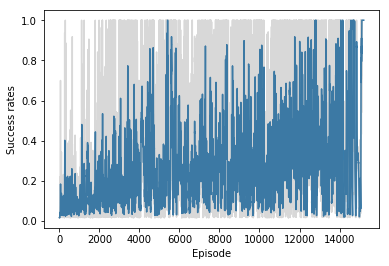

In [34]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

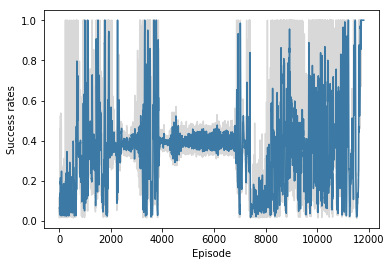

In [28]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

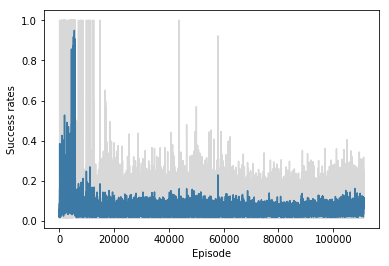

In [233]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

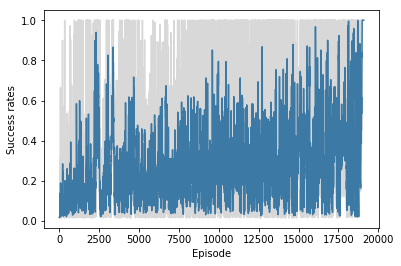

In [223]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

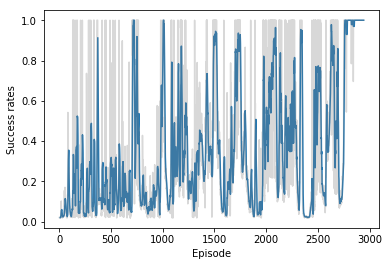

In [219]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

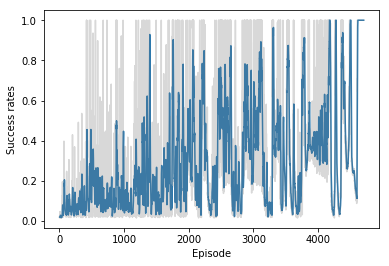

In [213]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

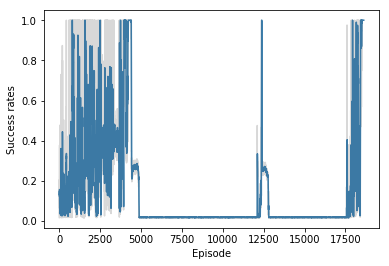

In [209]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

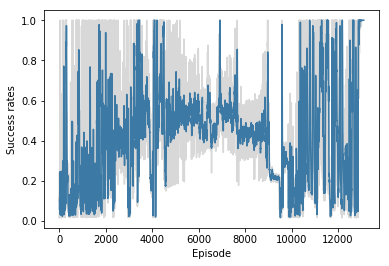

In [187]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

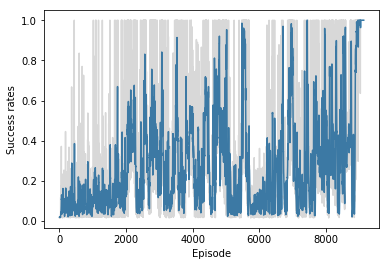

In [170]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

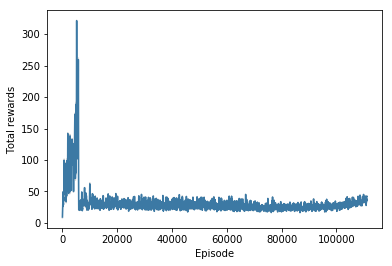

In [232]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

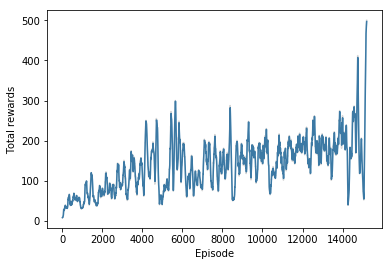

In [35]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

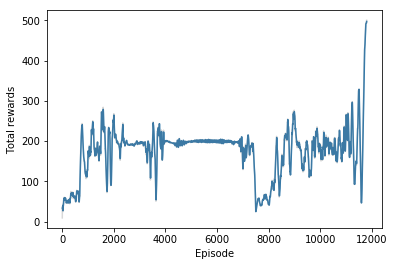

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

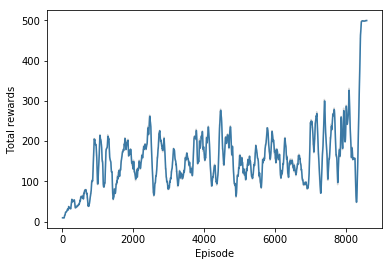

In [229]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

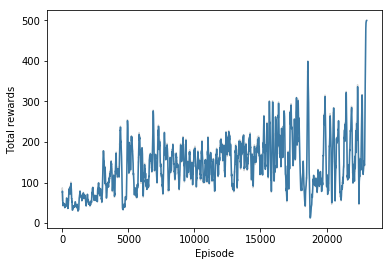

In [227]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

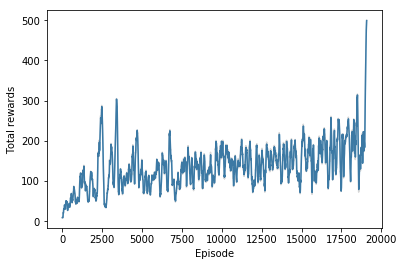

In [224]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

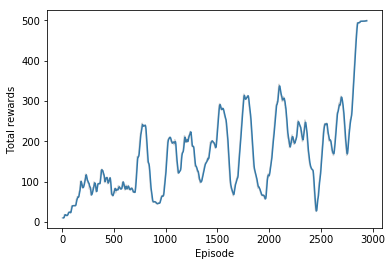

In [221]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

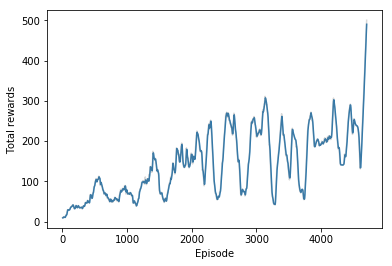

In [216]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

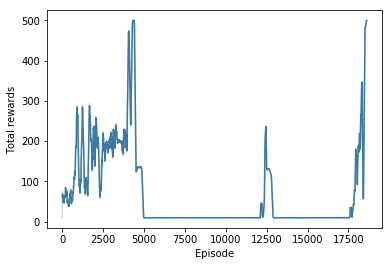

In [203]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

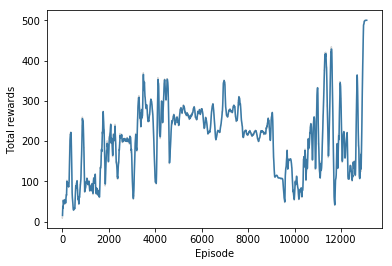

In [188]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

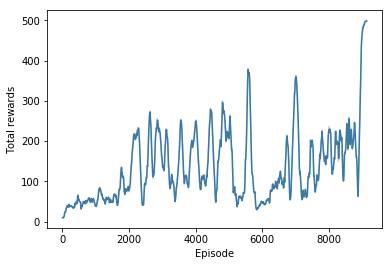

In [165]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

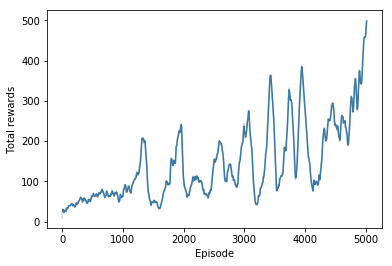

In [126]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

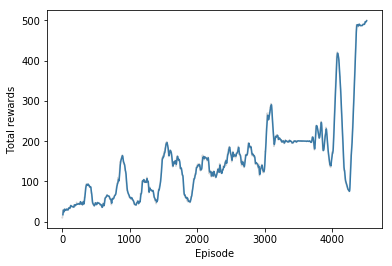

In [109]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

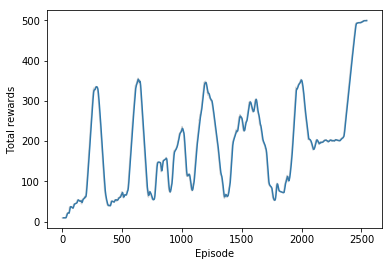

In [84]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

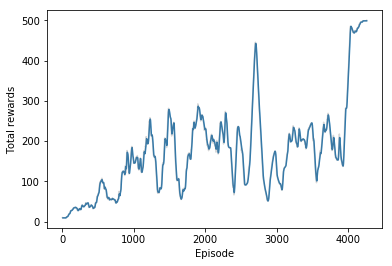

In [64]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

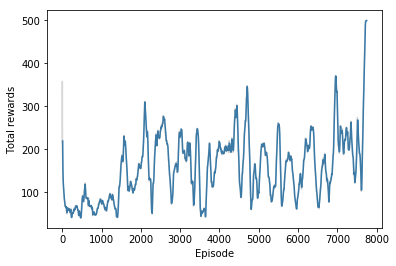

In [44]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

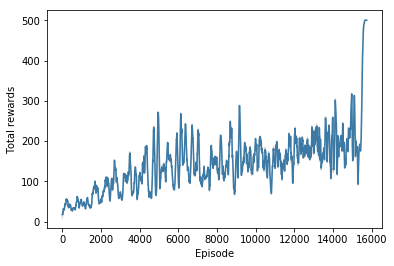

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

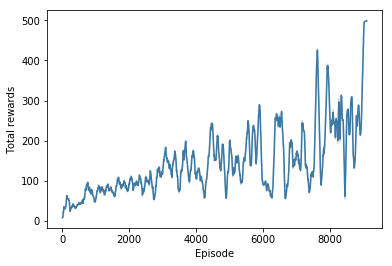

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

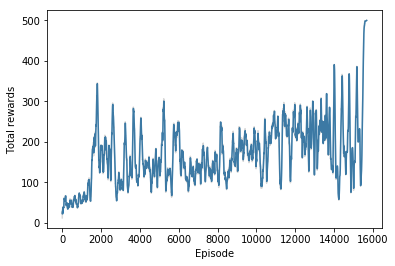

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

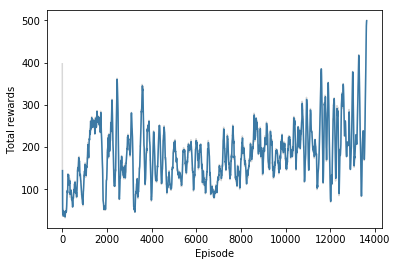

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

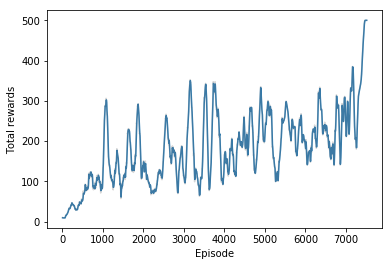

Text(0,0.5,'G losses')

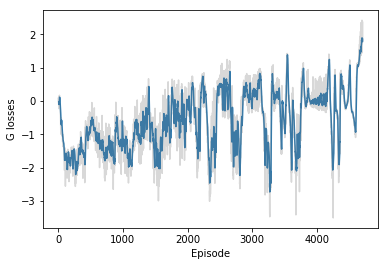

In [215]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

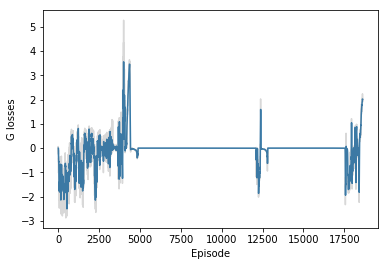

In [204]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

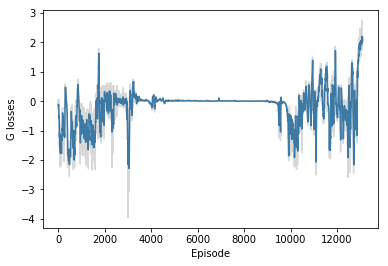

In [189]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

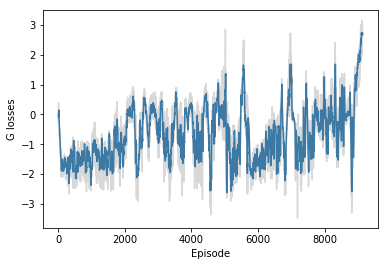

In [166]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

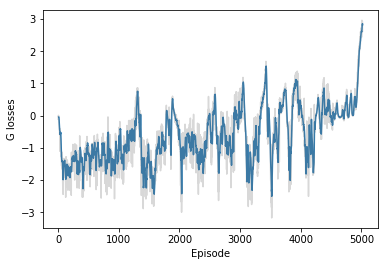

In [129]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

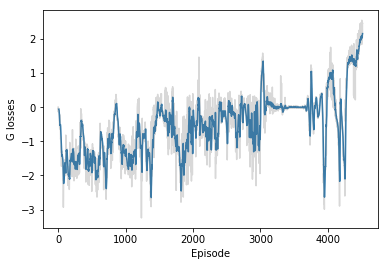

In [110]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

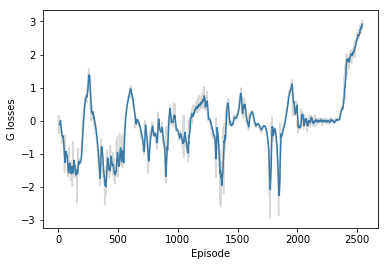

In [85]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

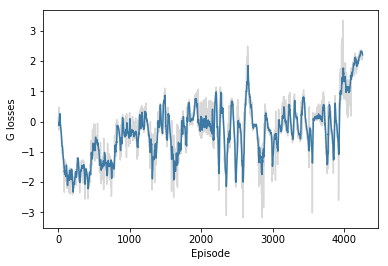

In [65]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

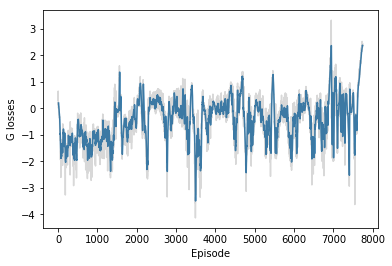

In [45]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

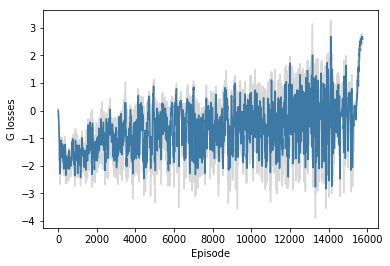

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

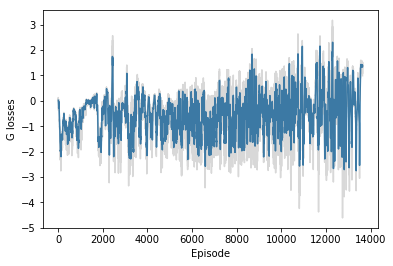

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

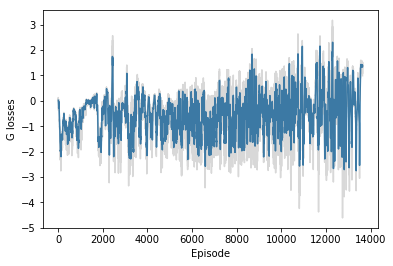

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

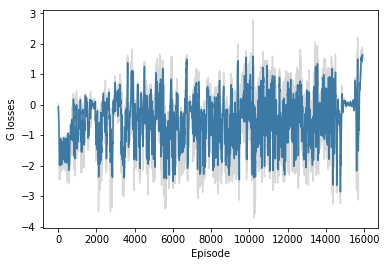
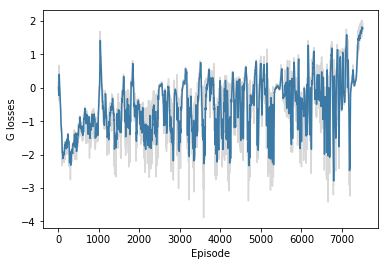

Text(0,0.5,'D losses')

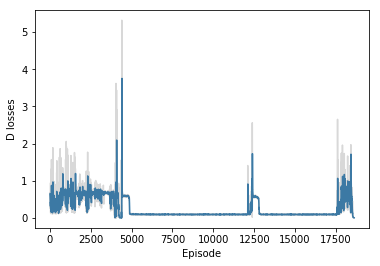

In [205]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

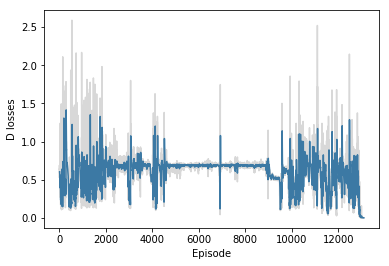

In [190]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

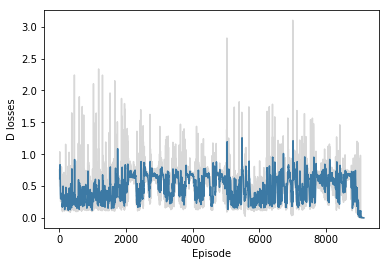

In [167]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

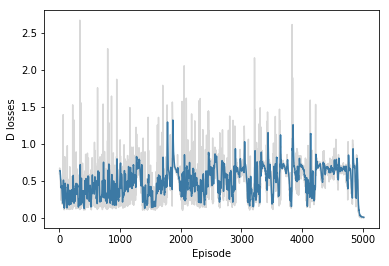

In [130]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

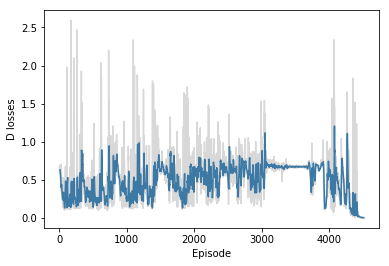

In [111]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

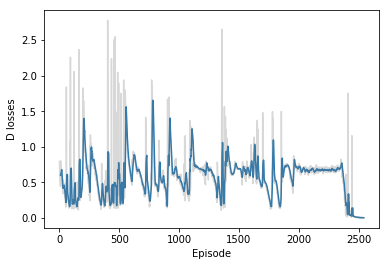

In [86]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

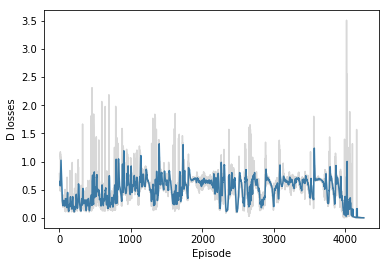

In [66]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

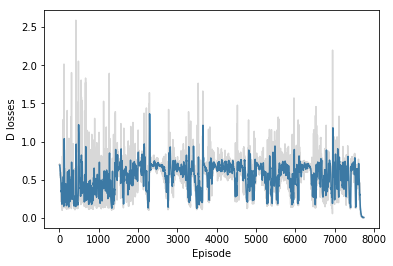

In [46]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

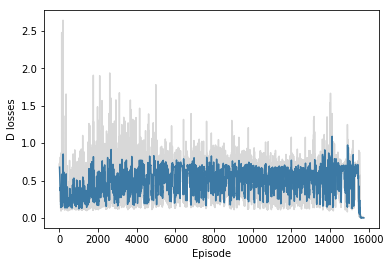

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

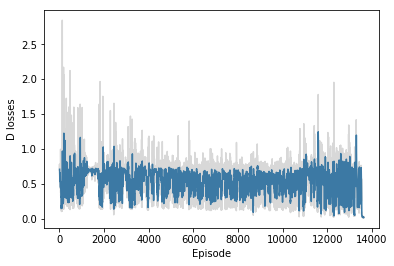

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

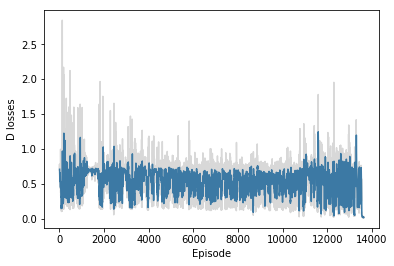

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

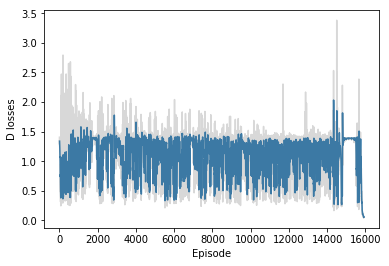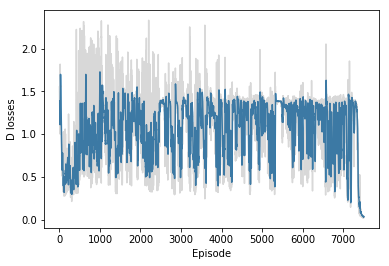

Text(0,0.5,'D losses R')

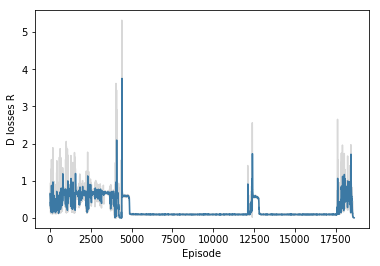

In [207]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

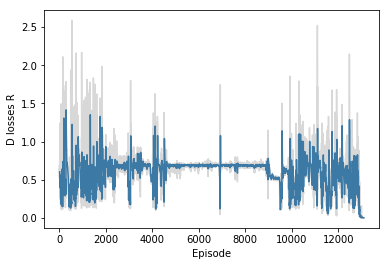

In [191]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

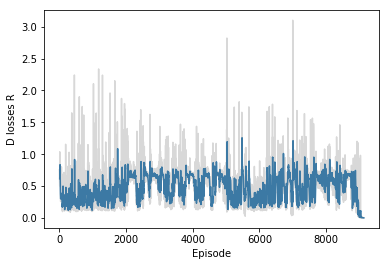

In [168]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

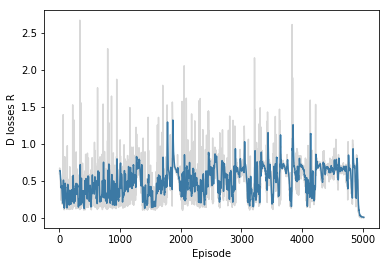

In [131]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

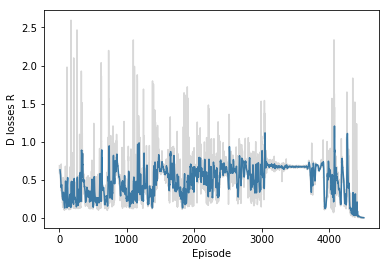

In [112]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

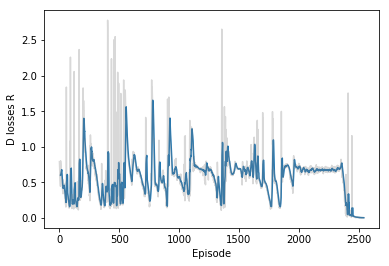

In [87]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

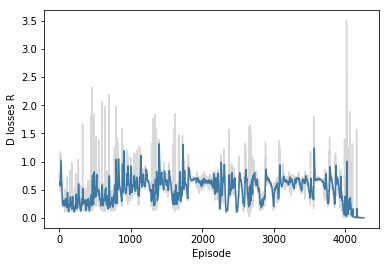

In [67]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

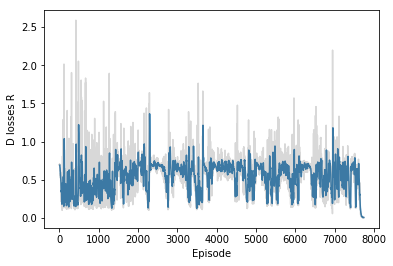

In [47]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

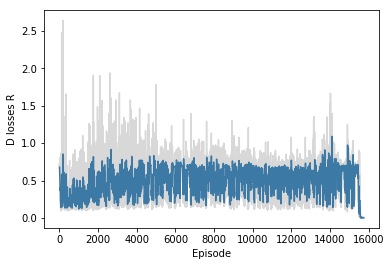

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

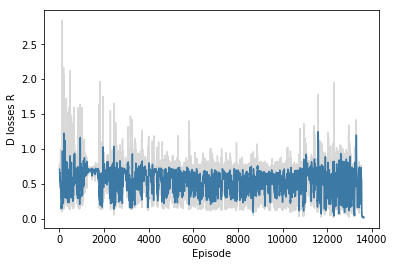

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

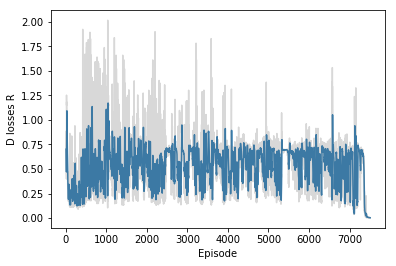

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

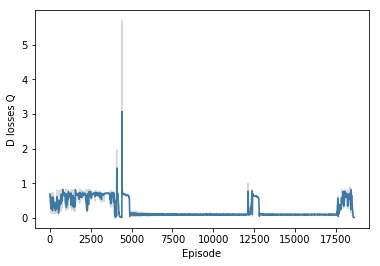

In [208]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

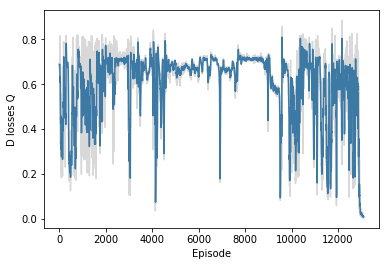

In [192]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

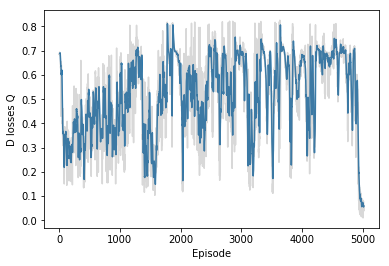

In [132]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

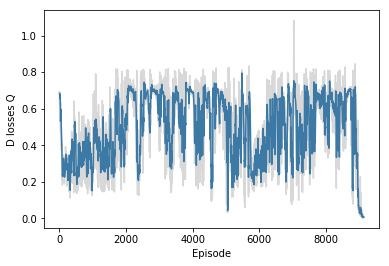

In [169]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

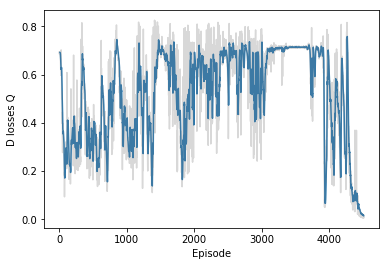

In [113]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

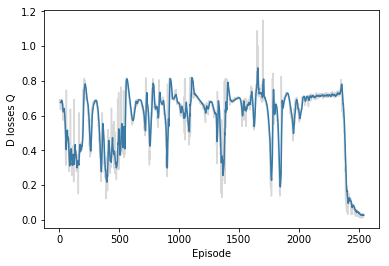

In [88]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

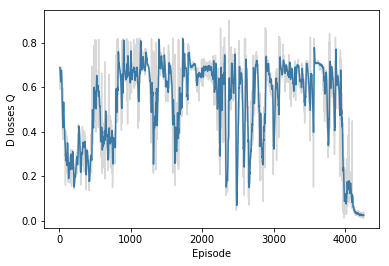

In [68]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

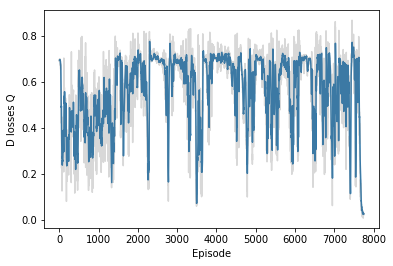

In [48]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

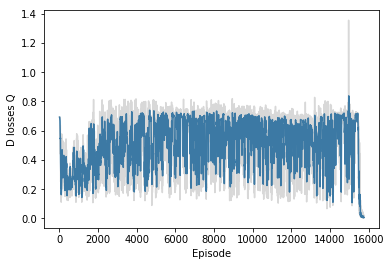

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

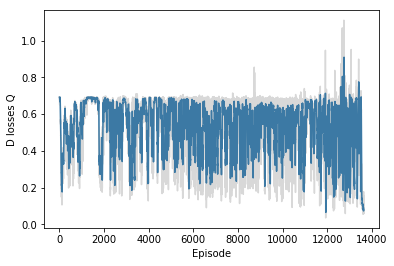

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

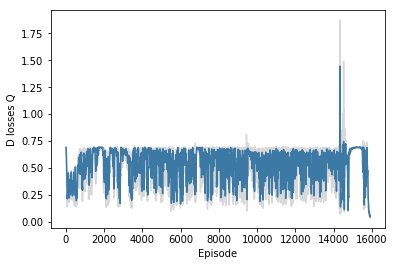

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

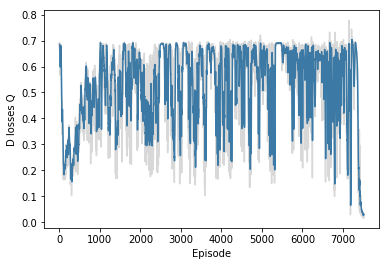

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.